# [Maureen] Inftrain ABX Analysis

## Includes bilingual data

In [1]:
import json
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import warnings
import seaborn as sns

#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower

sns.set_theme()

HOME="/linkhome/rech/genini01/ucv88ce/"
models_path=os.path.join(HOME,"projects/MultilingualCPC/experiments/checkpoints/inftrain" )
eval_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/eval/inftrain'

* Functions definition

In [2]:
def retrieve_scores( size= [50,100, 200, 400, 800, 1600, 3200], abx_type="both", easyfilter = False, models_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/eval/inftrain'):
    fam_dict={}

    #columns = fam_id 	size 	eval_lang 	en_model 	fr_model 	bil_totalsize_A 	bil_totalsize_B 	same 	different 	bil_langsize 	bil_totalsize 	mono_avg (same and diff are just the scores from tje model corresponding to th train and eval)
    #do average of within and across
    langs=["EN","FR","EN+FR"]

    for s in sorted(size):
        s=int(s)
        for fam in ["{}".format(str(x).zfill(2)) for x in range(int(32/s*100))] :

            for contrast, eval_lang in zip(['fr_ii-uu'], ['fr']):
                k = fam+"_"+eval_lang+"_"+str(s)

                values = [fam, int(s), eval_lang]

                for model in langs:
                    
                    if model == "EN" or model == "FR" :
                        
                        path = os.path.join(models_path,model,str(s)+"h",fam,"cpc_small/ABX_CV","**",contrast, "ABX_scores.json")
                        json_f = glob(path, recursive=True)
                        if easyfilter : 
                            json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                        else:
                            json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                        
                        if len(json_f) > 1:
                            json_f = [max(json_f, key=os.path.getctime)]

                        if not json_f :
                            score = np.nan
                        else:
                            with open(json_f[0], "r") as f:

                                scores = json.load(f)
                            if abx_type == "both" :
                                score = np.mean([scores['within'],scores['across']]) * 100
                            else :
                                score = scores[abx_type]*100
                        values.append(score)

                    elif model == "EN+FR" :
                        bil_scores = []
                        for bil_fam in [str(int(fam)*2).zfill(2), str((int(fam)*2) + 1).zfill(2)] :
                            path = os.path.join(models_path,model,str(s)+"h",bil_fam,"cpc_small/ABX_CV","**",contrast, "ABX_scores.json")
                            json_f = glob(path, recursive=True)
                            
                            
                            if easyfilter : 
                                json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                            else:
                                json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                                                        
                            if len(json_f) > 1:
                                
                                json_f = [max(json_f, key=os.path.getctime)]

                            if not json_f :
                                score = np.nan
                            else:
                                with open(json_f[0], "r") as f:
                                    scores = json.load(f)
                                if abx_type == "both" :
                                    score = np.mean([scores['within'],scores['across']]) * 100
                                else :
                                    score = scores[abx_type]*100 
                                    
                            values.append(score)
                            
                            #below add langsize
                            if fam+"_"+eval_lang+"_"+str(int(s/2)) in fam_dict :
                                fam_dict[bil_fam+"_"+eval_lang+"_"+str(int(s/2))][-1] = score


                        
                    if model == "EN" and eval_lang == "en" :
                        same = score
                    elif model == "EN" and eval_lang == "fr" :
                        different = score
                    elif model == "FR" and eval_lang == "fr" :
                        same = score
                    elif model == "FR" and eval_lang == "en" :
                        different = score

                values.append(same)
                values.append(different)
                values.append(np.nan) #eate space for the "bil_add"
                fam_dict[k] = values
                


    

    df = pd.DataFrame.from_dict(fam_dict, orient='index', columns=["fam_id", "size", "eval_lang", "en_model", "fr_model", "bil_totalsize_A", "bil_totalsize_B", 'same', 'different', "bil_langsize"])
    df['bil_totalsize'] = df[["bil_totalsize_A", "bil_totalsize_B"]].mean(axis=1)
    df["mono_avg"] = df[["en_model", "fr_model"]].mean(axis=1)
    return df

## Retrieve ABX scores & datasets

*MDS - Todo : add lambda function to systematically retrieve latest checkpoint ABX score*

1. df_within : original ABX scores calculated "within speaker"
2. df_across : original ABX scores calculated "across speakers"
3. df_ef_within : "easyfilter" ABX scores calculated "within speaker"
4. df_ef_across : "easyfilter" ABX scores calculated "across speakers"


The "easyfilter" abx scores correspond, for the french scores, to the scores calculated on the "quickfix" item files (see [Google Document](https://docs.google.com/document/d/1XoGX52rBFOwue2twX02IuEhO_-ZktSZh-qdvpuBqK3I/edit?usp=sharing)). The english scores are the same as the original ones. 

In [3]:
abx_type="both"
abx_type="within"


df_within = retrieve_scores(abx_type="within")
df_within_size = df_within.groupby(by="size").mean()

df_across = retrieve_scores(abx_type="across")
df_across_size = df_across.groupby(by="size").mean()

err_within=df_within.groupby('size').std()
err_across=df_across.groupby('size').std()

In [4]:
df_within

,fam_id,size,eval_lang,en_model,fr_model,bil_totalsize_A,bil_totalsize_B,same,different,bil_langsize,bil_totalsize,mono_avg
00_fr_50,00,50,fr,27.236560,28.664264,NaN,NaN,28.664264,27.236560,NaN,NaN,27.950412
01_fr_50,01,50,fr,28.730613,28.094977,NaN,NaN,28.094977,28.730613,NaN,NaN,28.412795
02_fr_50,02,50,fr,30.344626,29.004419,NaN,NaN,29.004419,30.344626,NaN,NaN,29.674523
03_fr_50,03,50,fr,28.189960,29.816437,NaN,NaN,29.816437,28.189960,NaN,NaN,29.003198
04_fr_50,04,50,fr,29.977760,31.342977,NaN,NaN,31.342977,29.977760,NaN,NaN,30.660369
...,...,...,...,...,...,...,...,...,...,...,...,...
02_fr_800,02,800,fr,23.899612,23.870084,NaN,NaN,23.870084,23.899612,NaN,NaN,23.884848
03_fr_800,03,800,fr,25.424528,24.968293,NaN,NaN,24.968293,25.424528,NaN,NaN,25.196411
00_fr_1600,00,1600,fr,24.440601,23.740195,NaN,NaN,23.740195,24.440601,NaN,NaN,24.090398
01_fr_1600,01,1600,fr,23.834884,23.617840,NaN,NaN,23.617840,23.834884,NaN,NaN,23.726362


# Figures

## A. Boxplots of ABX scores in function of training size for the different model types

### A1 - ABX across speakers - original
- Test set : average of French and English
- Df : Original

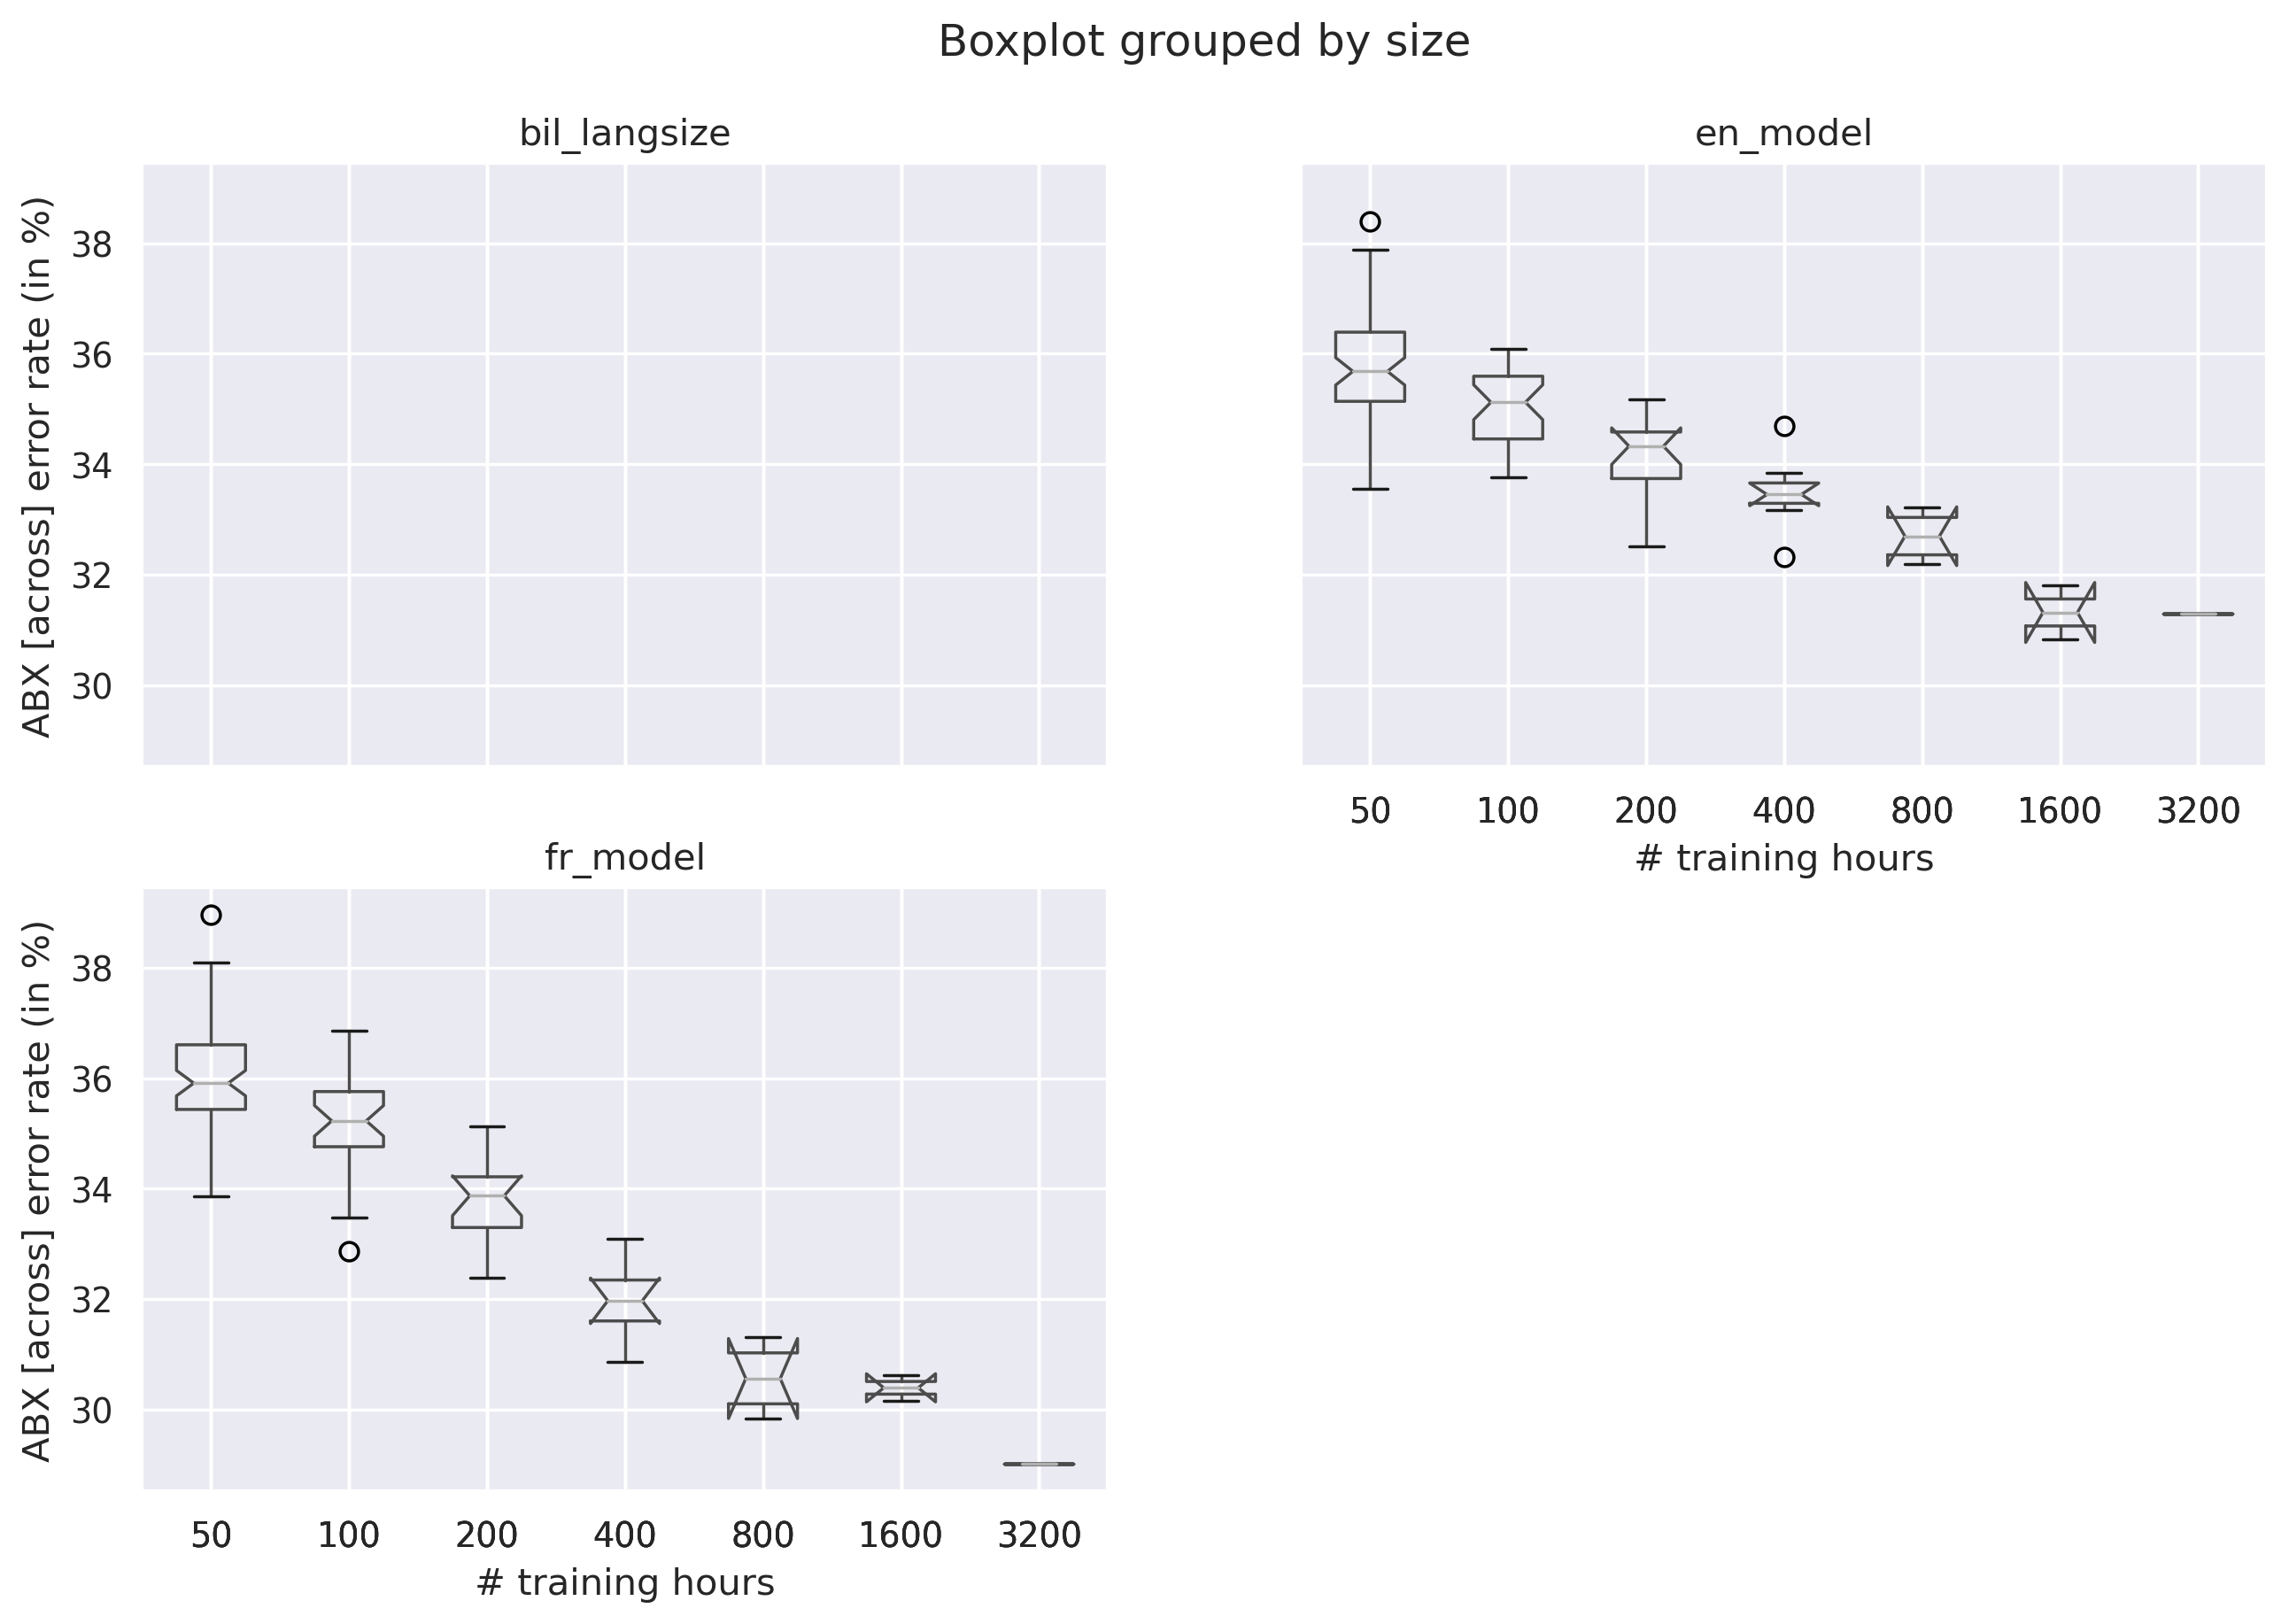

In [5]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [across] error rate (in %)')
    bp.set_xlabel('# training hours')


Text(0.5, 0, 'test set')

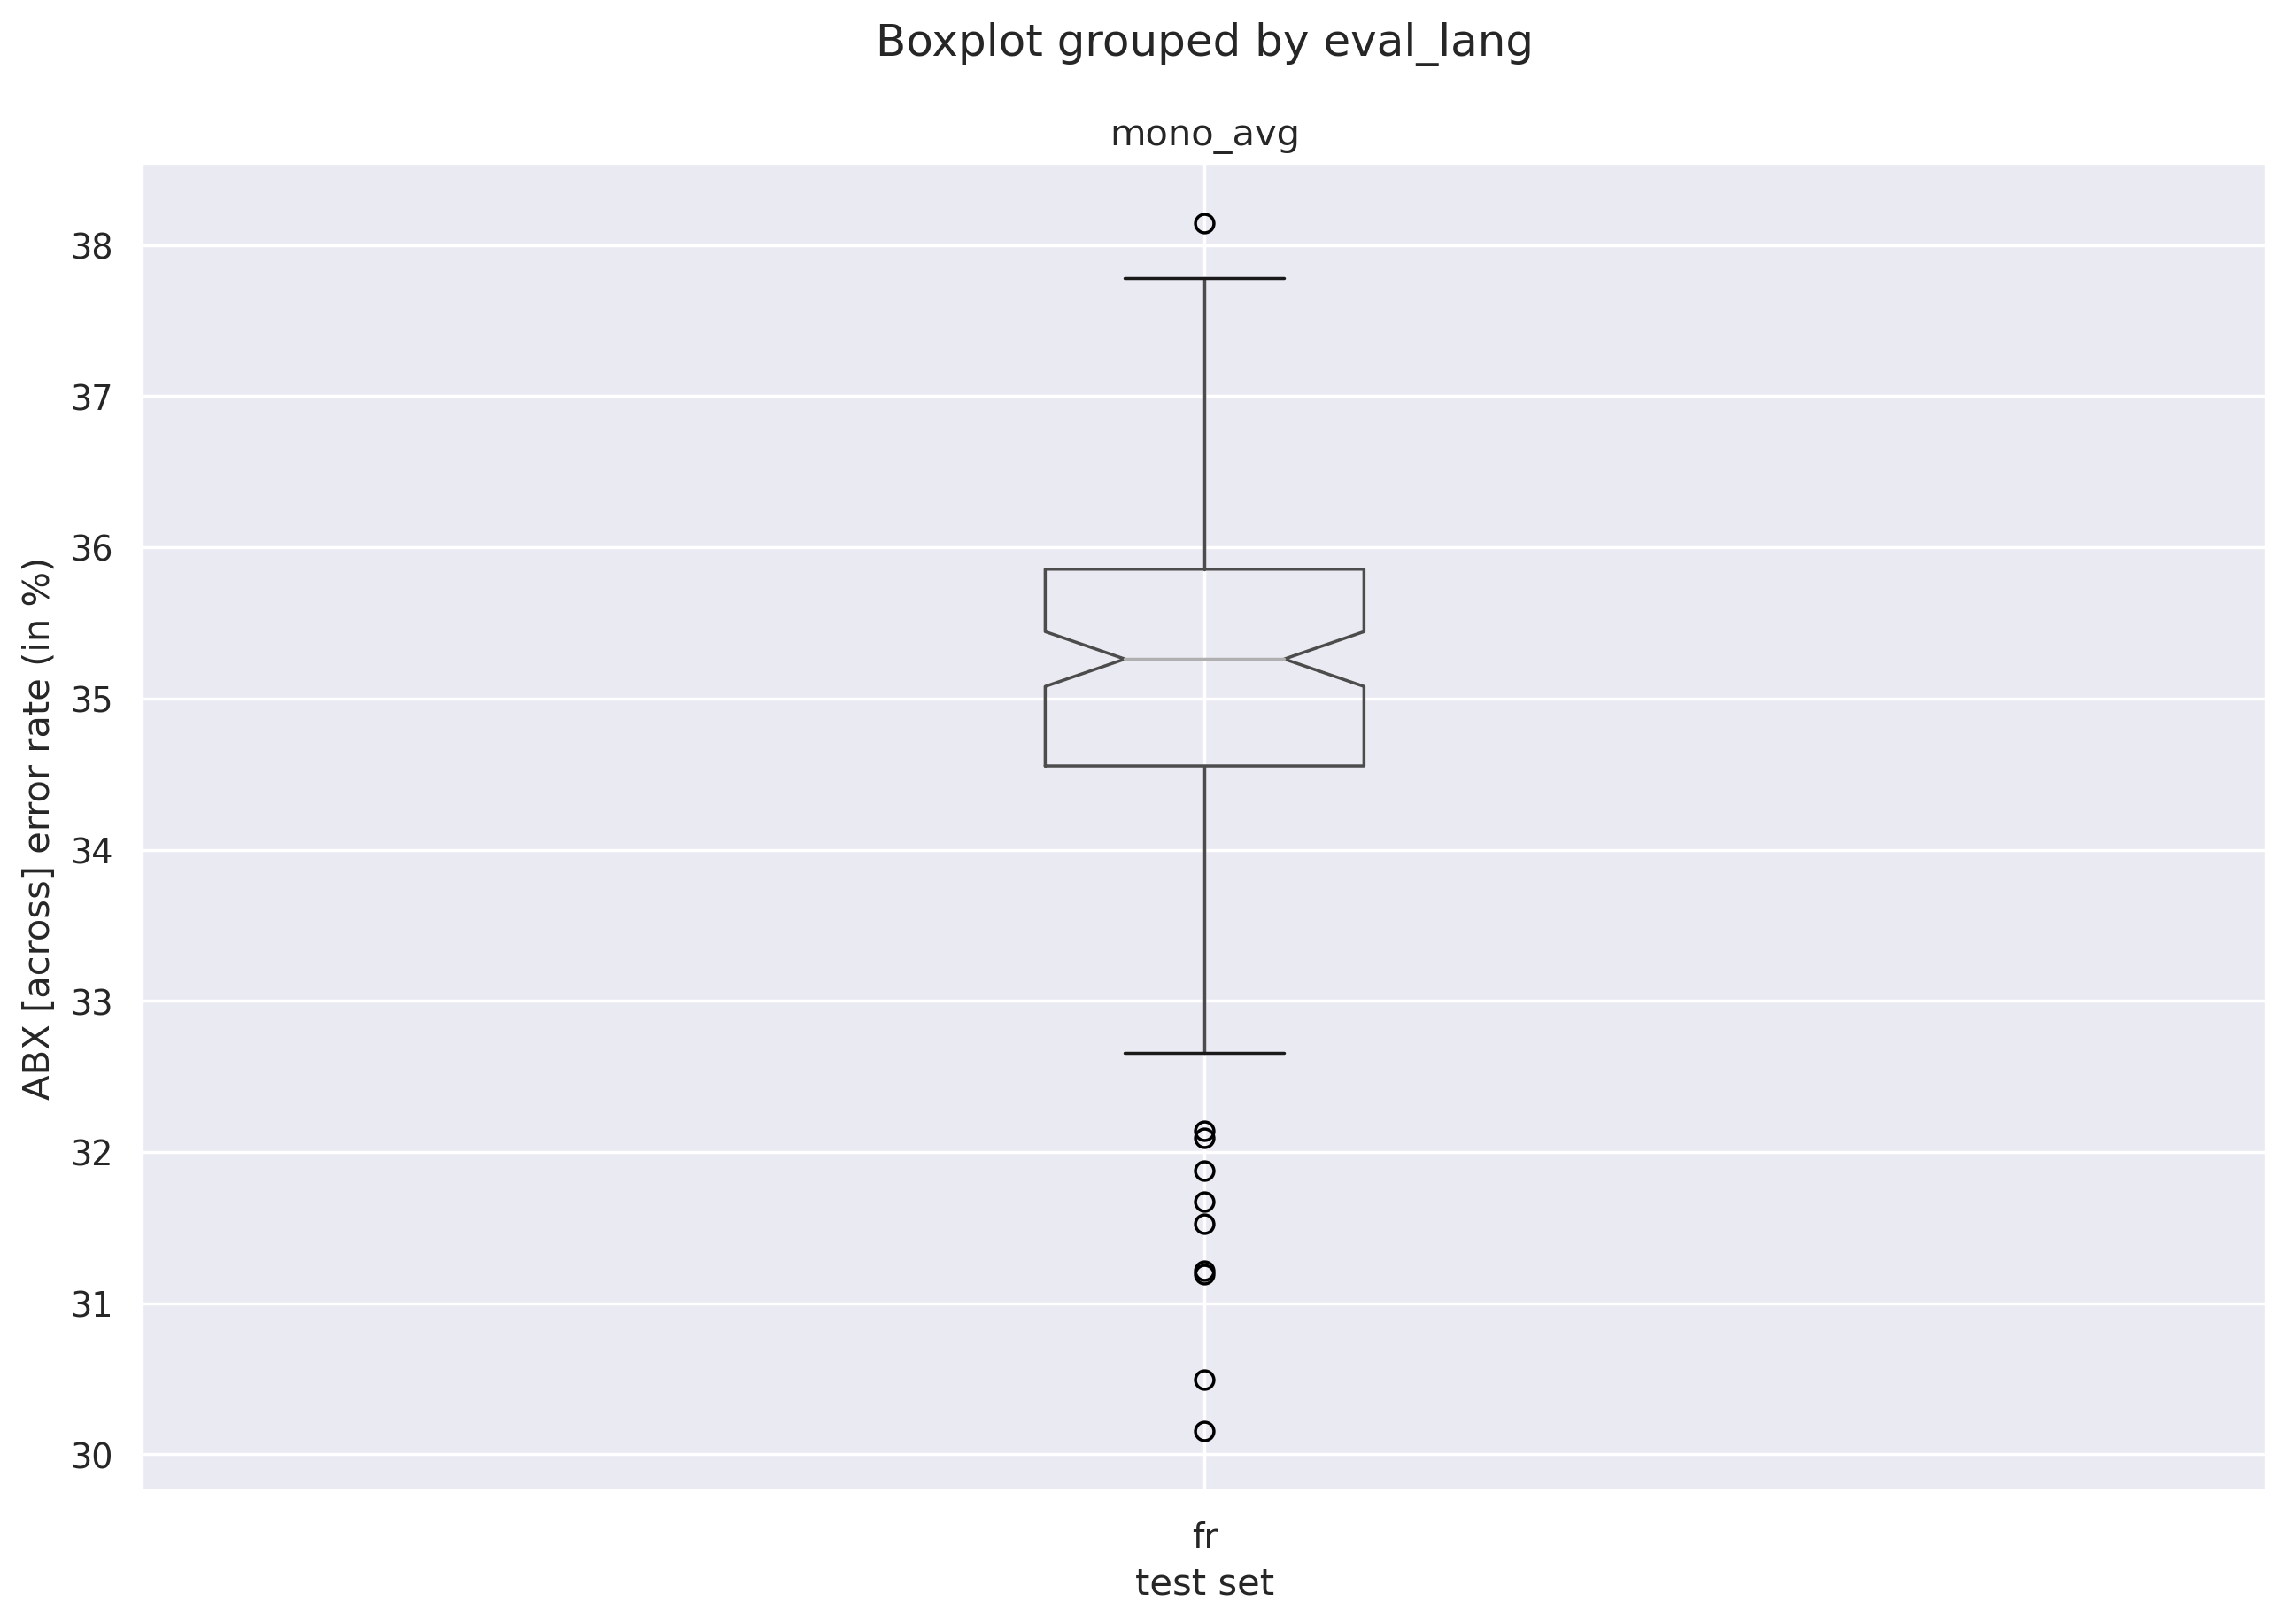

In [6]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_across[['mono_avg',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

plt.ylabel('ABX [across] error rate (in %)')
plt.xlabel('test set')


### A2 - ABX within speakers  - original
- Test set : average of French and English
- Df : Original

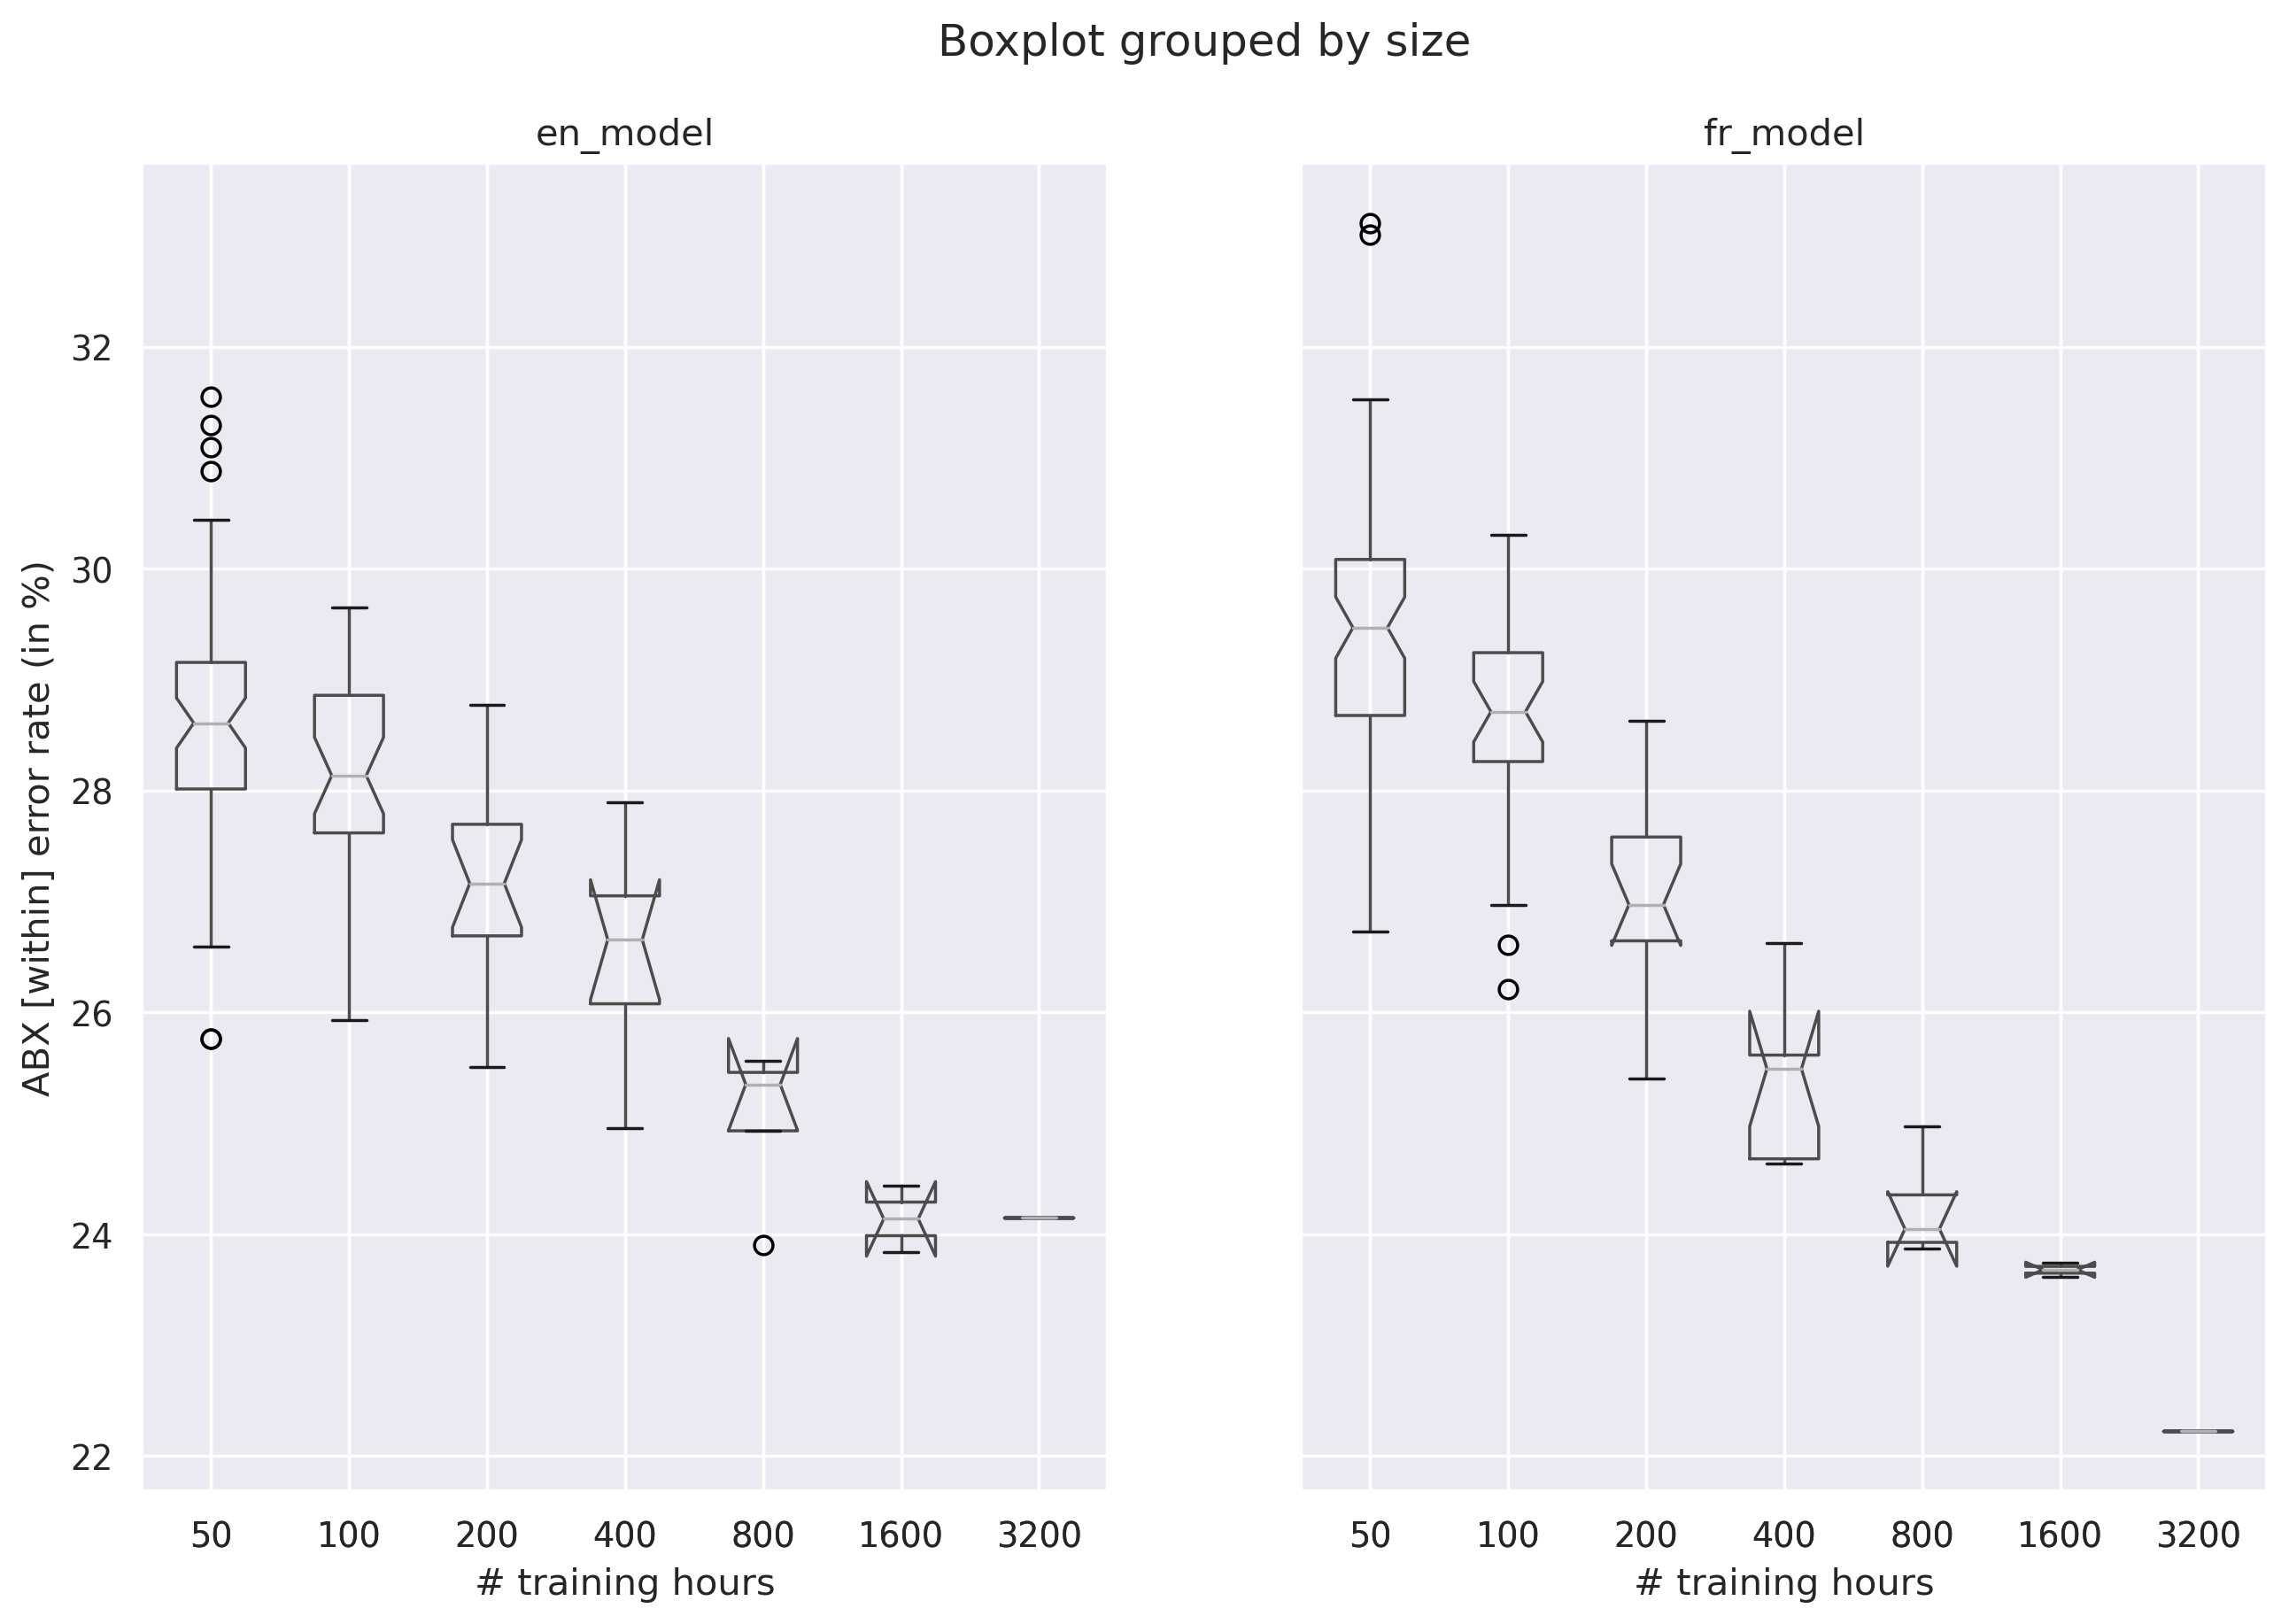

In [7]:
boxplot = df_within[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
#boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [within] error rate (in %)')
    bp.set_xlabel('# training hours')


Text(0.5, 0, 'test set')

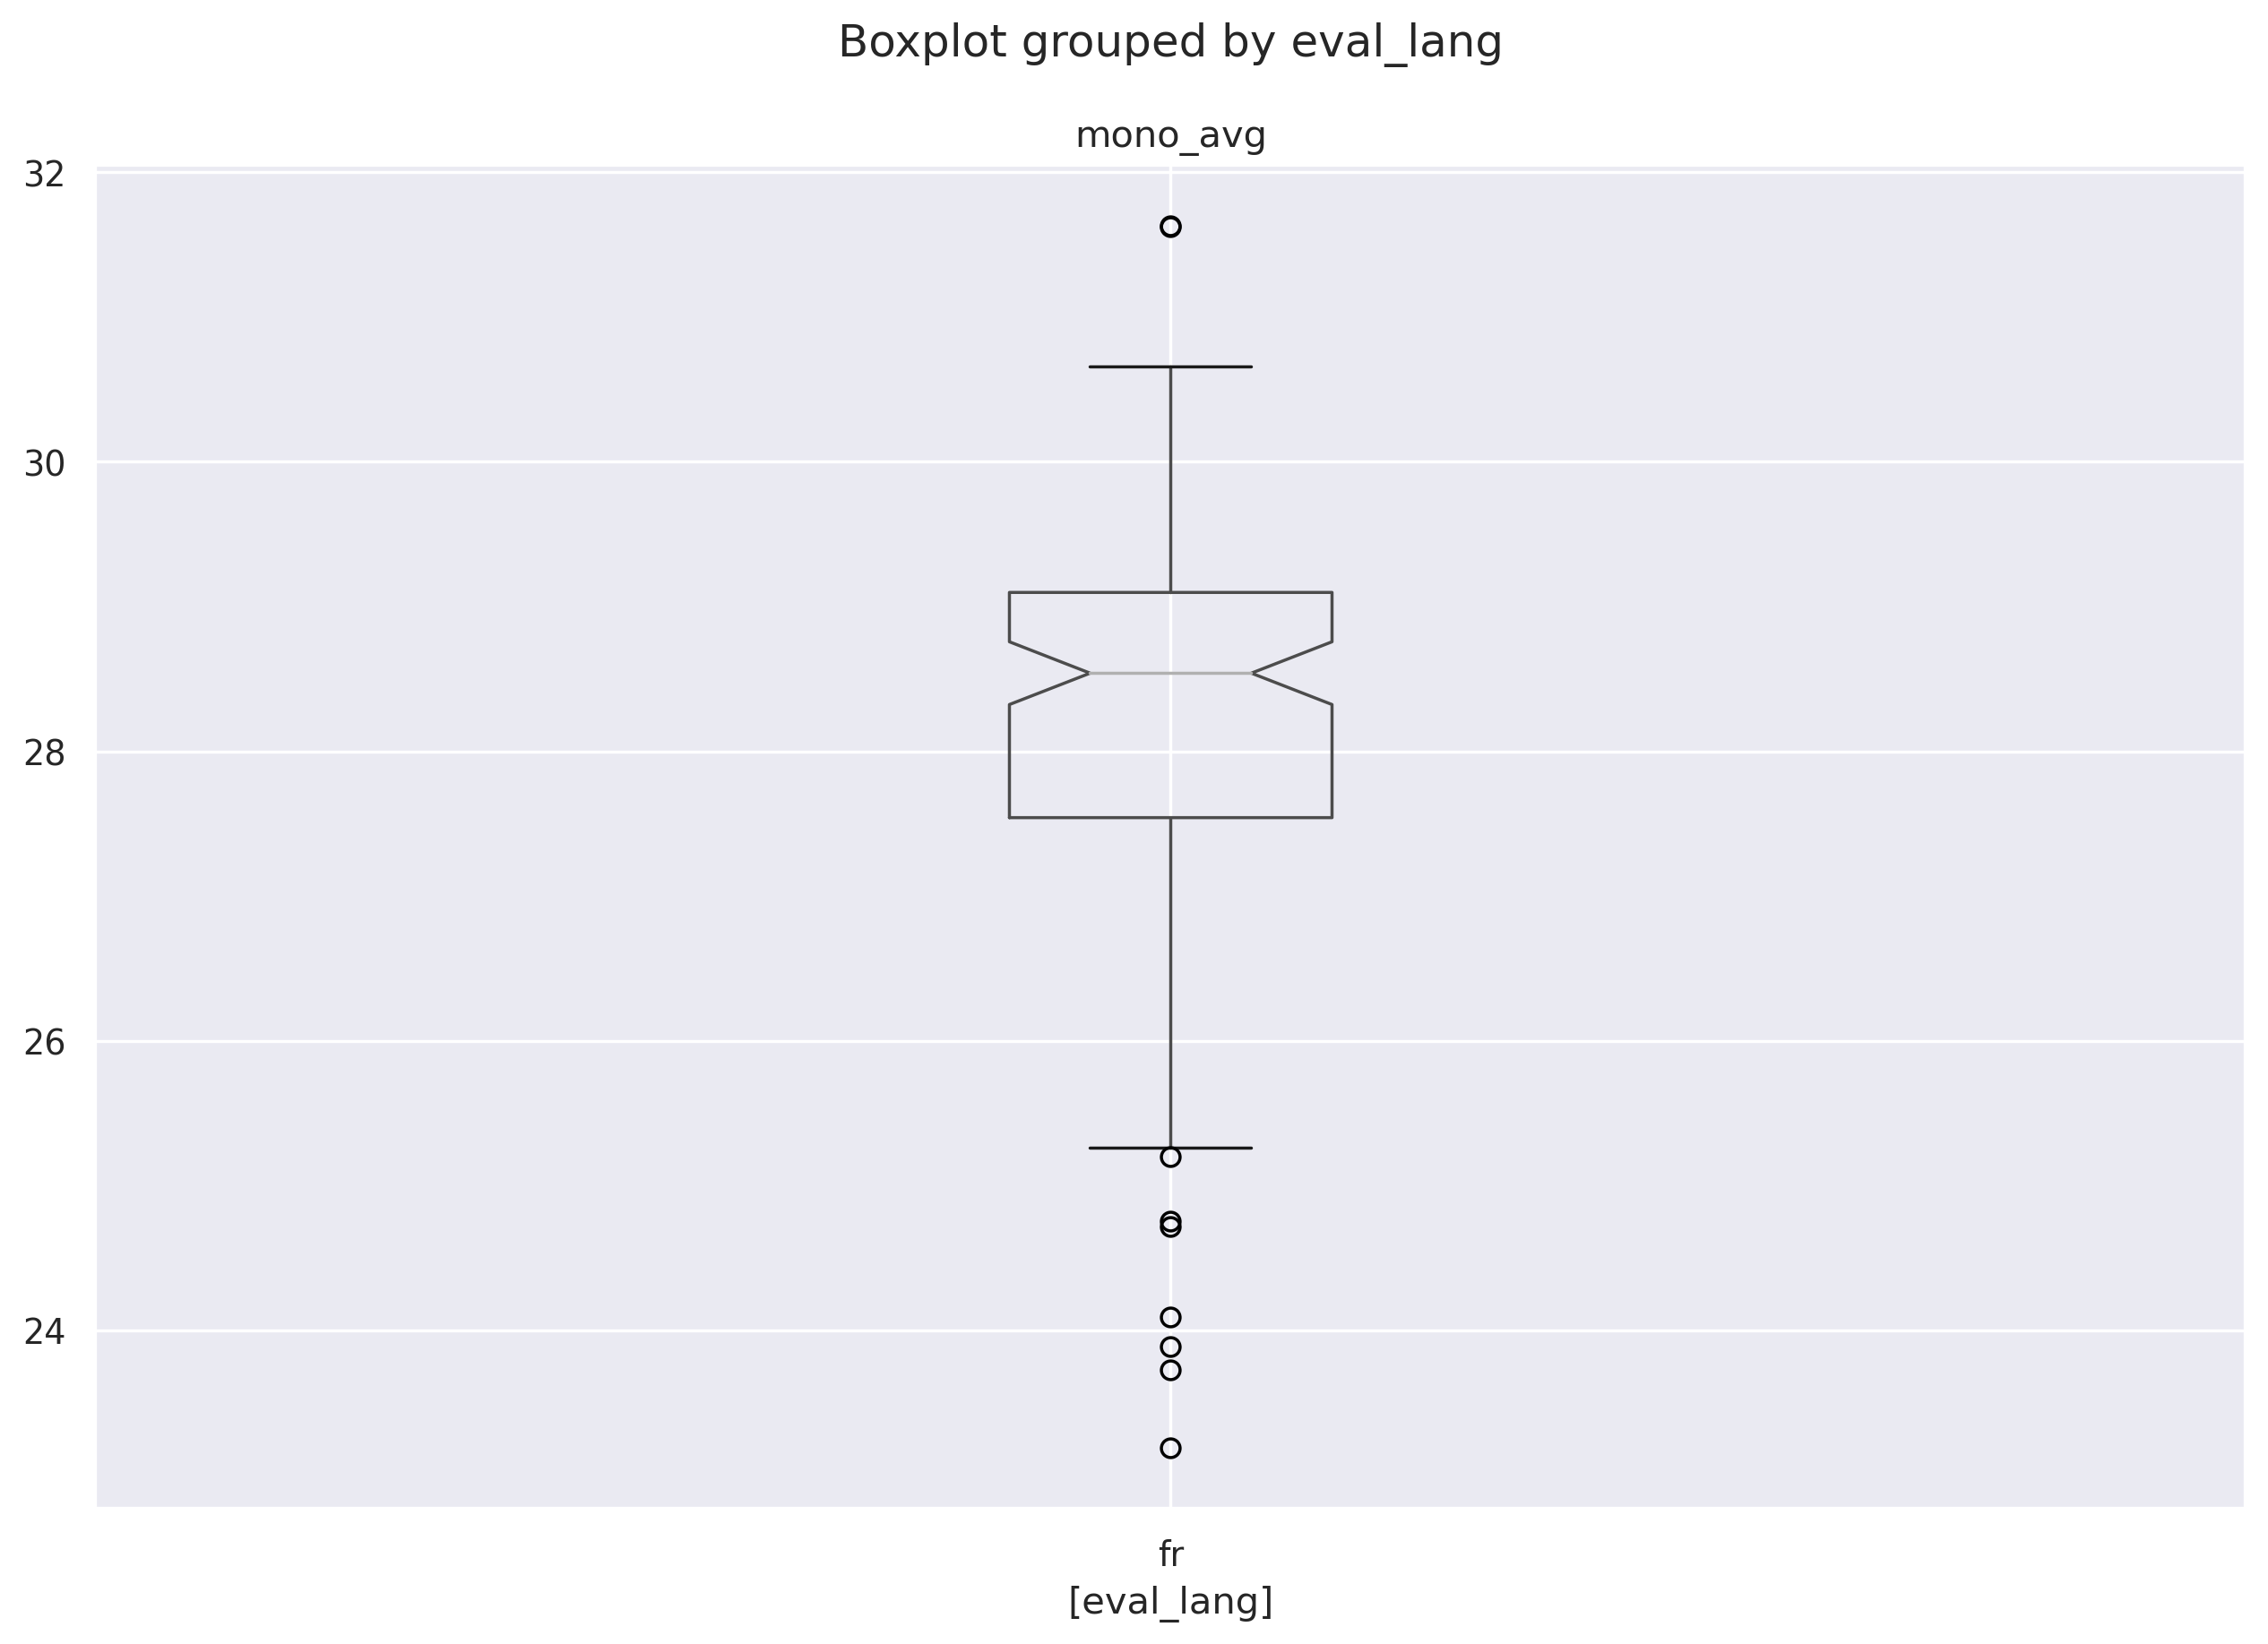

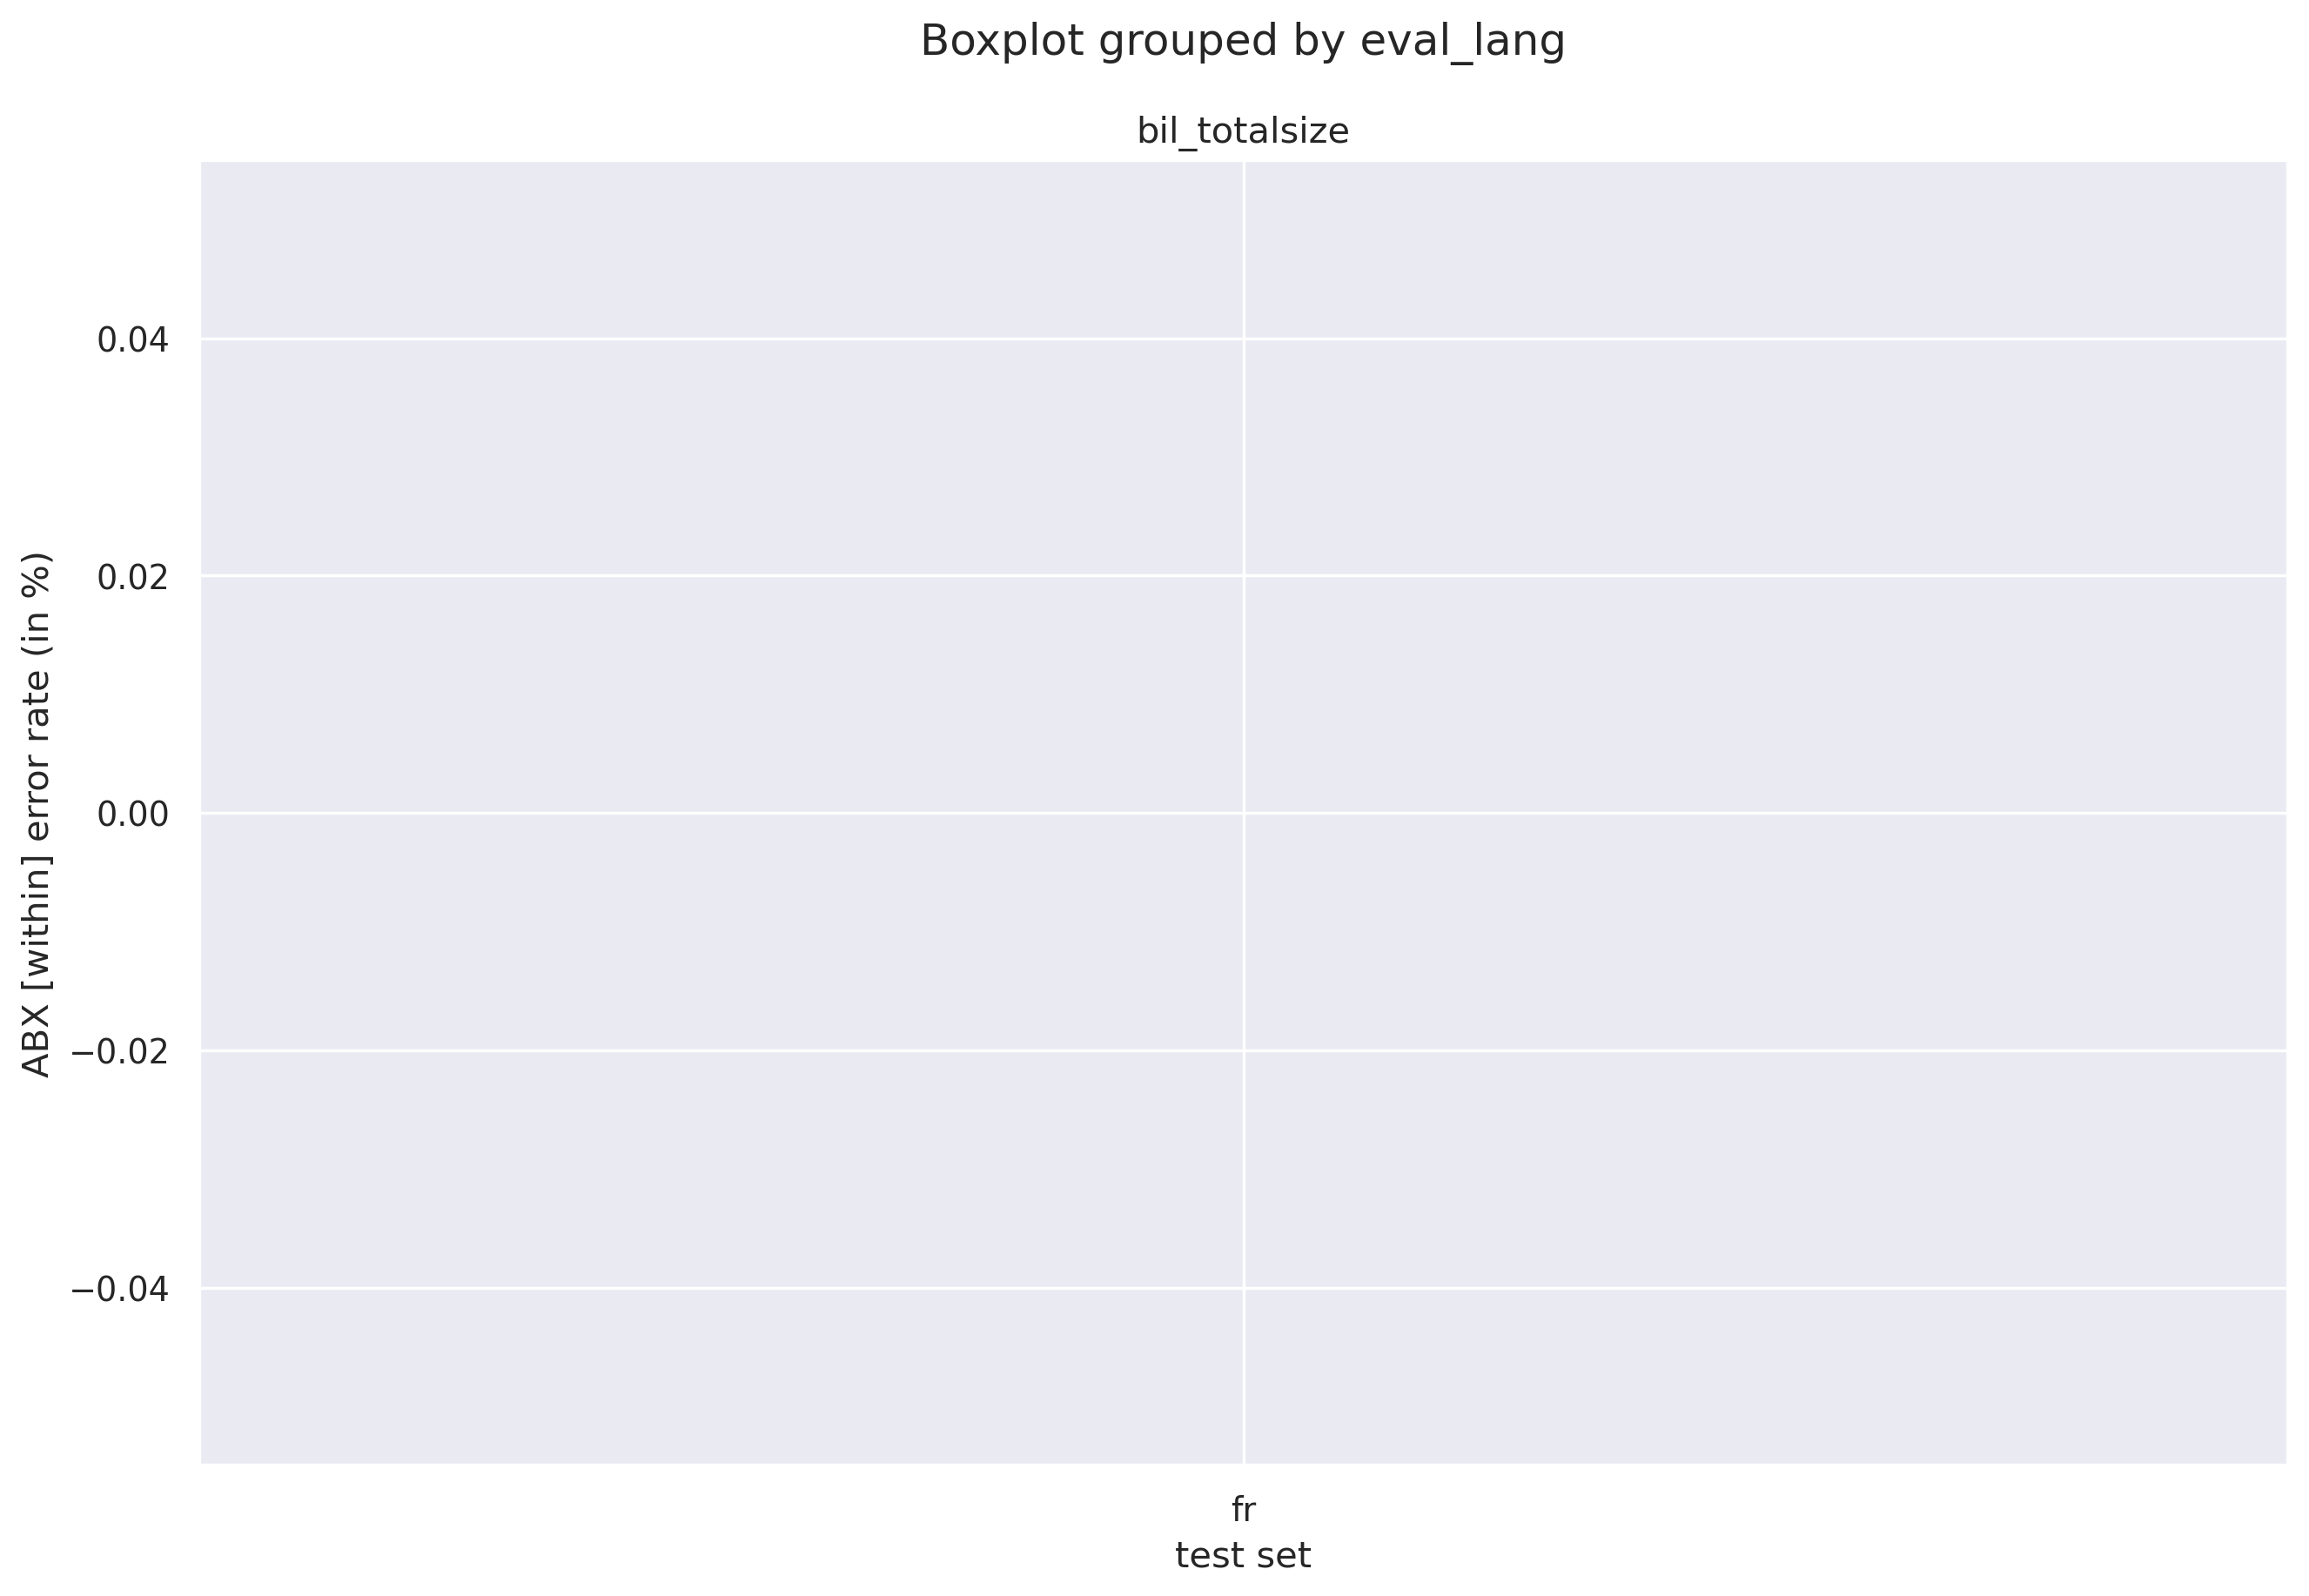

In [8]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_within[['mono_avg',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

boxplot = df_within[['bil_totalsize',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('test set')


## C. Comparing Monolingual vs Bilingual ABX scores 



### C1. French vs English vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')

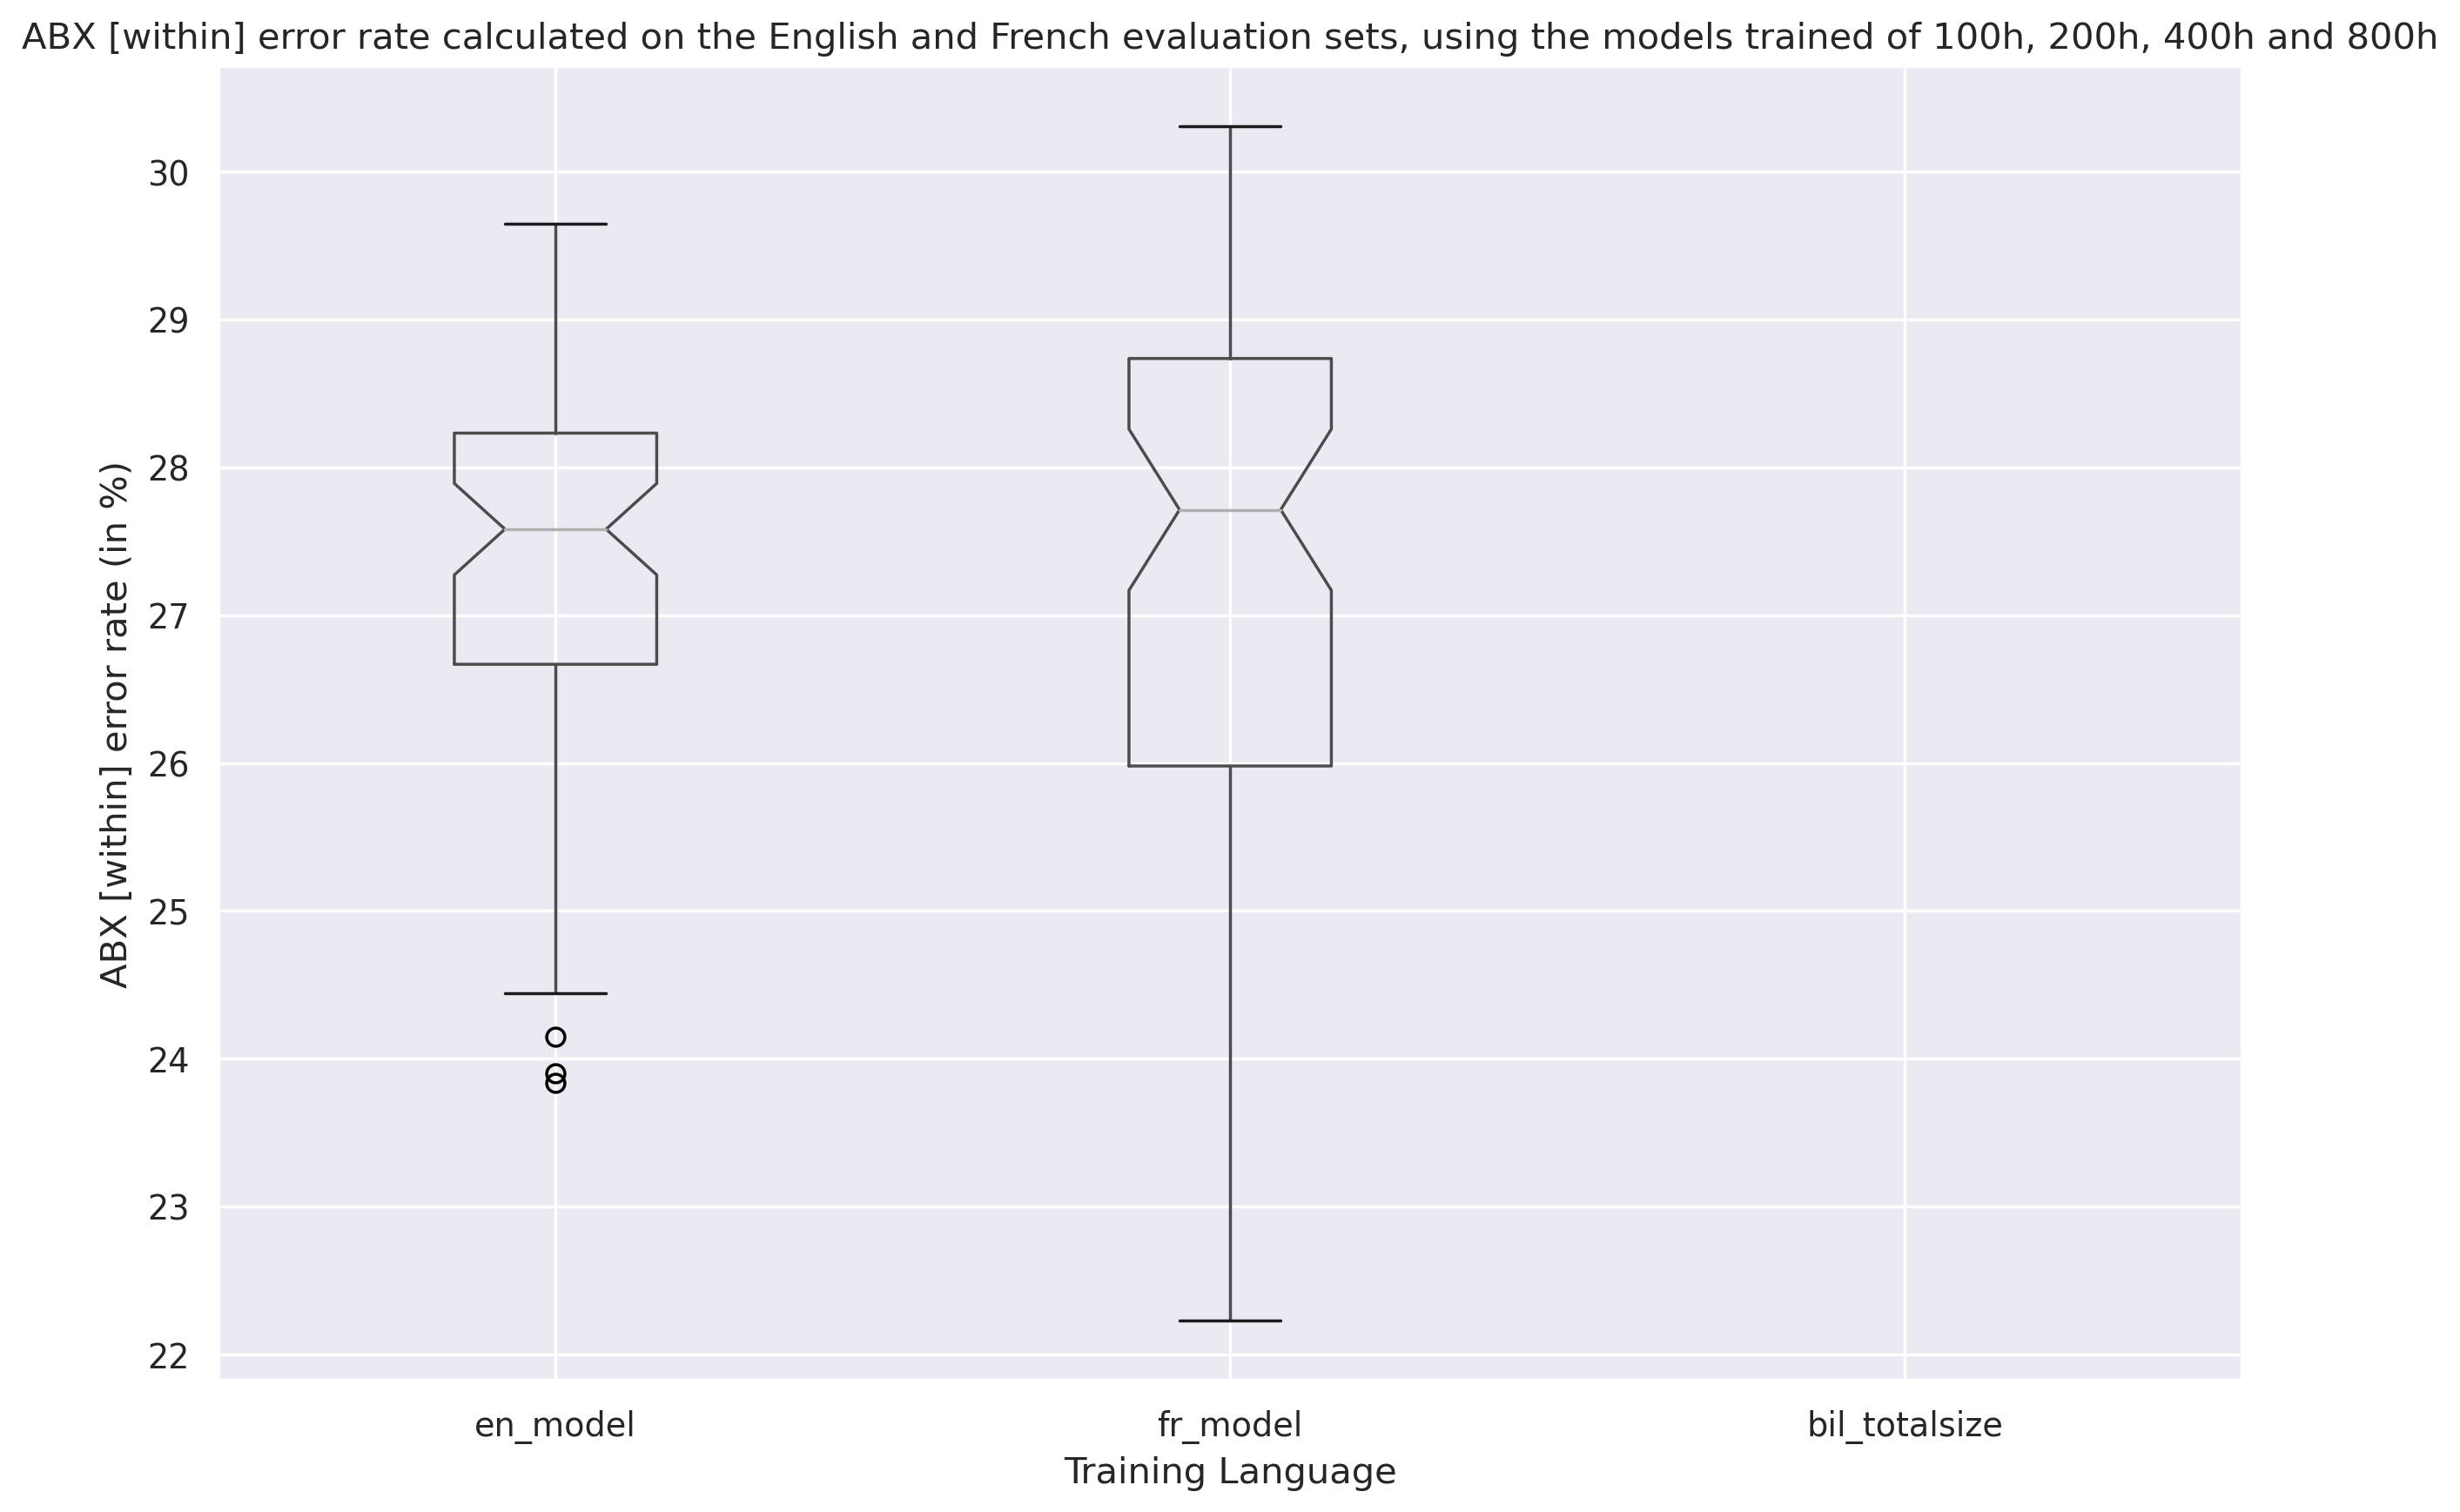

In [9]:
boxplot = df_within[['en_model', 'fr_model', 'bil_totalsize','eval_lang']][df_within["size"] > 50].boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')



Text(0.5, 1.0, 'ABX [within] error rate calculated on the same and different evaluation sets, using the models trained of 100h, 200h, 400h, 800h, 1600h and 3200h')

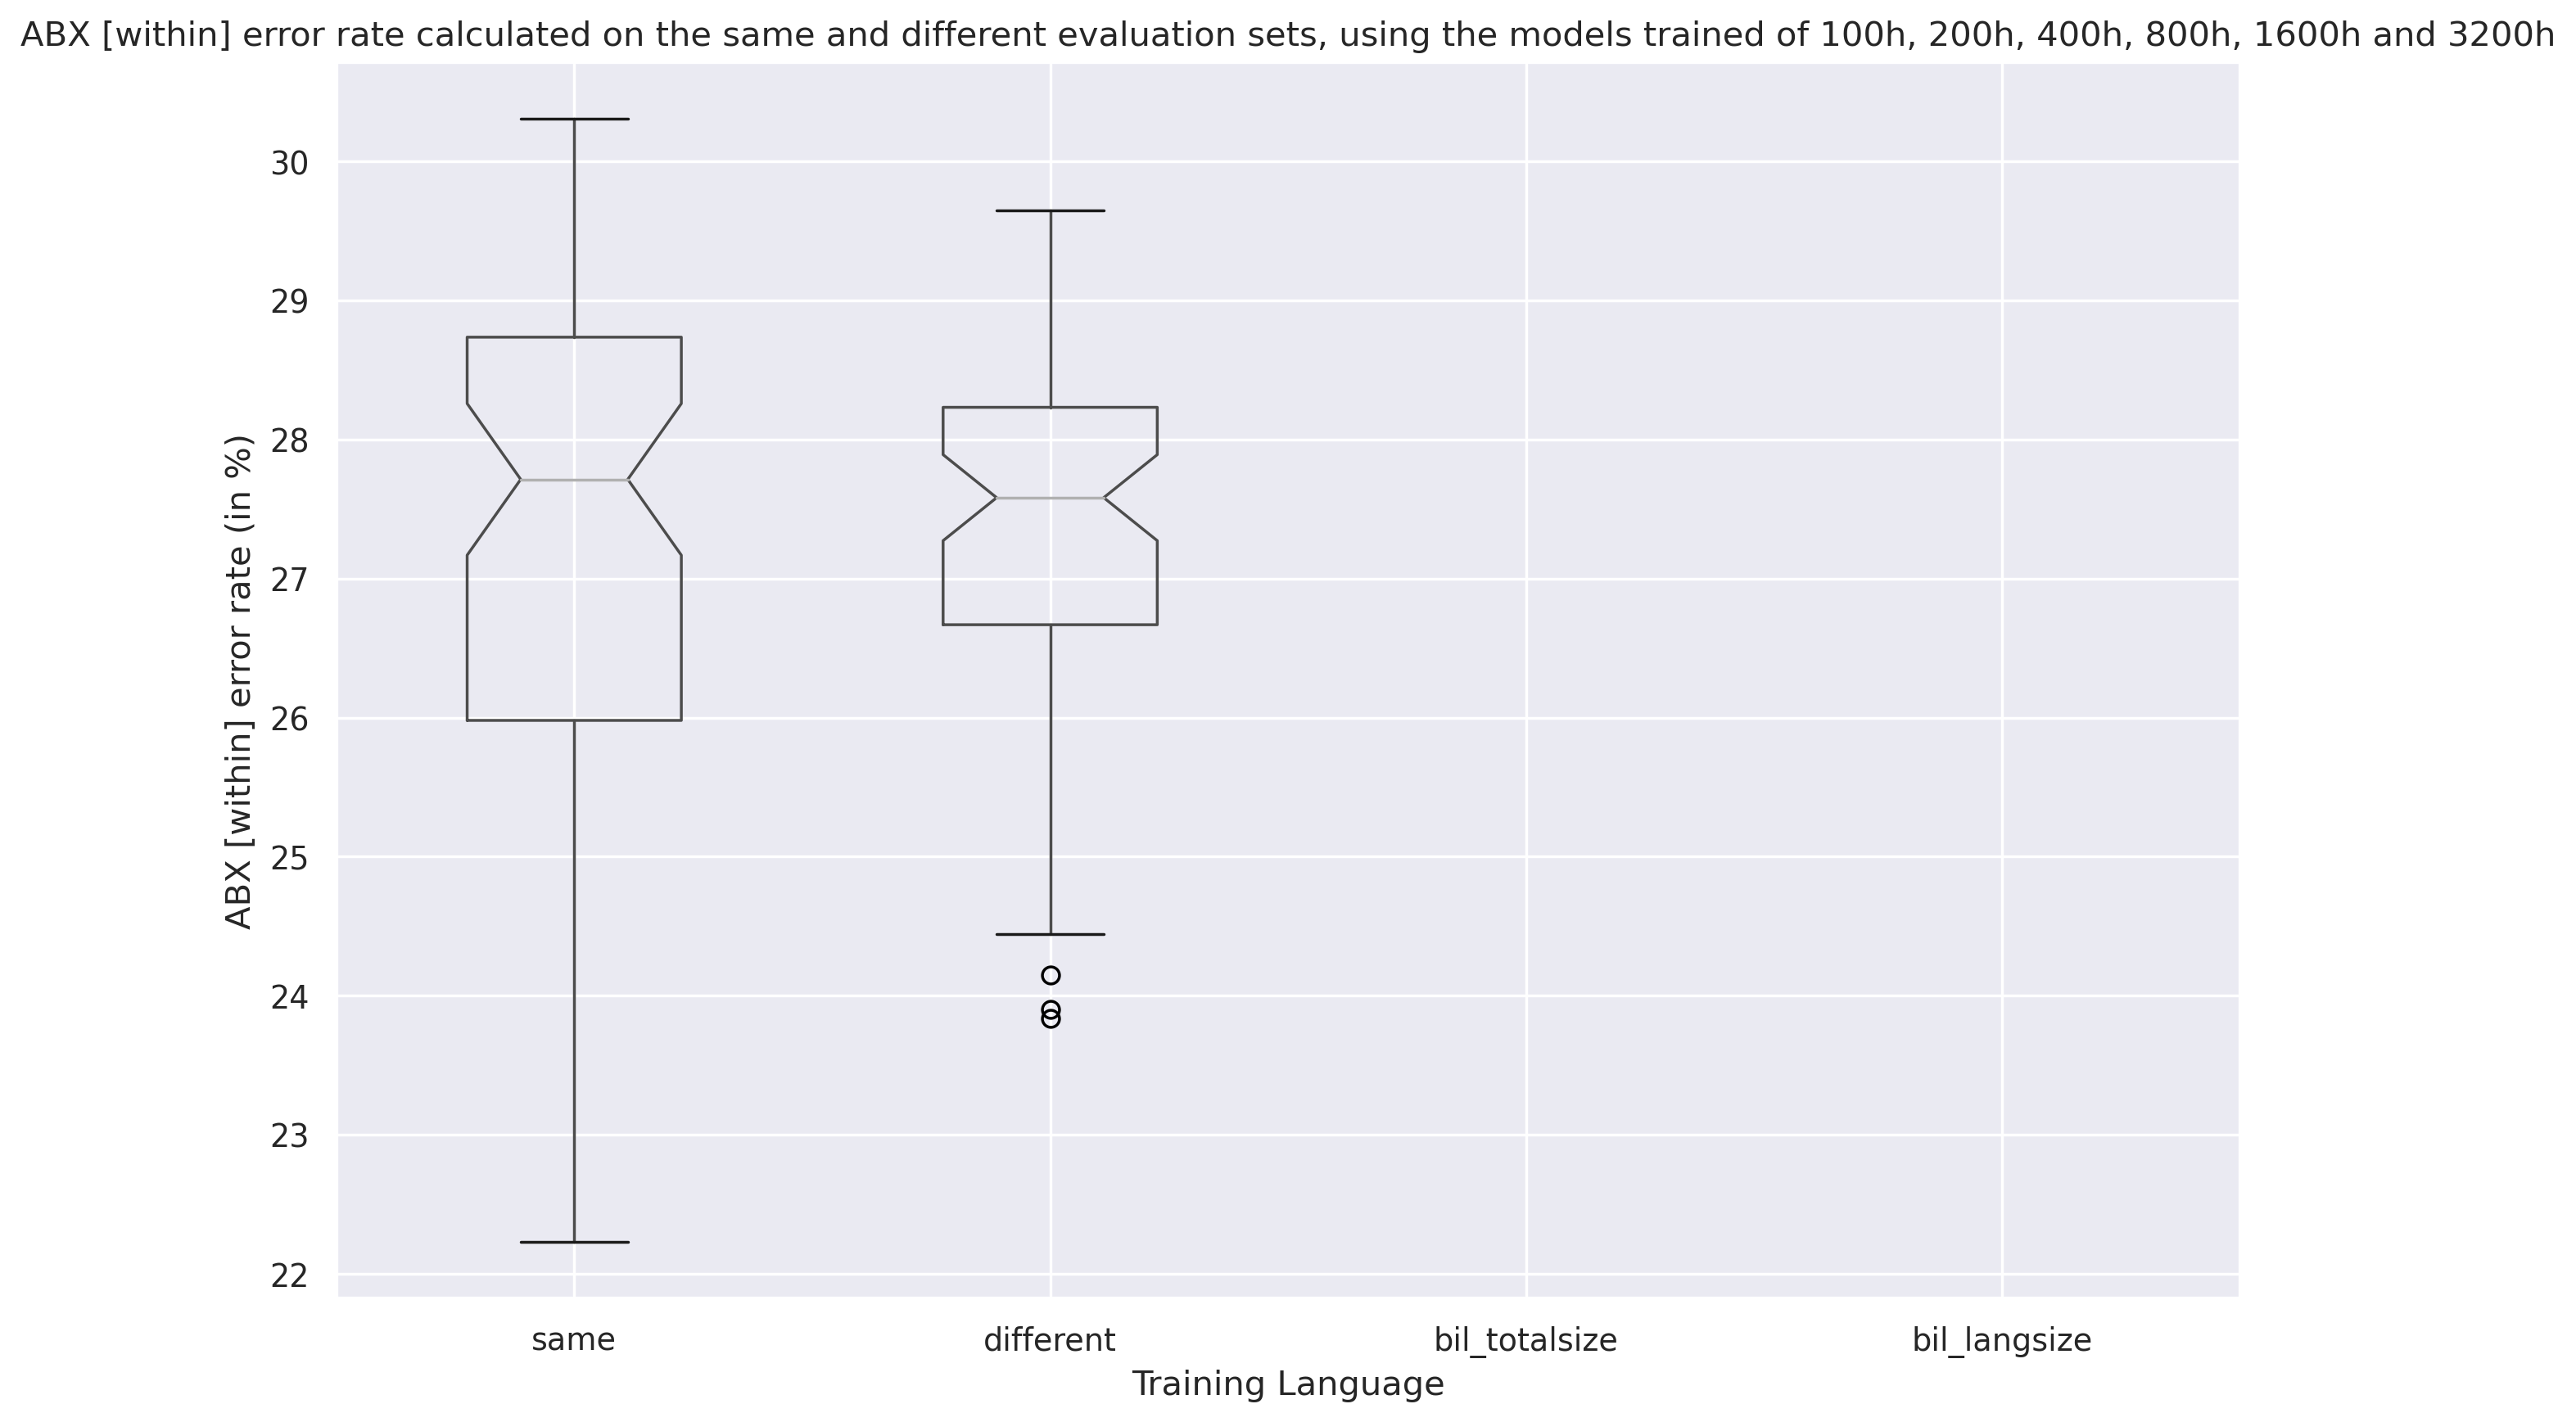

In [10]:
boxplot = df_within[['same', 'different', 'bil_totalsize','bil_langsize','eval_lang']][df_within["size"] > 50].boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the same and different evaluation sets, using the models trained of 100h, 200h, 400h, 800h, 1600h and 3200h')



### C2. Monolingual vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')

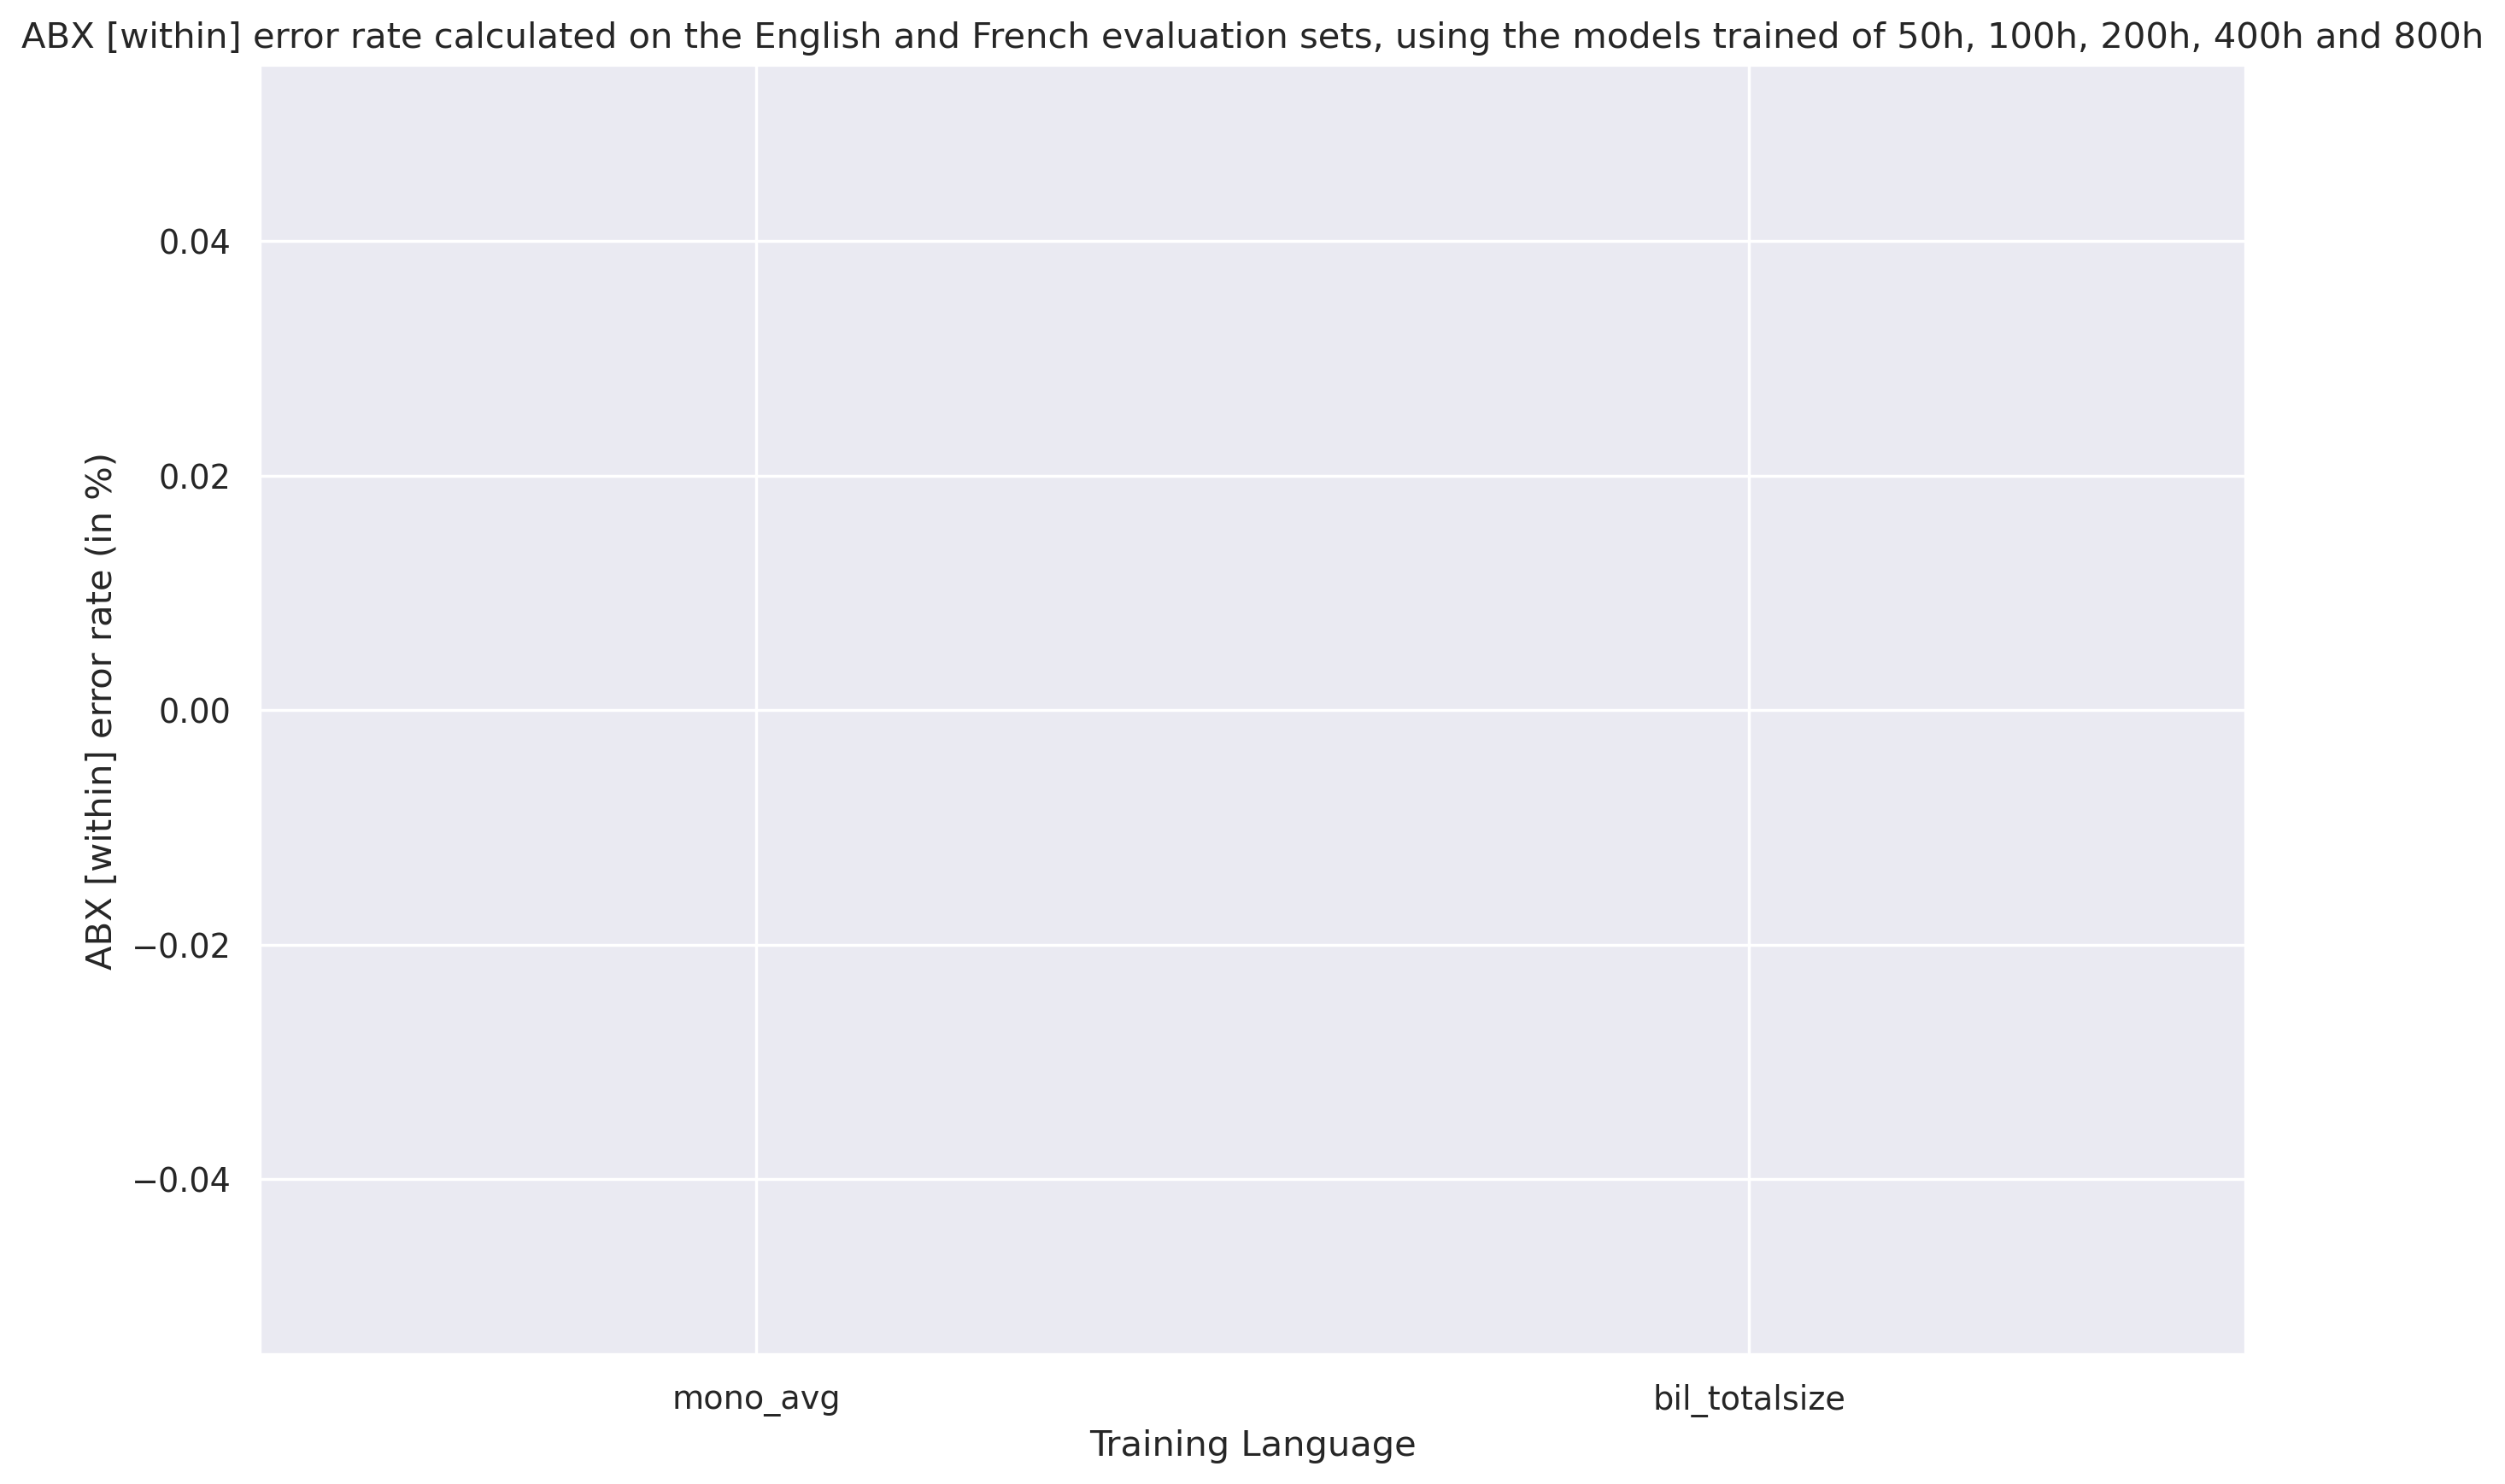

In [11]:
boxplot = df_within[['mono_avg', 'bil_totalsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')



### C3. Monolingual vs Bilingual LangSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the largest dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')

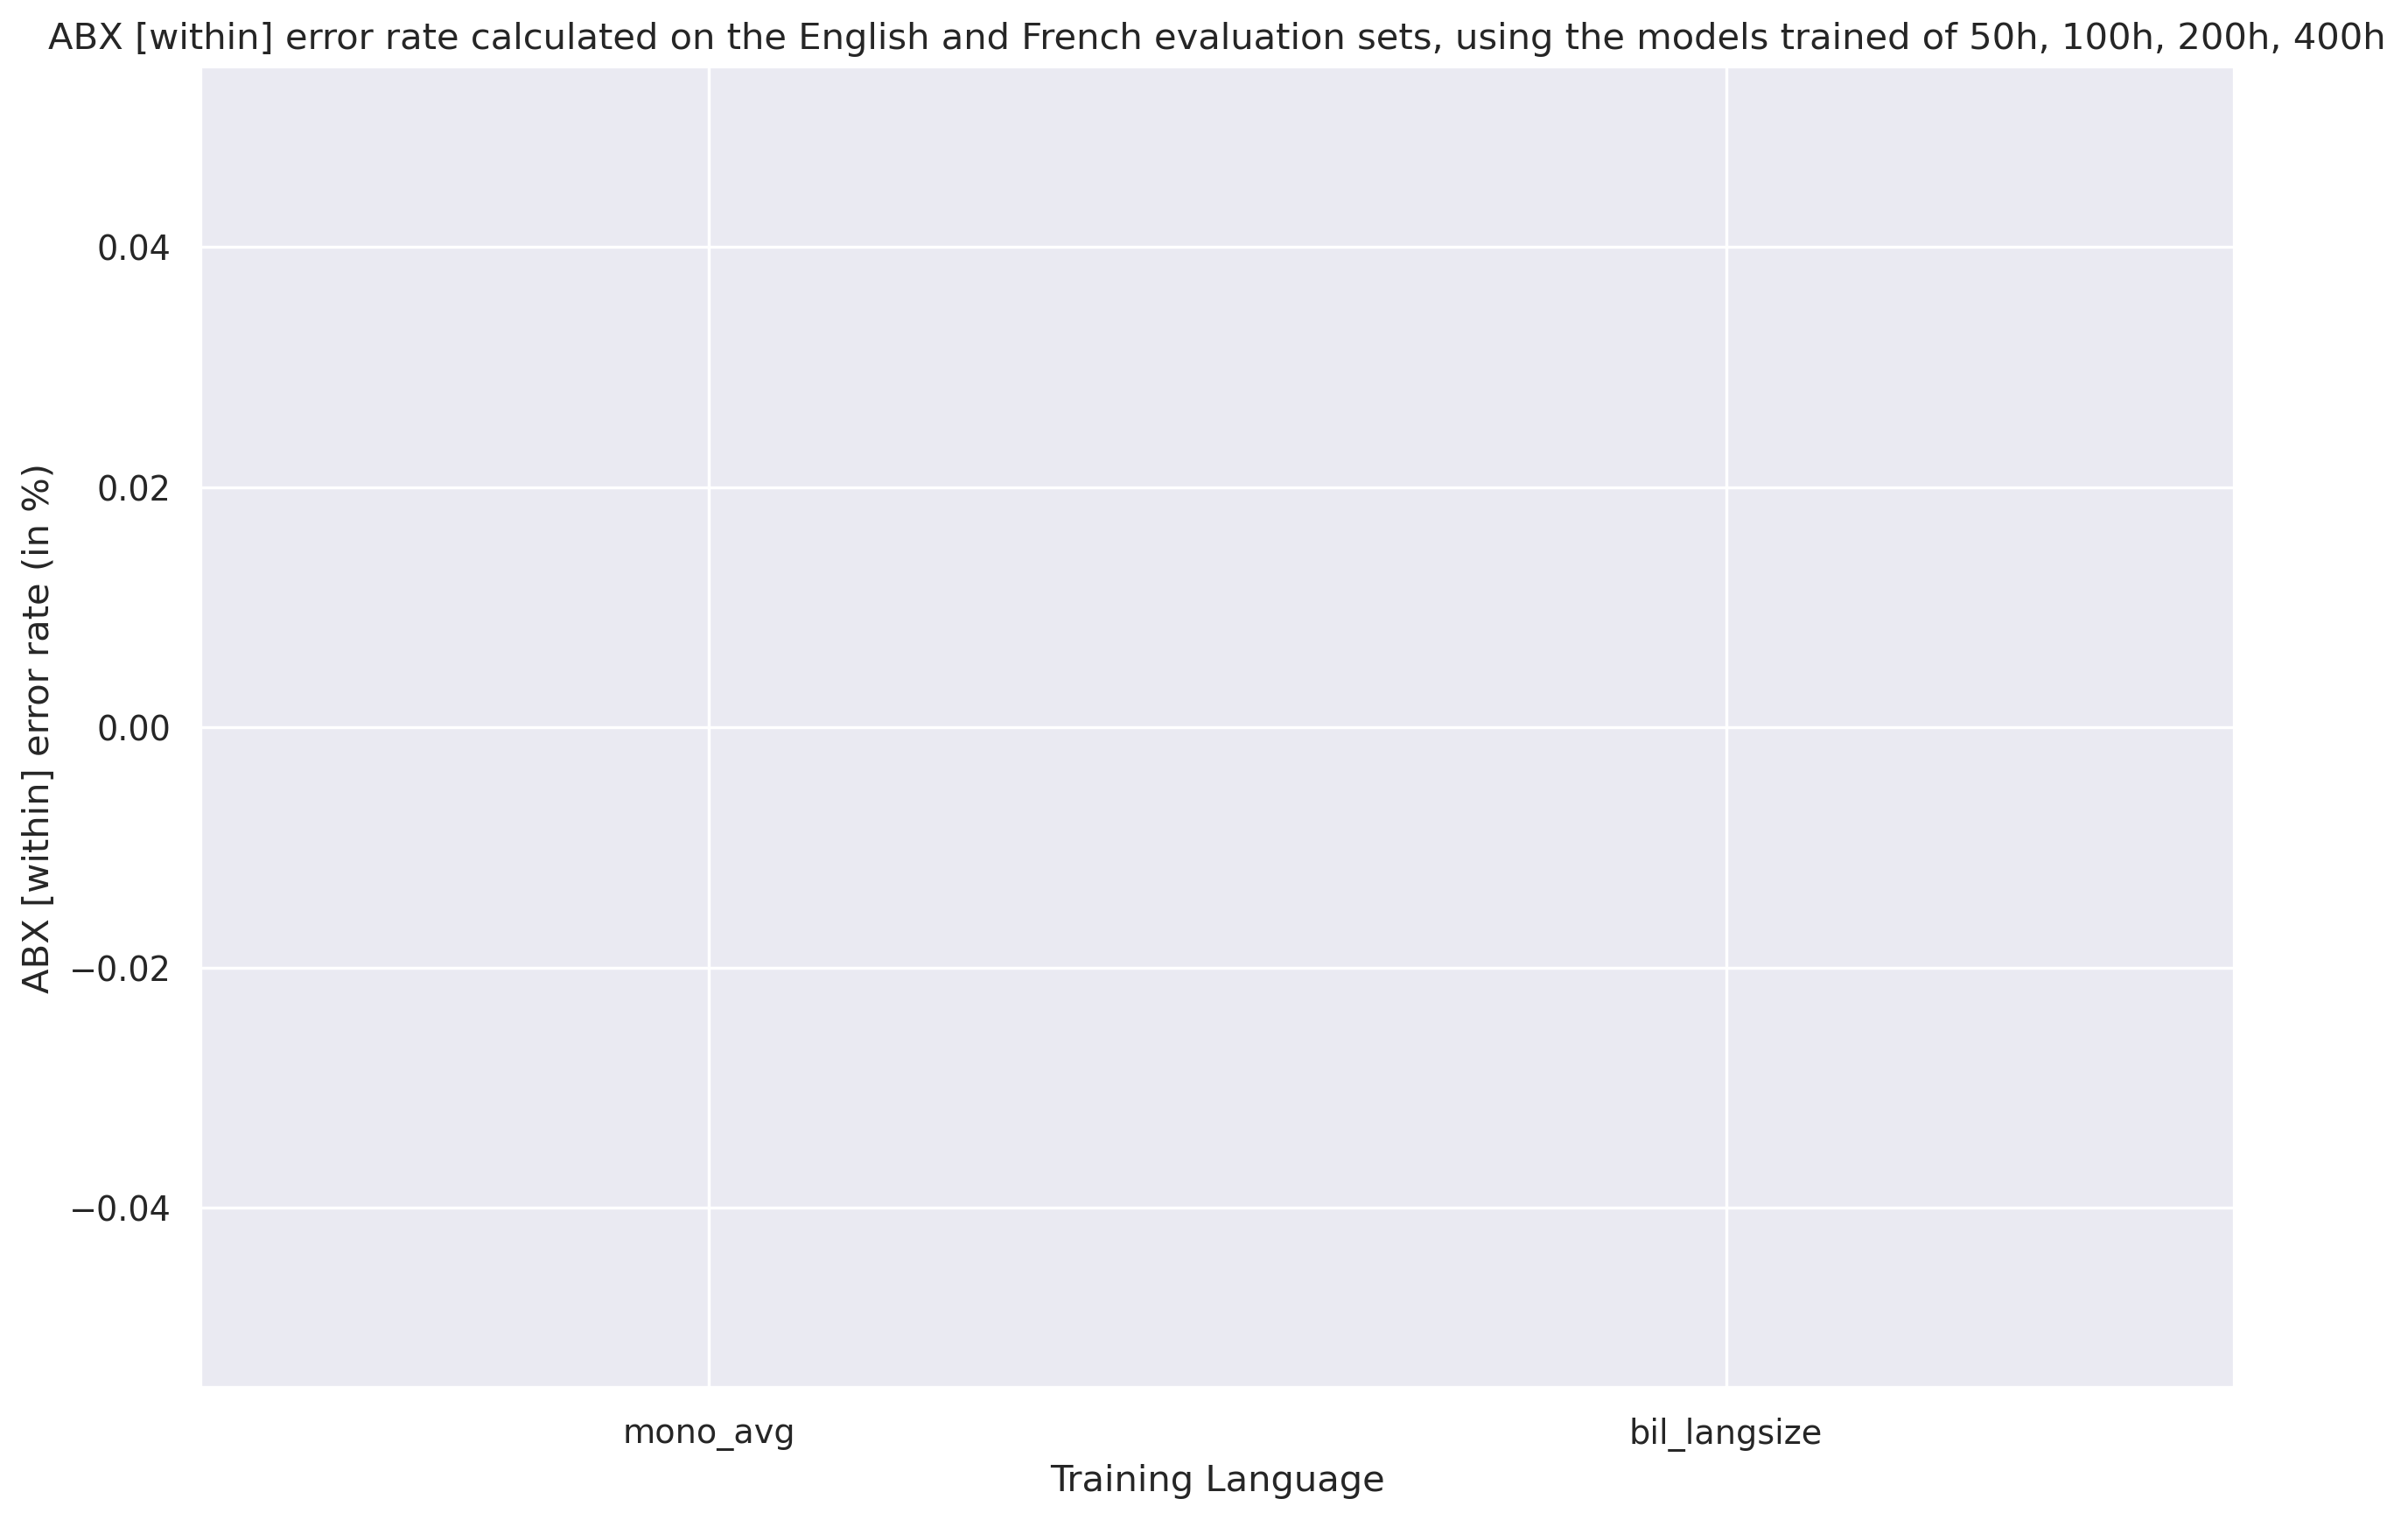

In [12]:
boxplot = df_within[['mono_avg', 'bil_langsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')



## D. Developmental graphs

In [13]:
style_dict =  {'same': 'go-', 'different': 'ro-', 'bil_totalsize': 'bo:', 'bil_langsize':'co:', 'en_model' : 'go--', 'fr_model' : 'ro--', 'mono_avg':'wo-.'}


### D1. Developmental [within] ABX  on both test sets (original)

Text(0.5, 1.0, 'ABX [within] error rate depending on the model type and number of training hours on the UU-OU contrast')

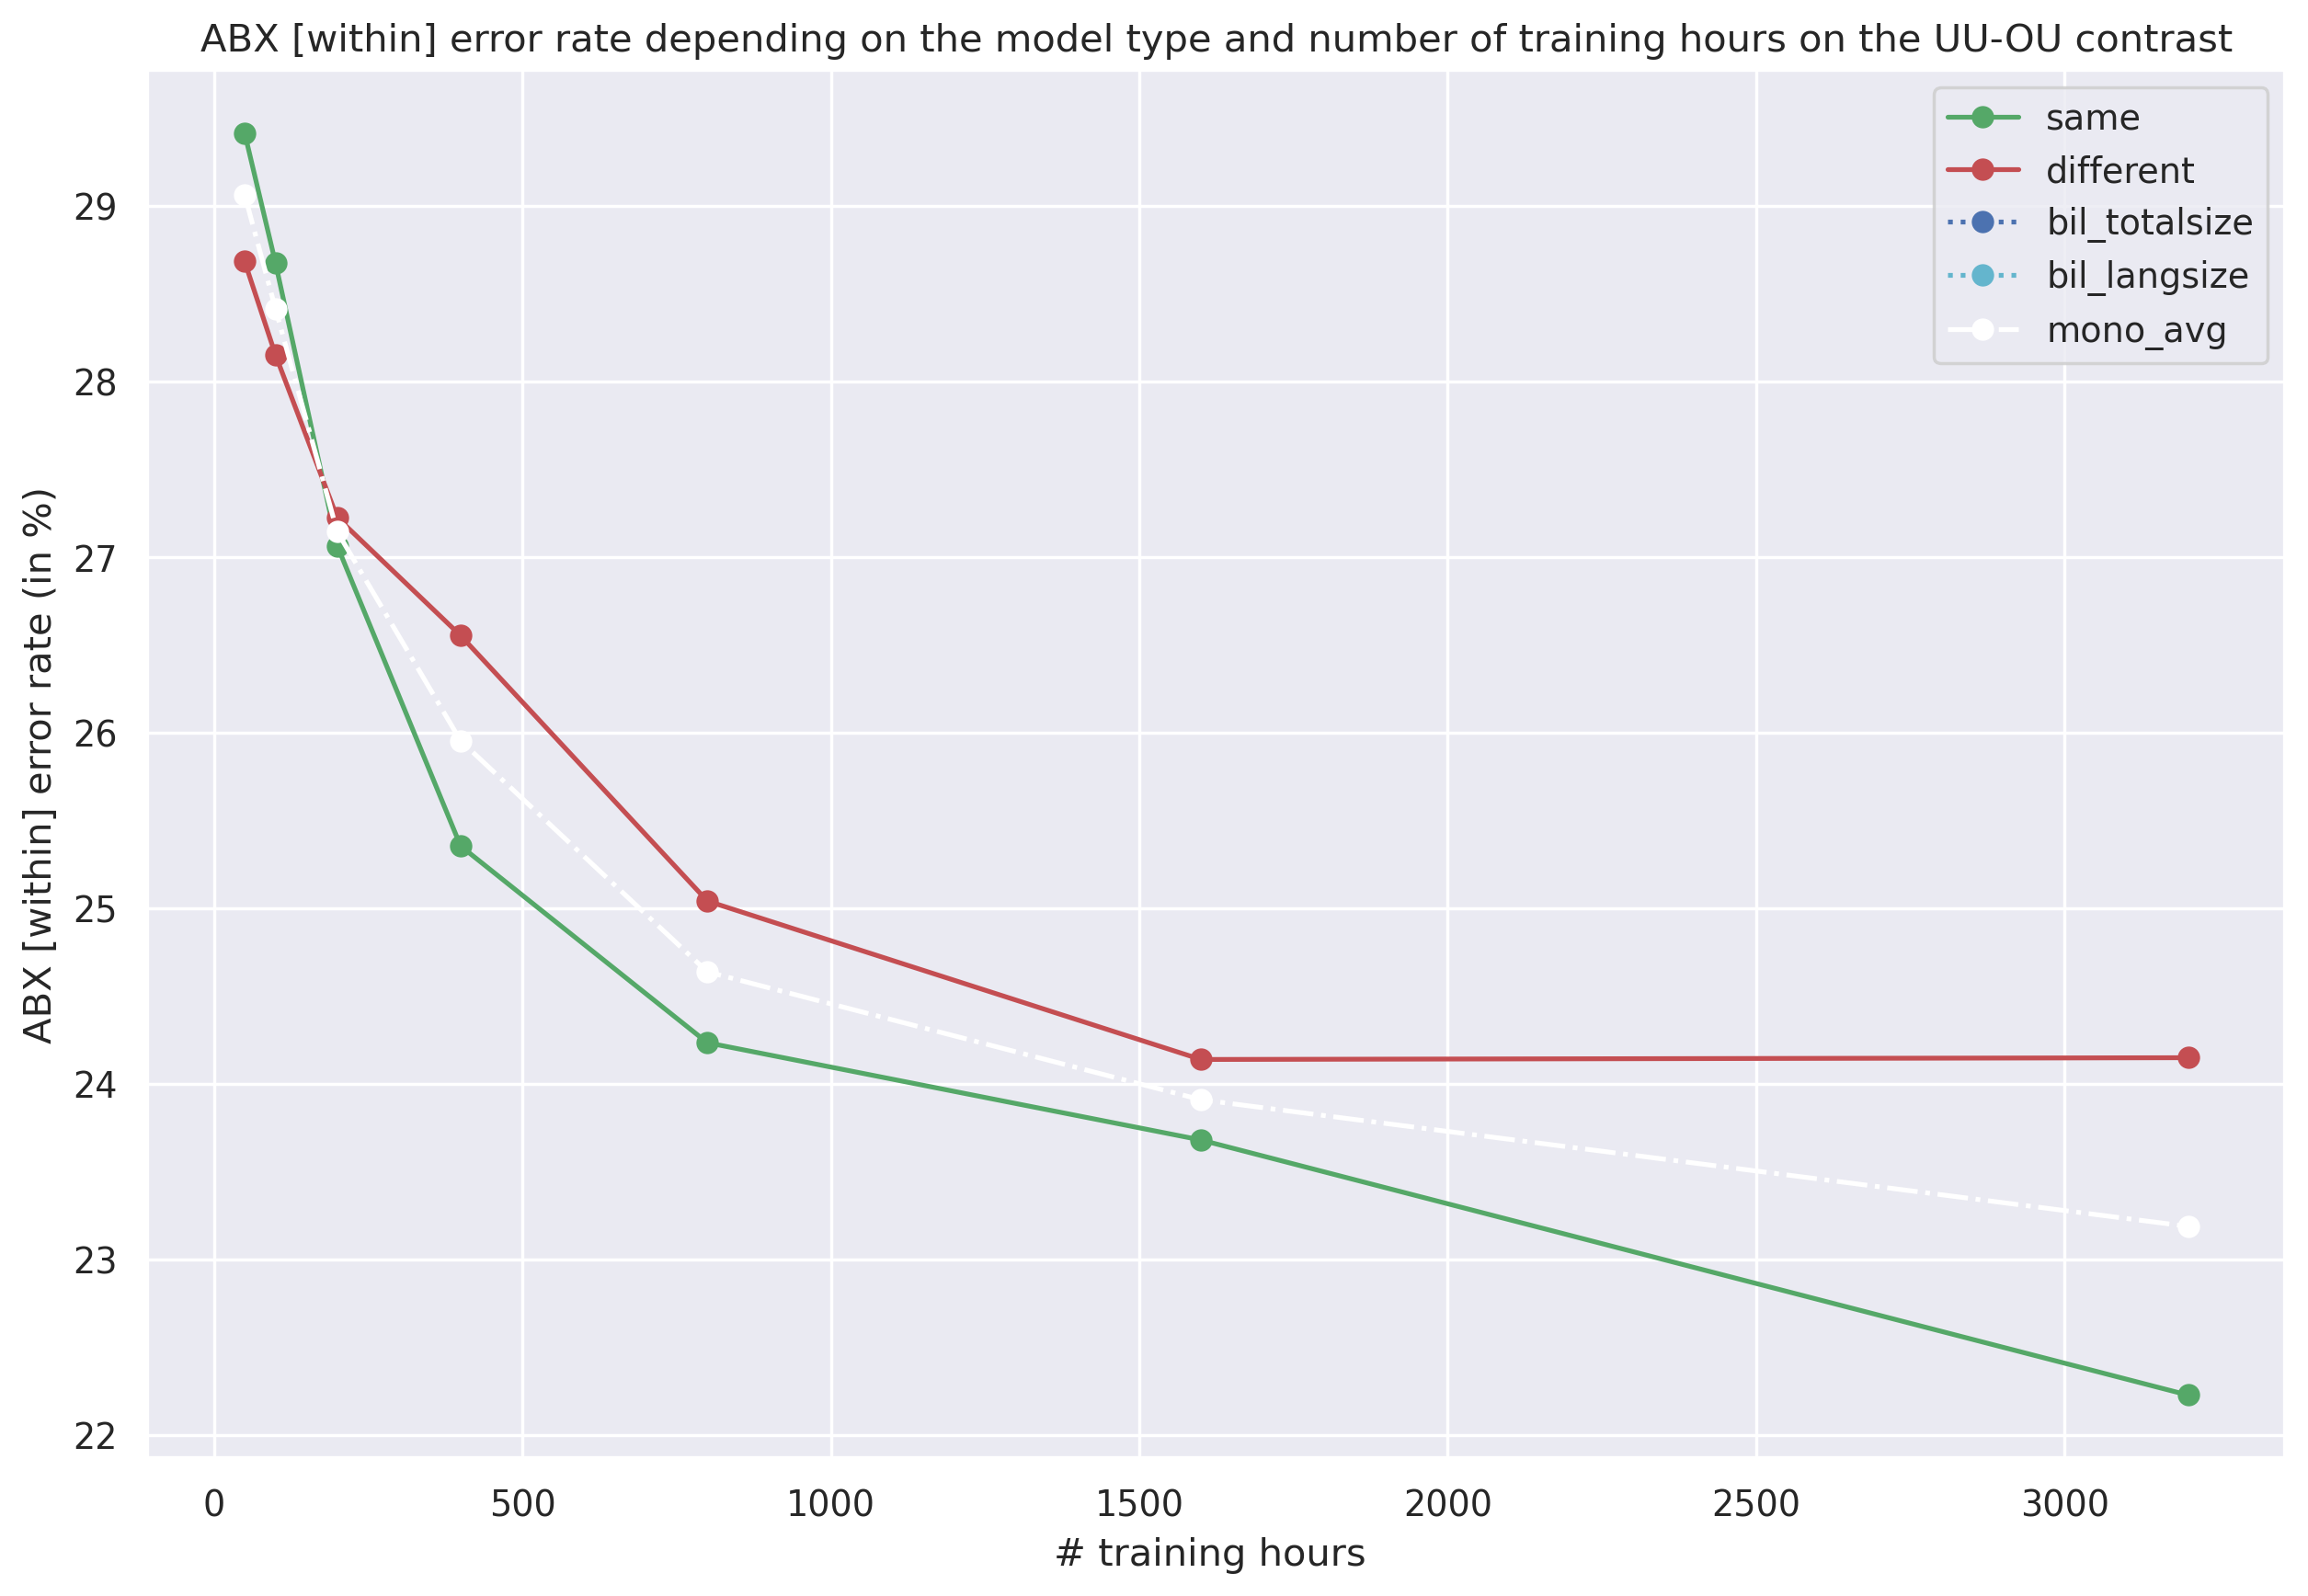

In [14]:
df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
#df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, yerr=err_within[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']])

#df_within_size[['same', 'different']].plot(style = style_dict)

plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %)")
plt.title("ABX [within] error rate depending on the model type and number of training hours on the UU-OU contrast")


Text(0.5, 1.0, 'ABX [across] error rate depending on the model type and number of training hours on the UU-OU contrast')

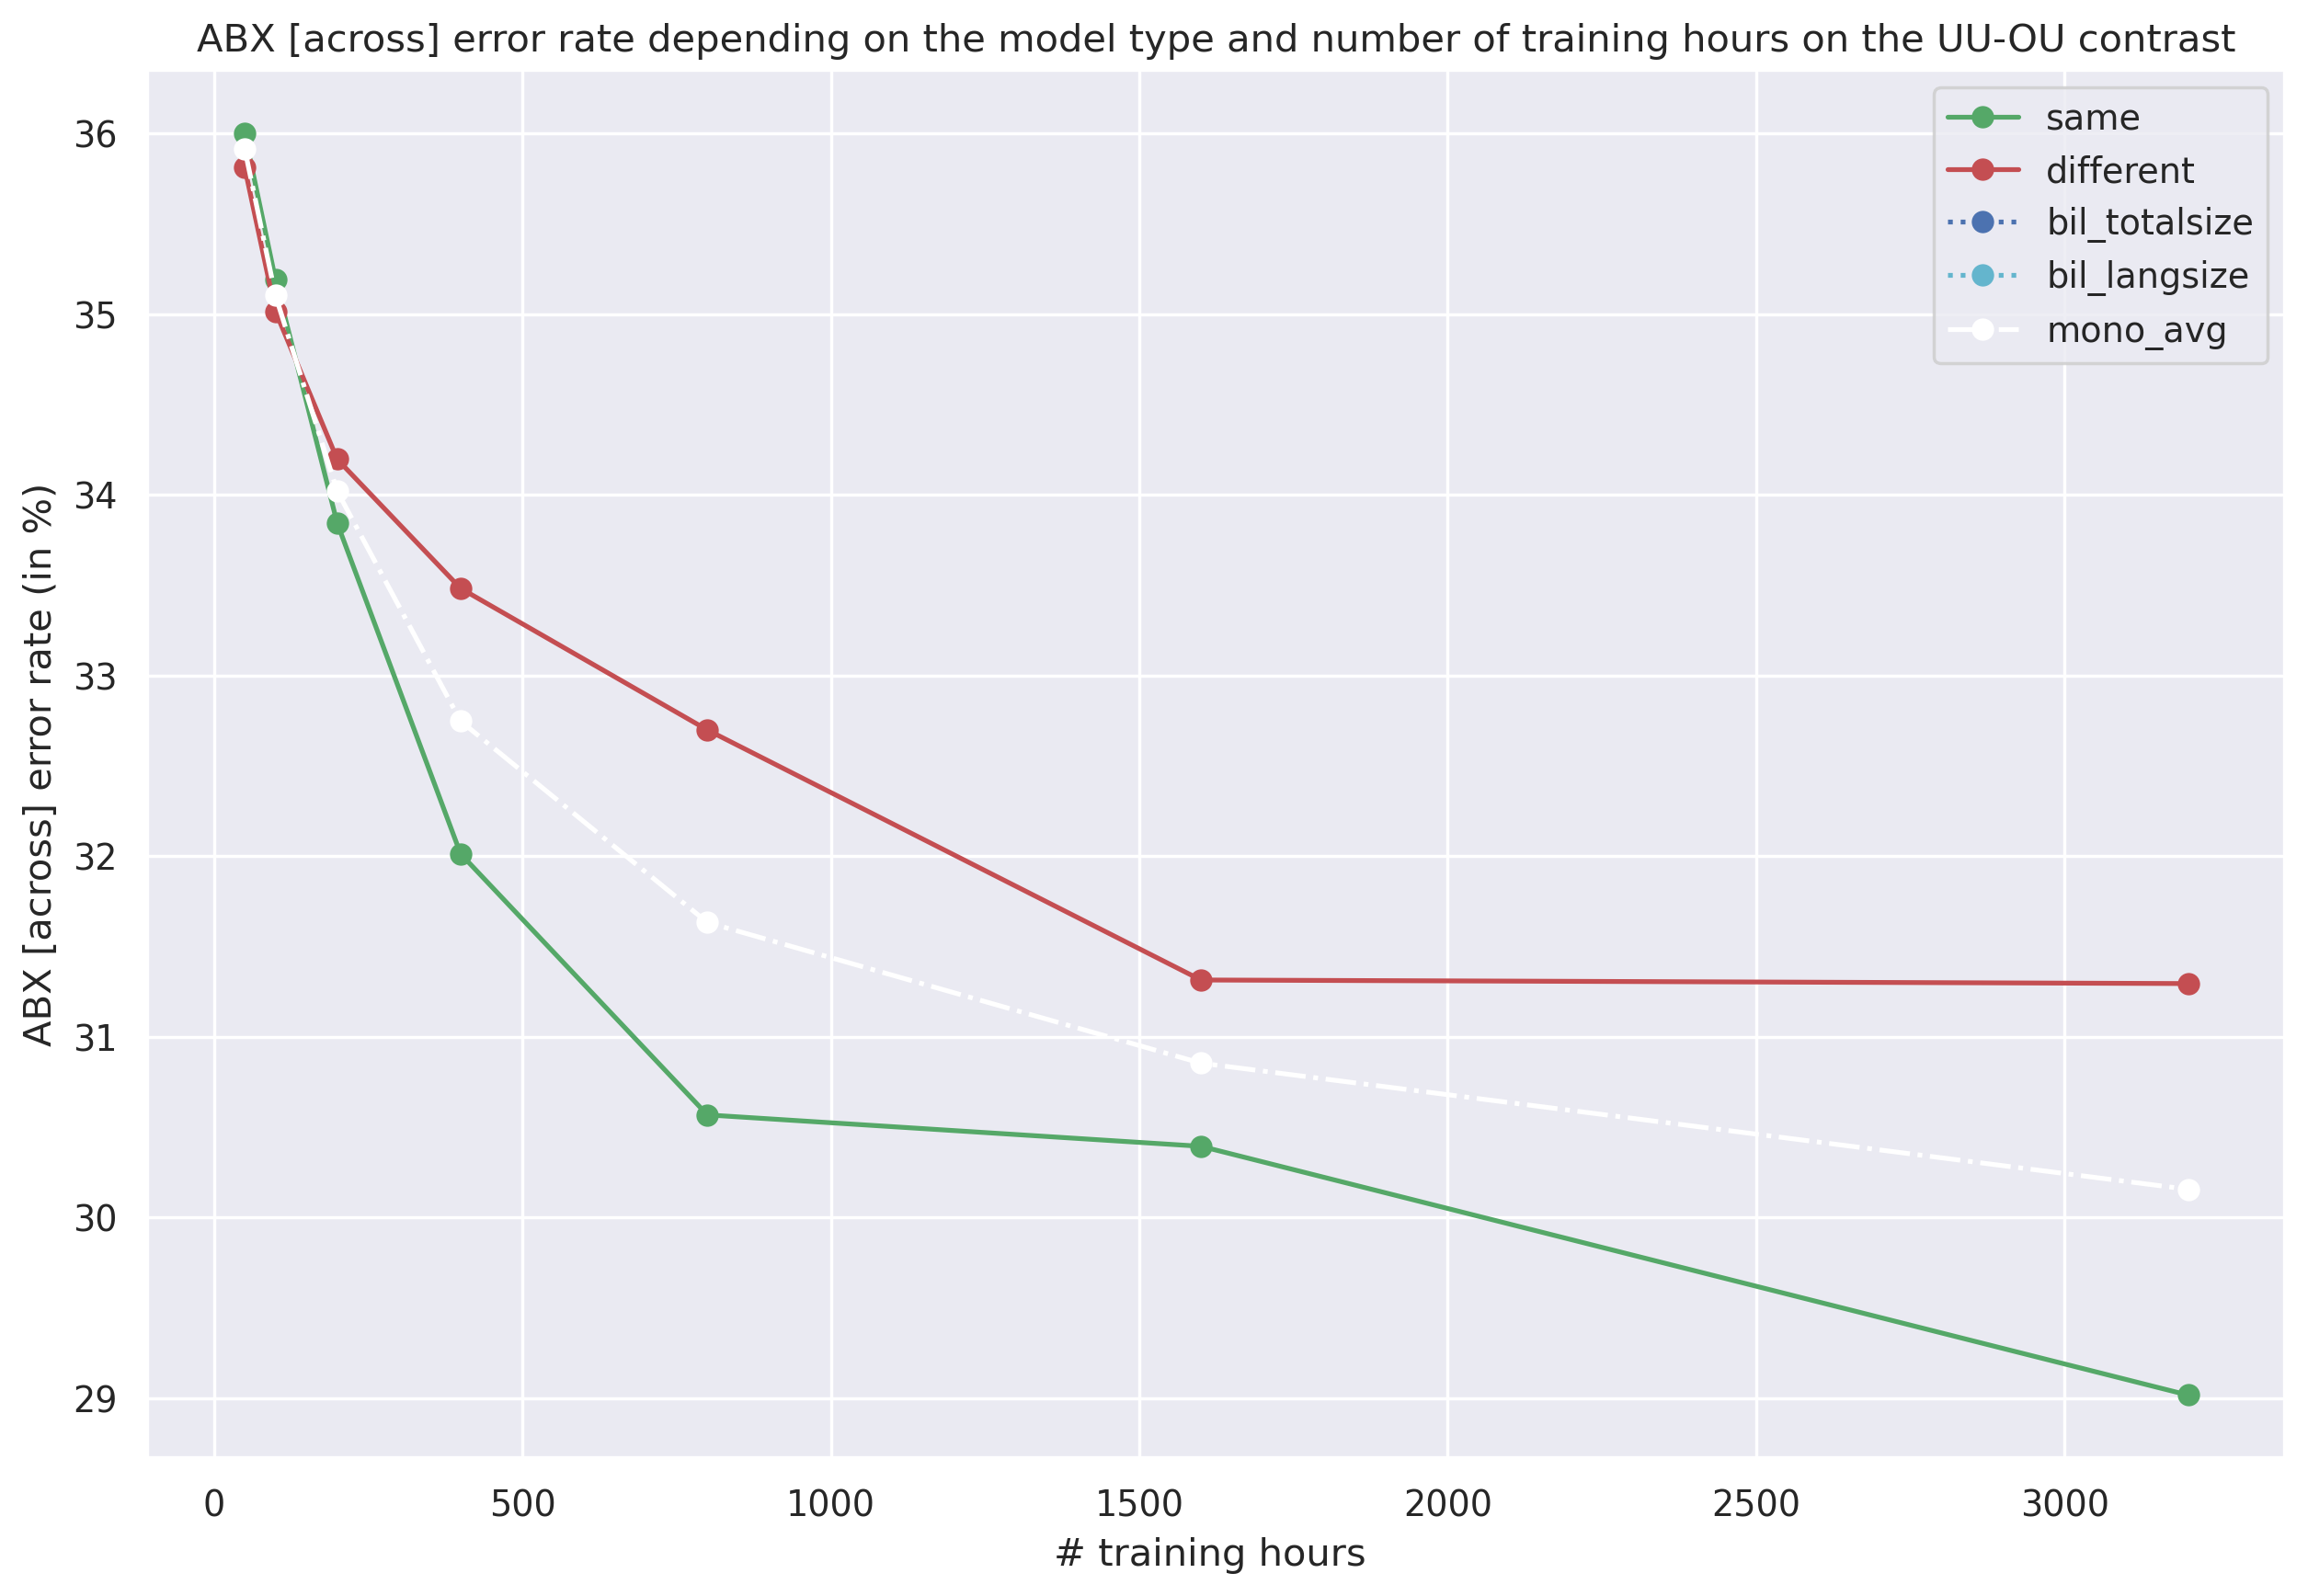

In [15]:
df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
#df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, yerr=err_within[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']])

#df_within_size[['same', 'different']].plot(style = style_dict)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %)")
plt.title("ABX [across] error rate depending on the model type and number of training hours on the UU-OU contrast")


In [16]:
err_within[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']]

,same,different,bil_totalsize,bil_langsize,mono_avg
size,,,,,
50,1.247654,1.209350,NaN,NaN,0.870275
100,0.961044,0.881569,NaN,NaN,0.539870
200,0.883075,0.845279,NaN,NaN,0.605001
400,0.682024,0.873735,NaN,NaN,0.337733
800,0.504142,0.769393,NaN,NaN,0.547074
1600,0.086518,0.428307,NaN,NaN,0.257412
3200,NaN,NaN,NaN,NaN,NaN


In [17]:
df_within.groupby('size').std()


,en_model,fr_model,bil_totalsize_A,bil_totalsize_B,same,different,bil_langsize,bil_totalsize,mono_avg
size,,,,,,,,,
50,1.209350,1.247654,NaN,NaN,1.247654,1.209350,NaN,NaN,0.870275
100,0.881569,0.961044,NaN,NaN,0.961044,0.881569,NaN,NaN,0.539870
200,0.845279,0.883075,NaN,NaN,0.883075,0.845279,NaN,NaN,0.605001
400,0.873735,0.682024,NaN,NaN,0.682024,0.873735,NaN,NaN,0.337733
800,0.769393,0.504142,NaN,NaN,0.504142,0.769393,NaN,NaN,0.547074
1600,0.428307,0.086518,NaN,NaN,0.086518,0.428307,NaN,NaN,0.257412
3200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'ABX [within] error rate depending on the model type and number of training hours')

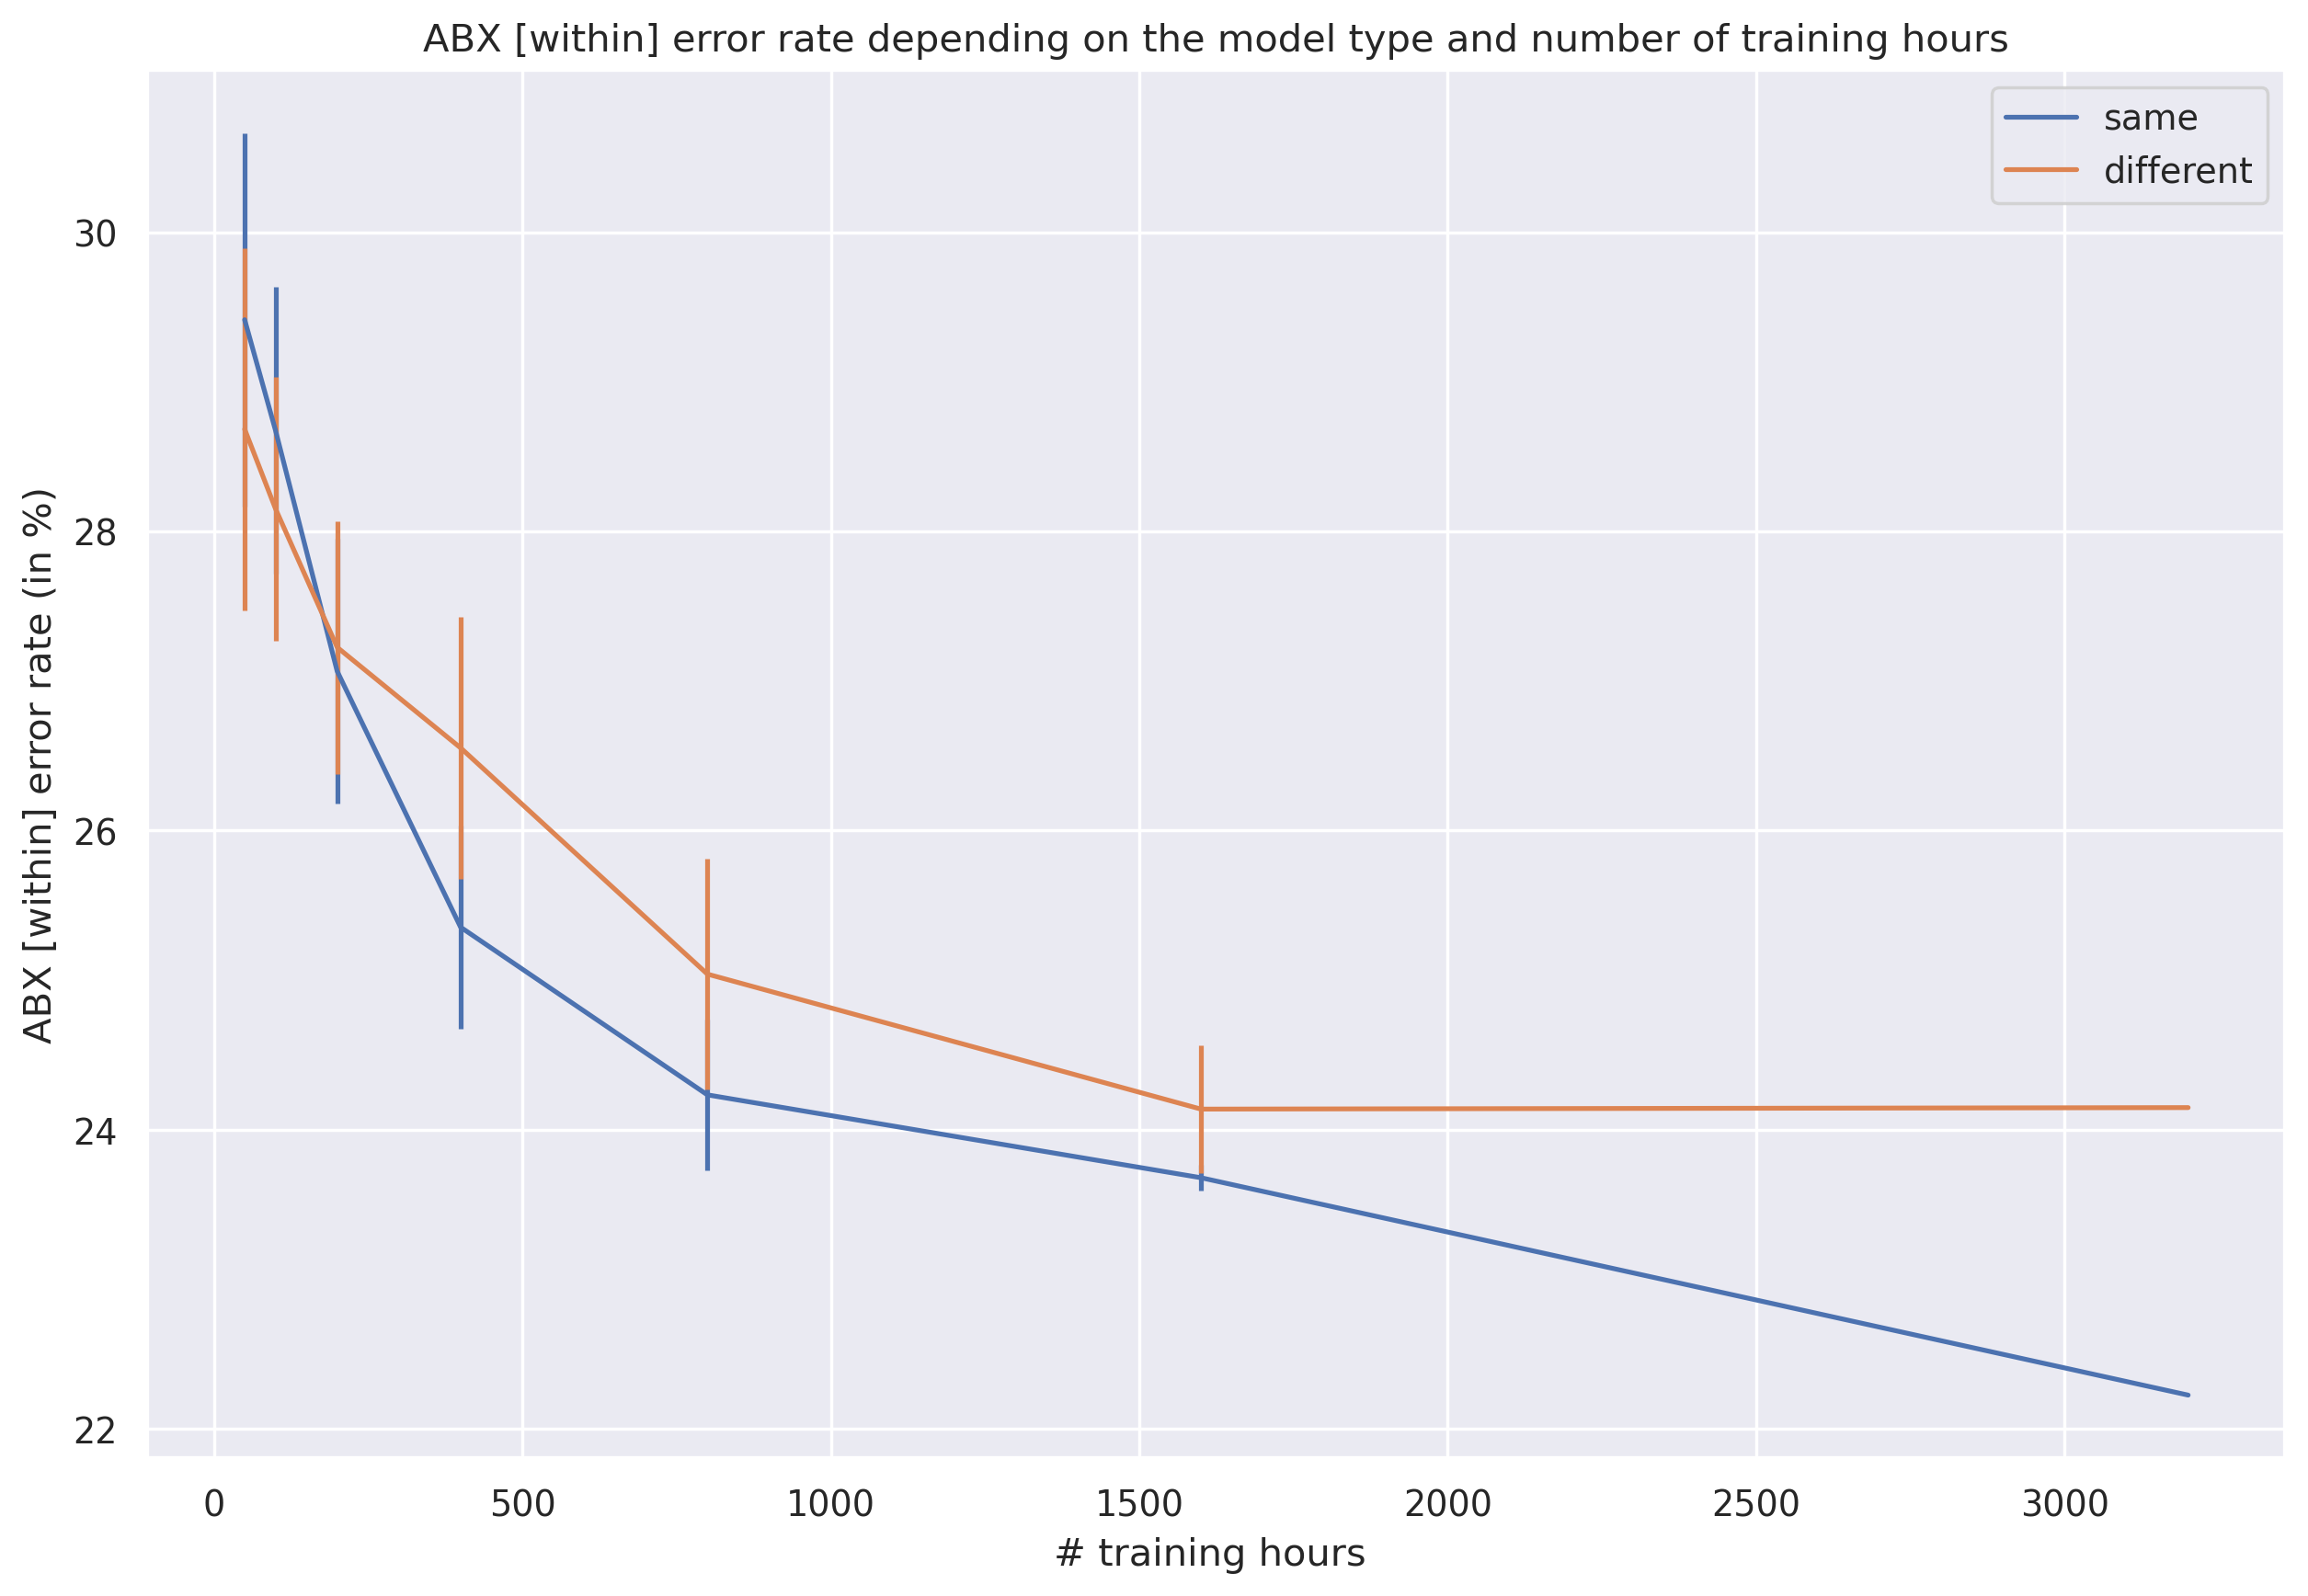

In [18]:
#doesn't work as this is not split by same vs different?

#df_within_size[['bil_totalsize']].plot(style = style_dict)
df_within_size[['same', 'different']].plot(style = style_dict, yerr=err_within[['same', 'different']])


plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %)")
plt.title("ABX [within] error rate depending on the model type and number of training hours")


(10, 21)

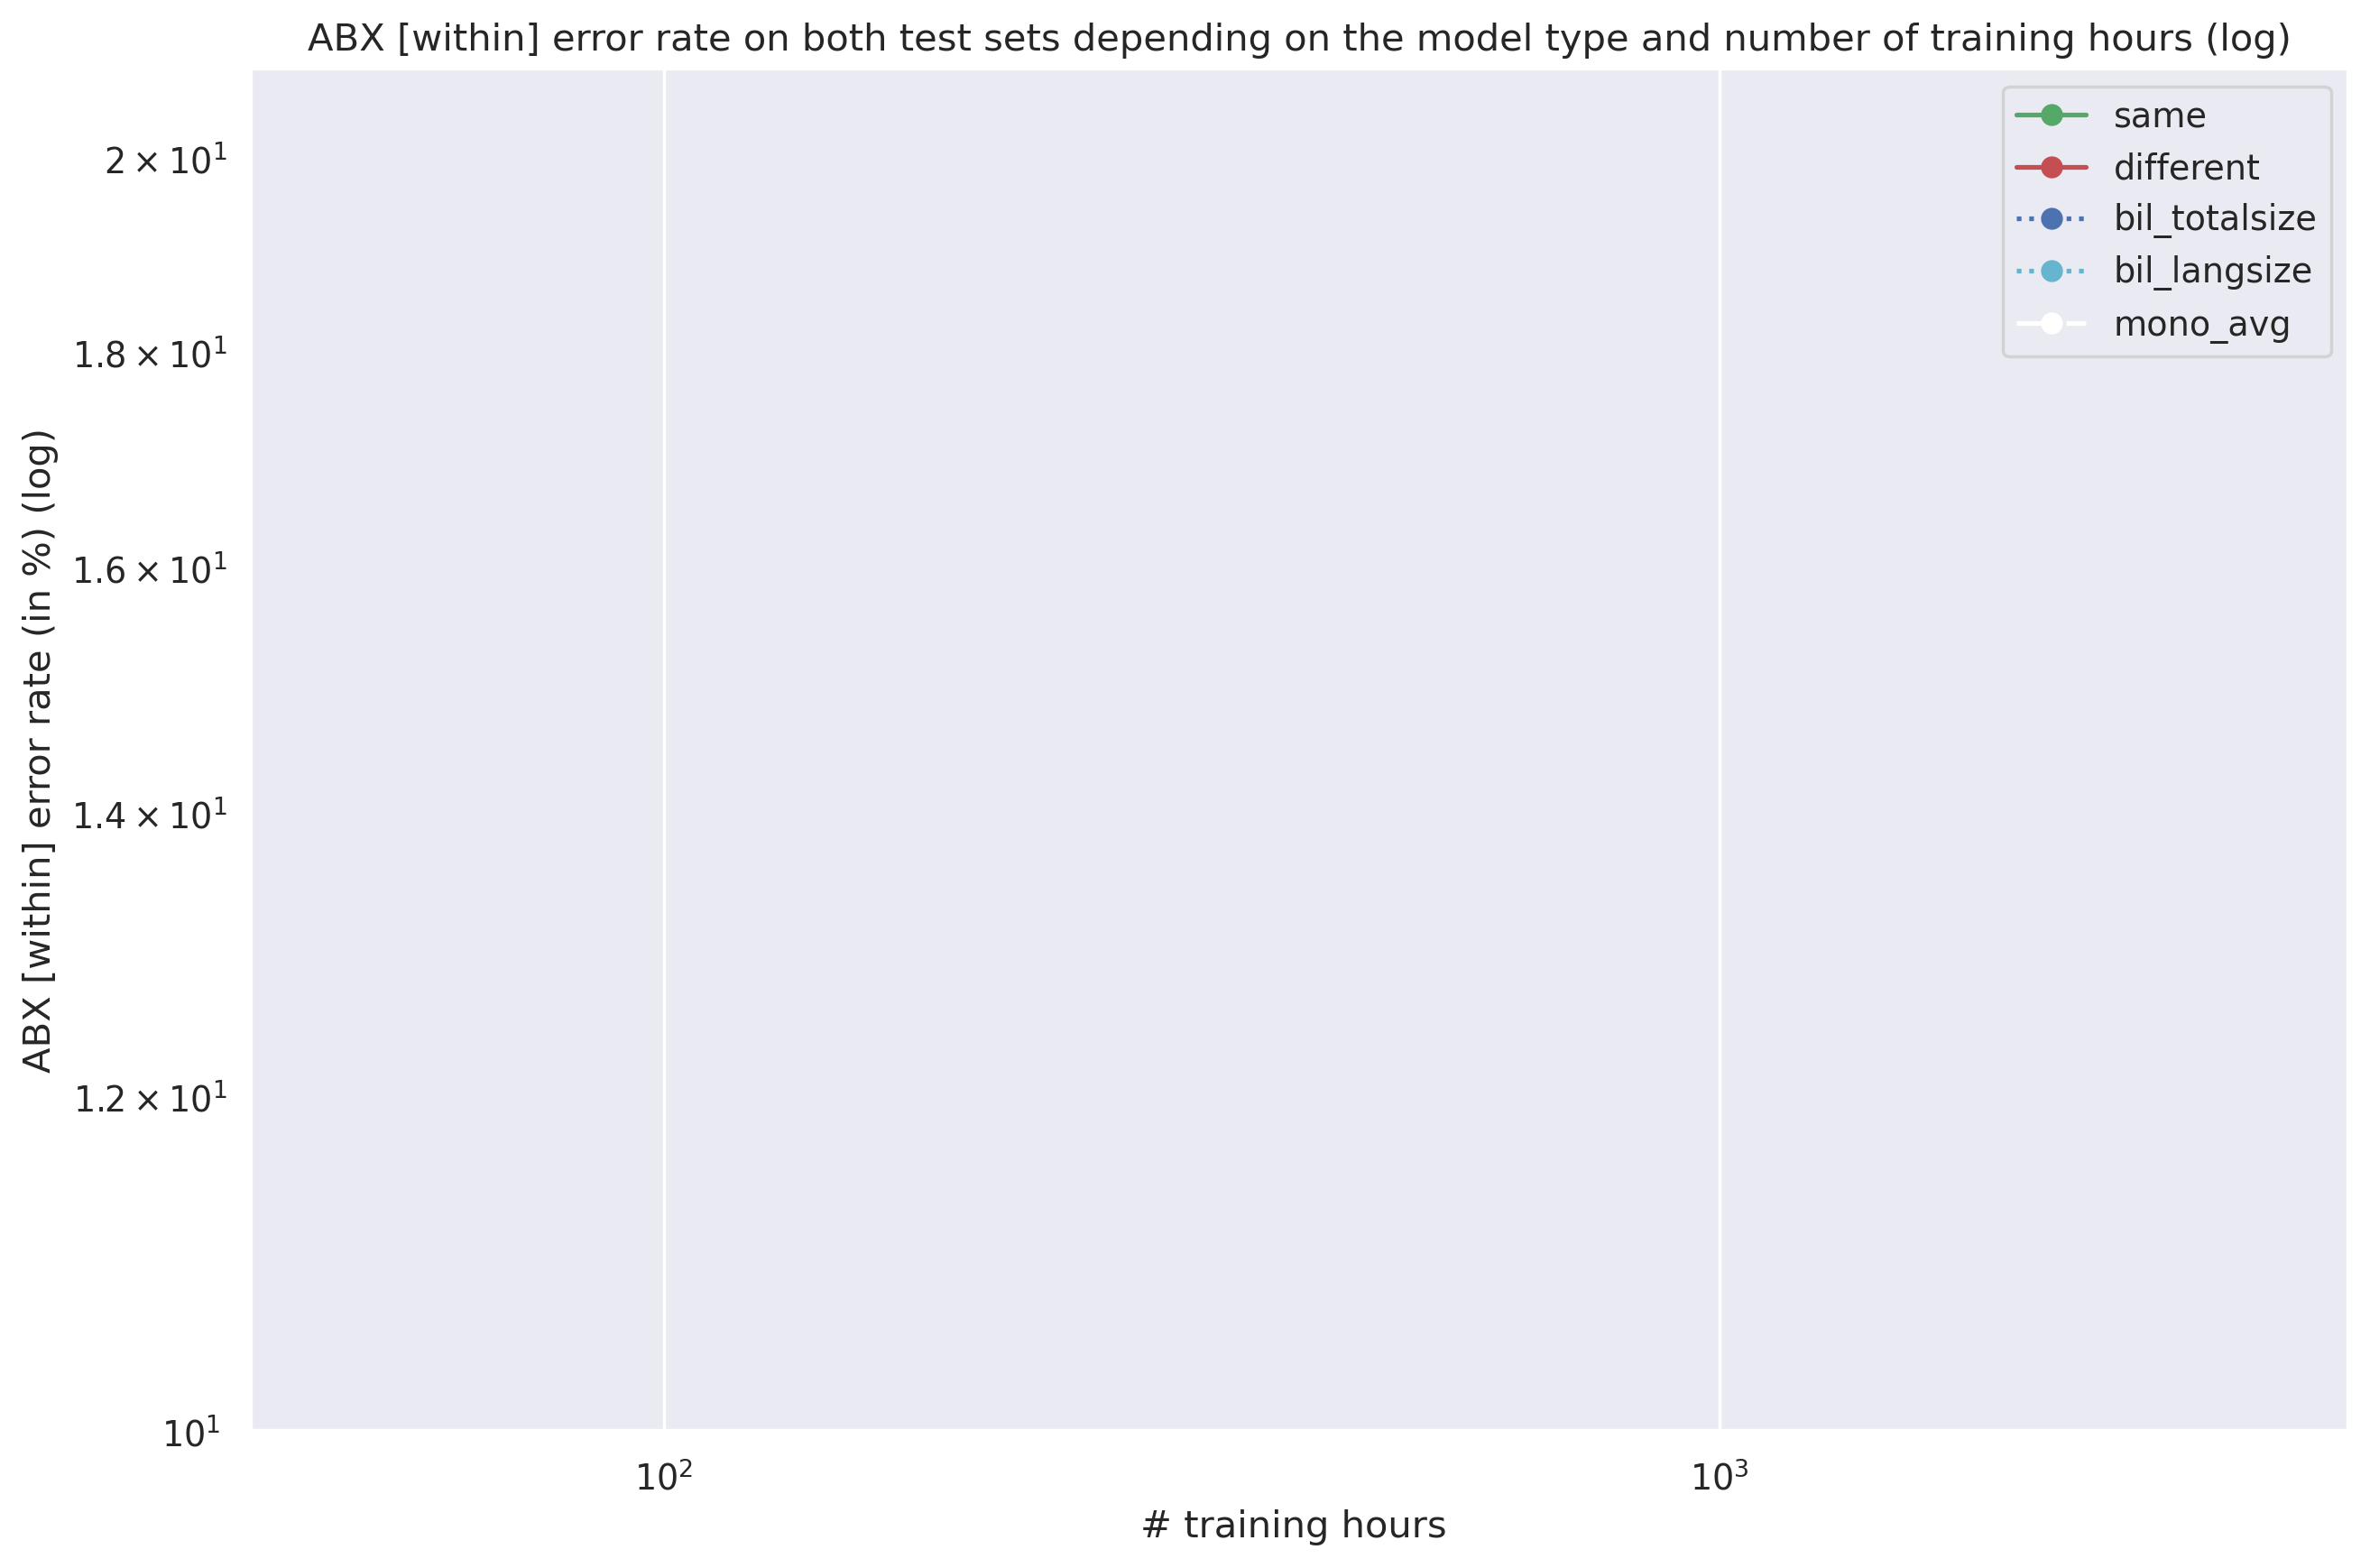

In [19]:
df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_within_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %) (log)")
plt.title("ABX [within] error rate on both test sets depending on the model type and number of training hours (log)")
plt.ylim([10,21])

(10, 21)

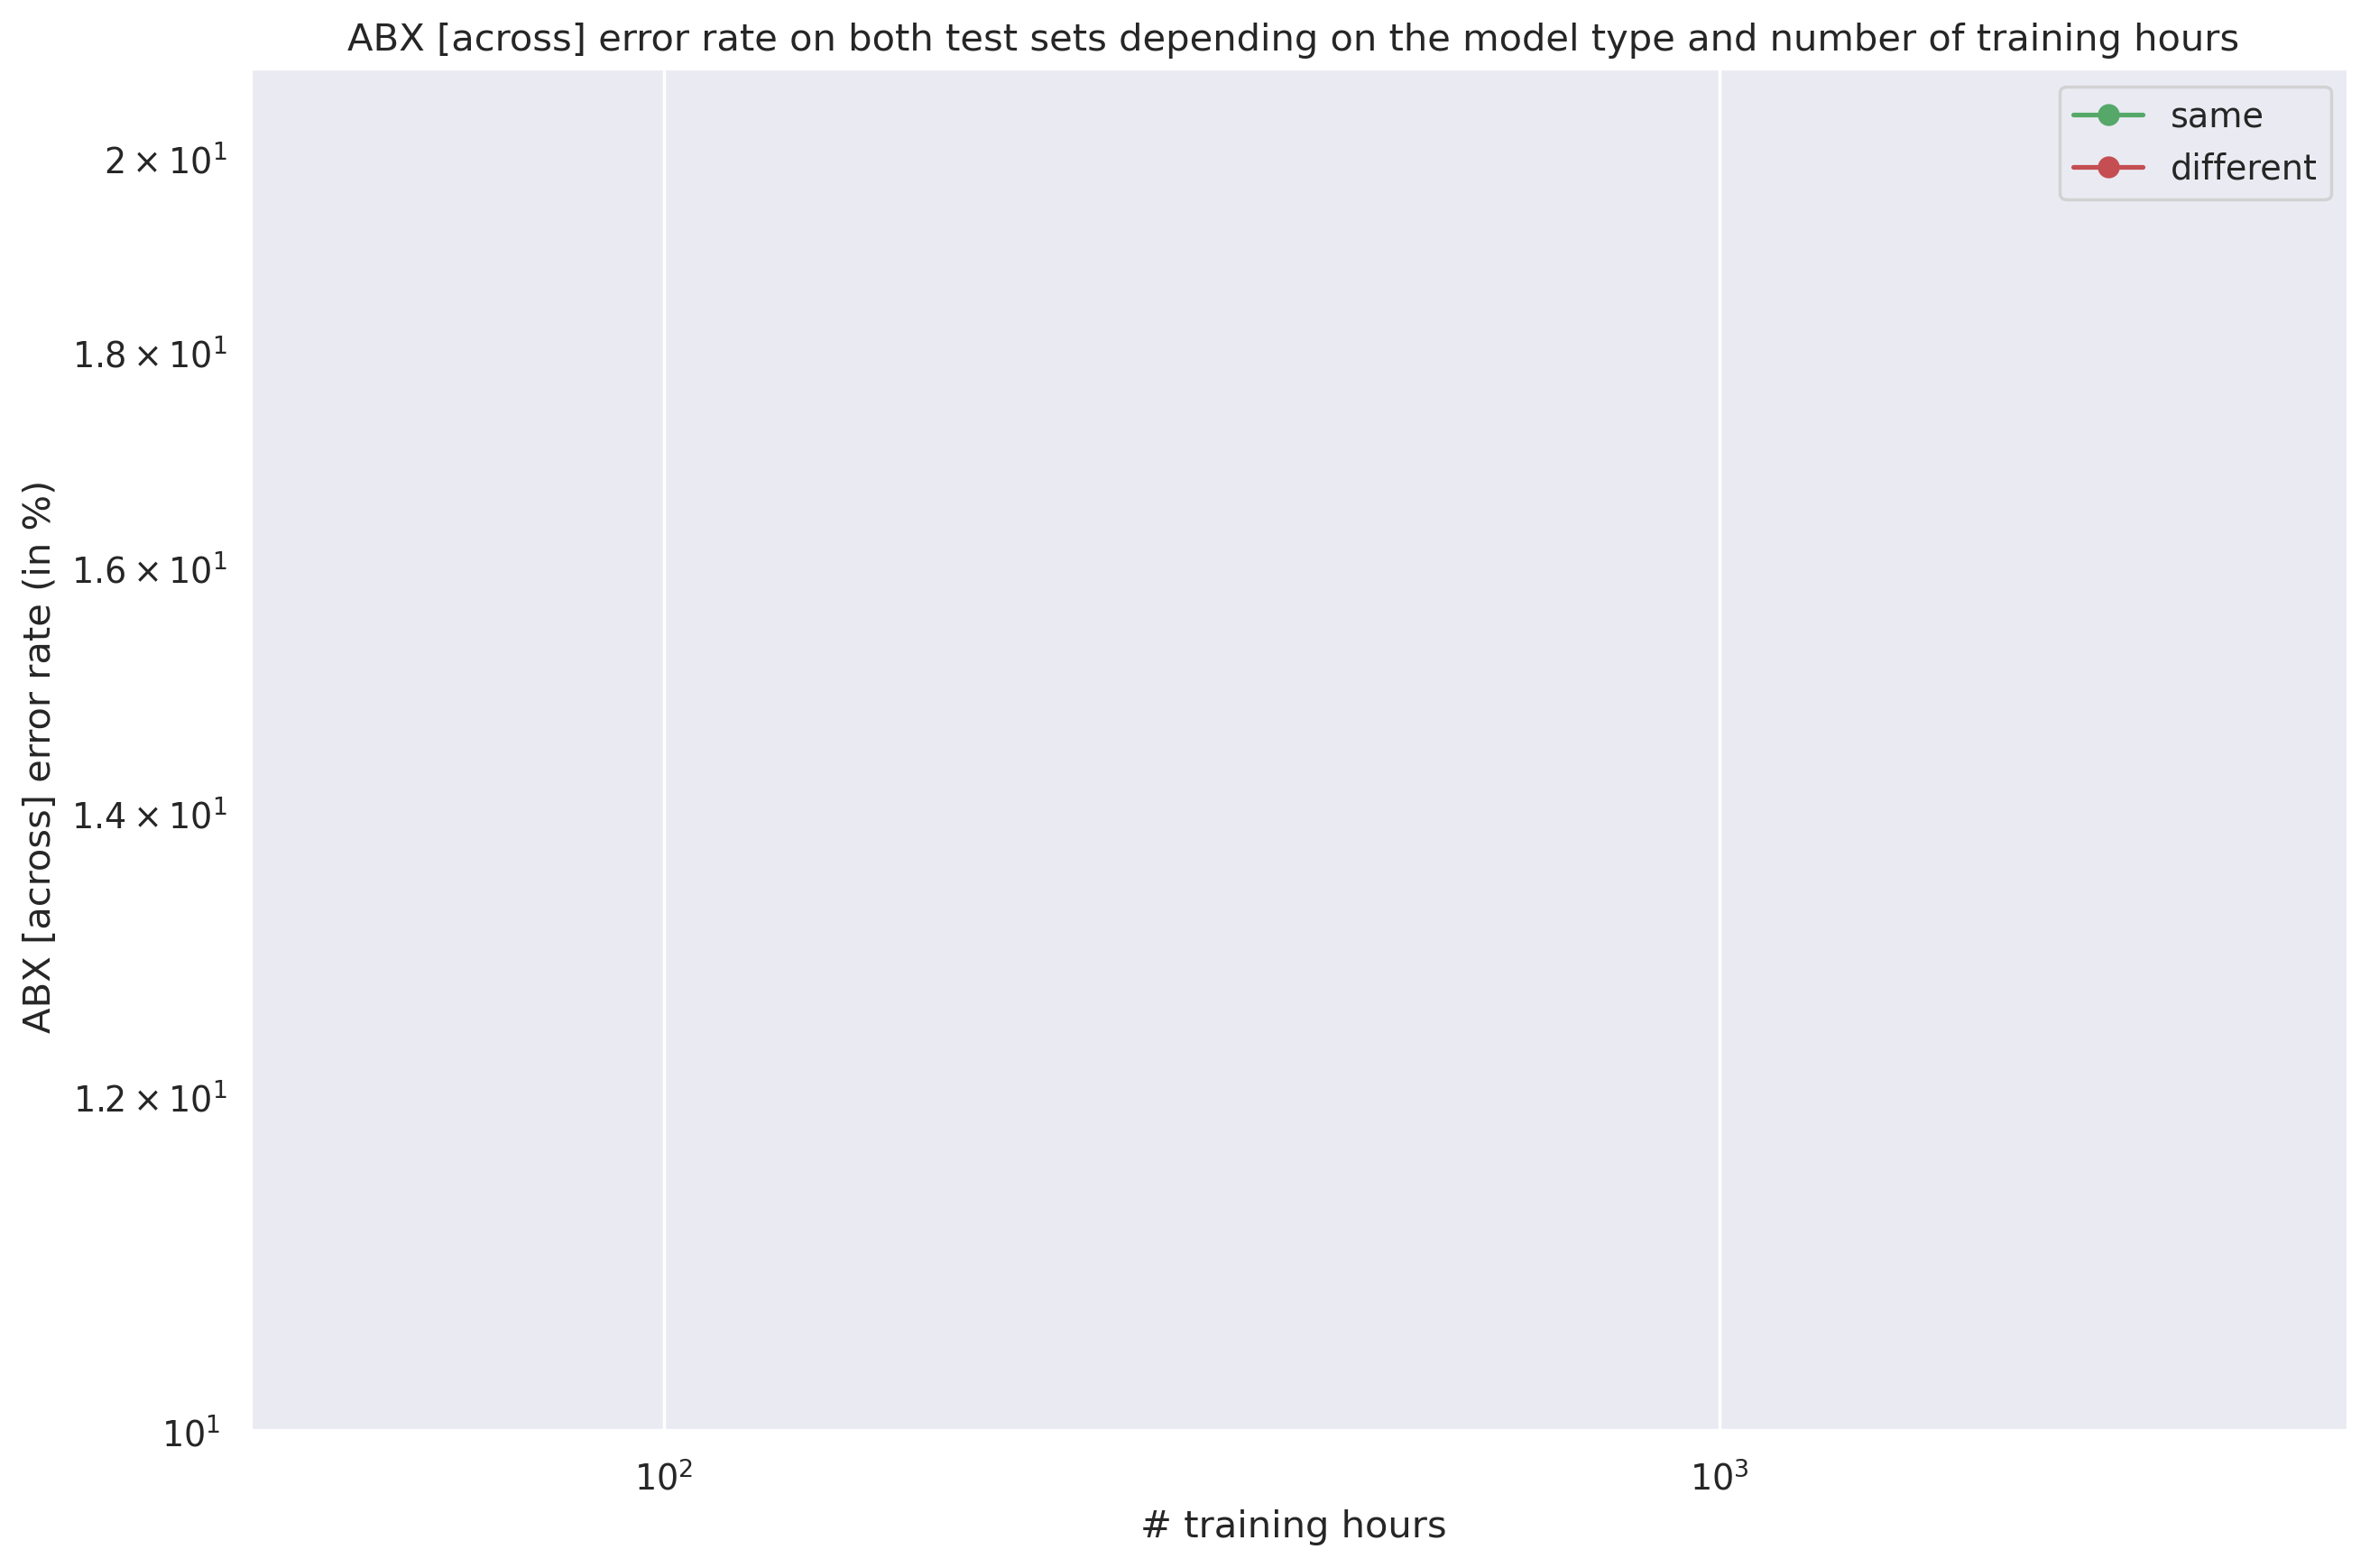

In [20]:
#df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
df_across_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %) ")
plt.title("ABX [across] error rate on both test sets depending on the model type and number of training hours ")
plt.ylim([10,21])

(10, 21)

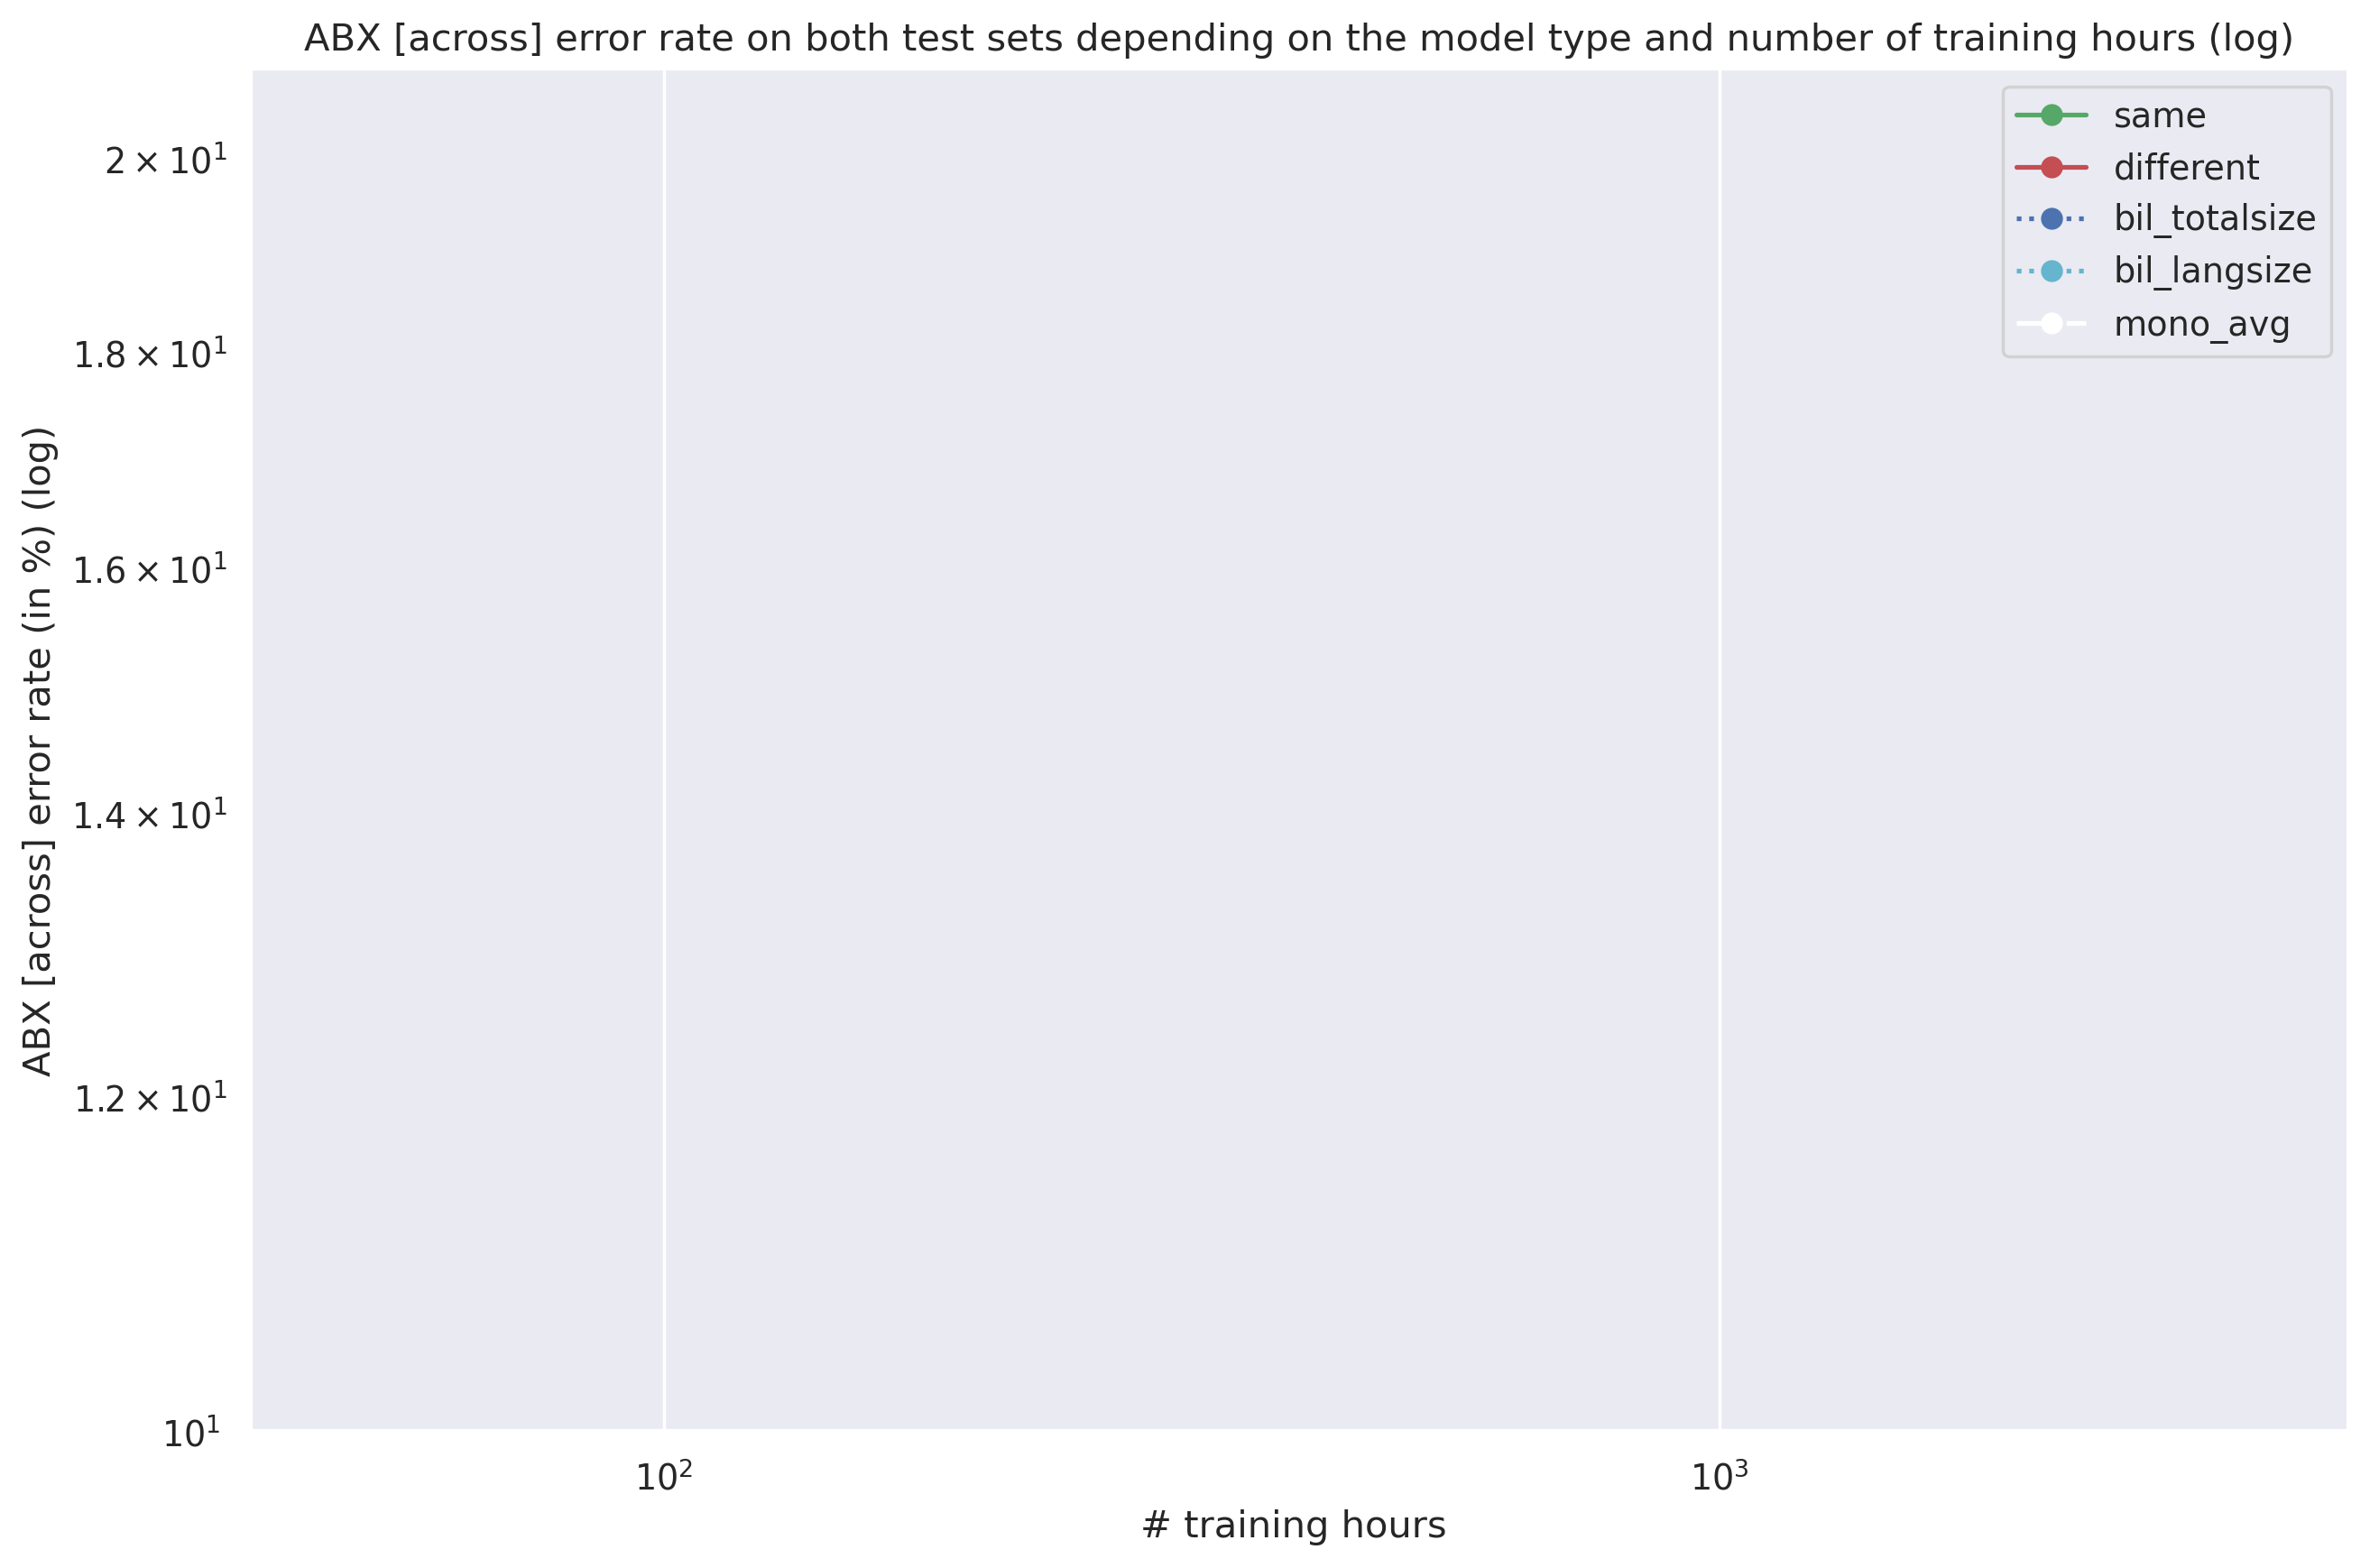

In [21]:
df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_across_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %) (log)")
plt.title("ABX [across] error rate on both test sets depending on the model type and number of training hours (log)")
plt.ylim([10,21])

### D3a. Developmental [within] ABX  on the French test set 

Text(0.5, 1.0, 'ABX [within] error rate on the FRENCH evaluation set')

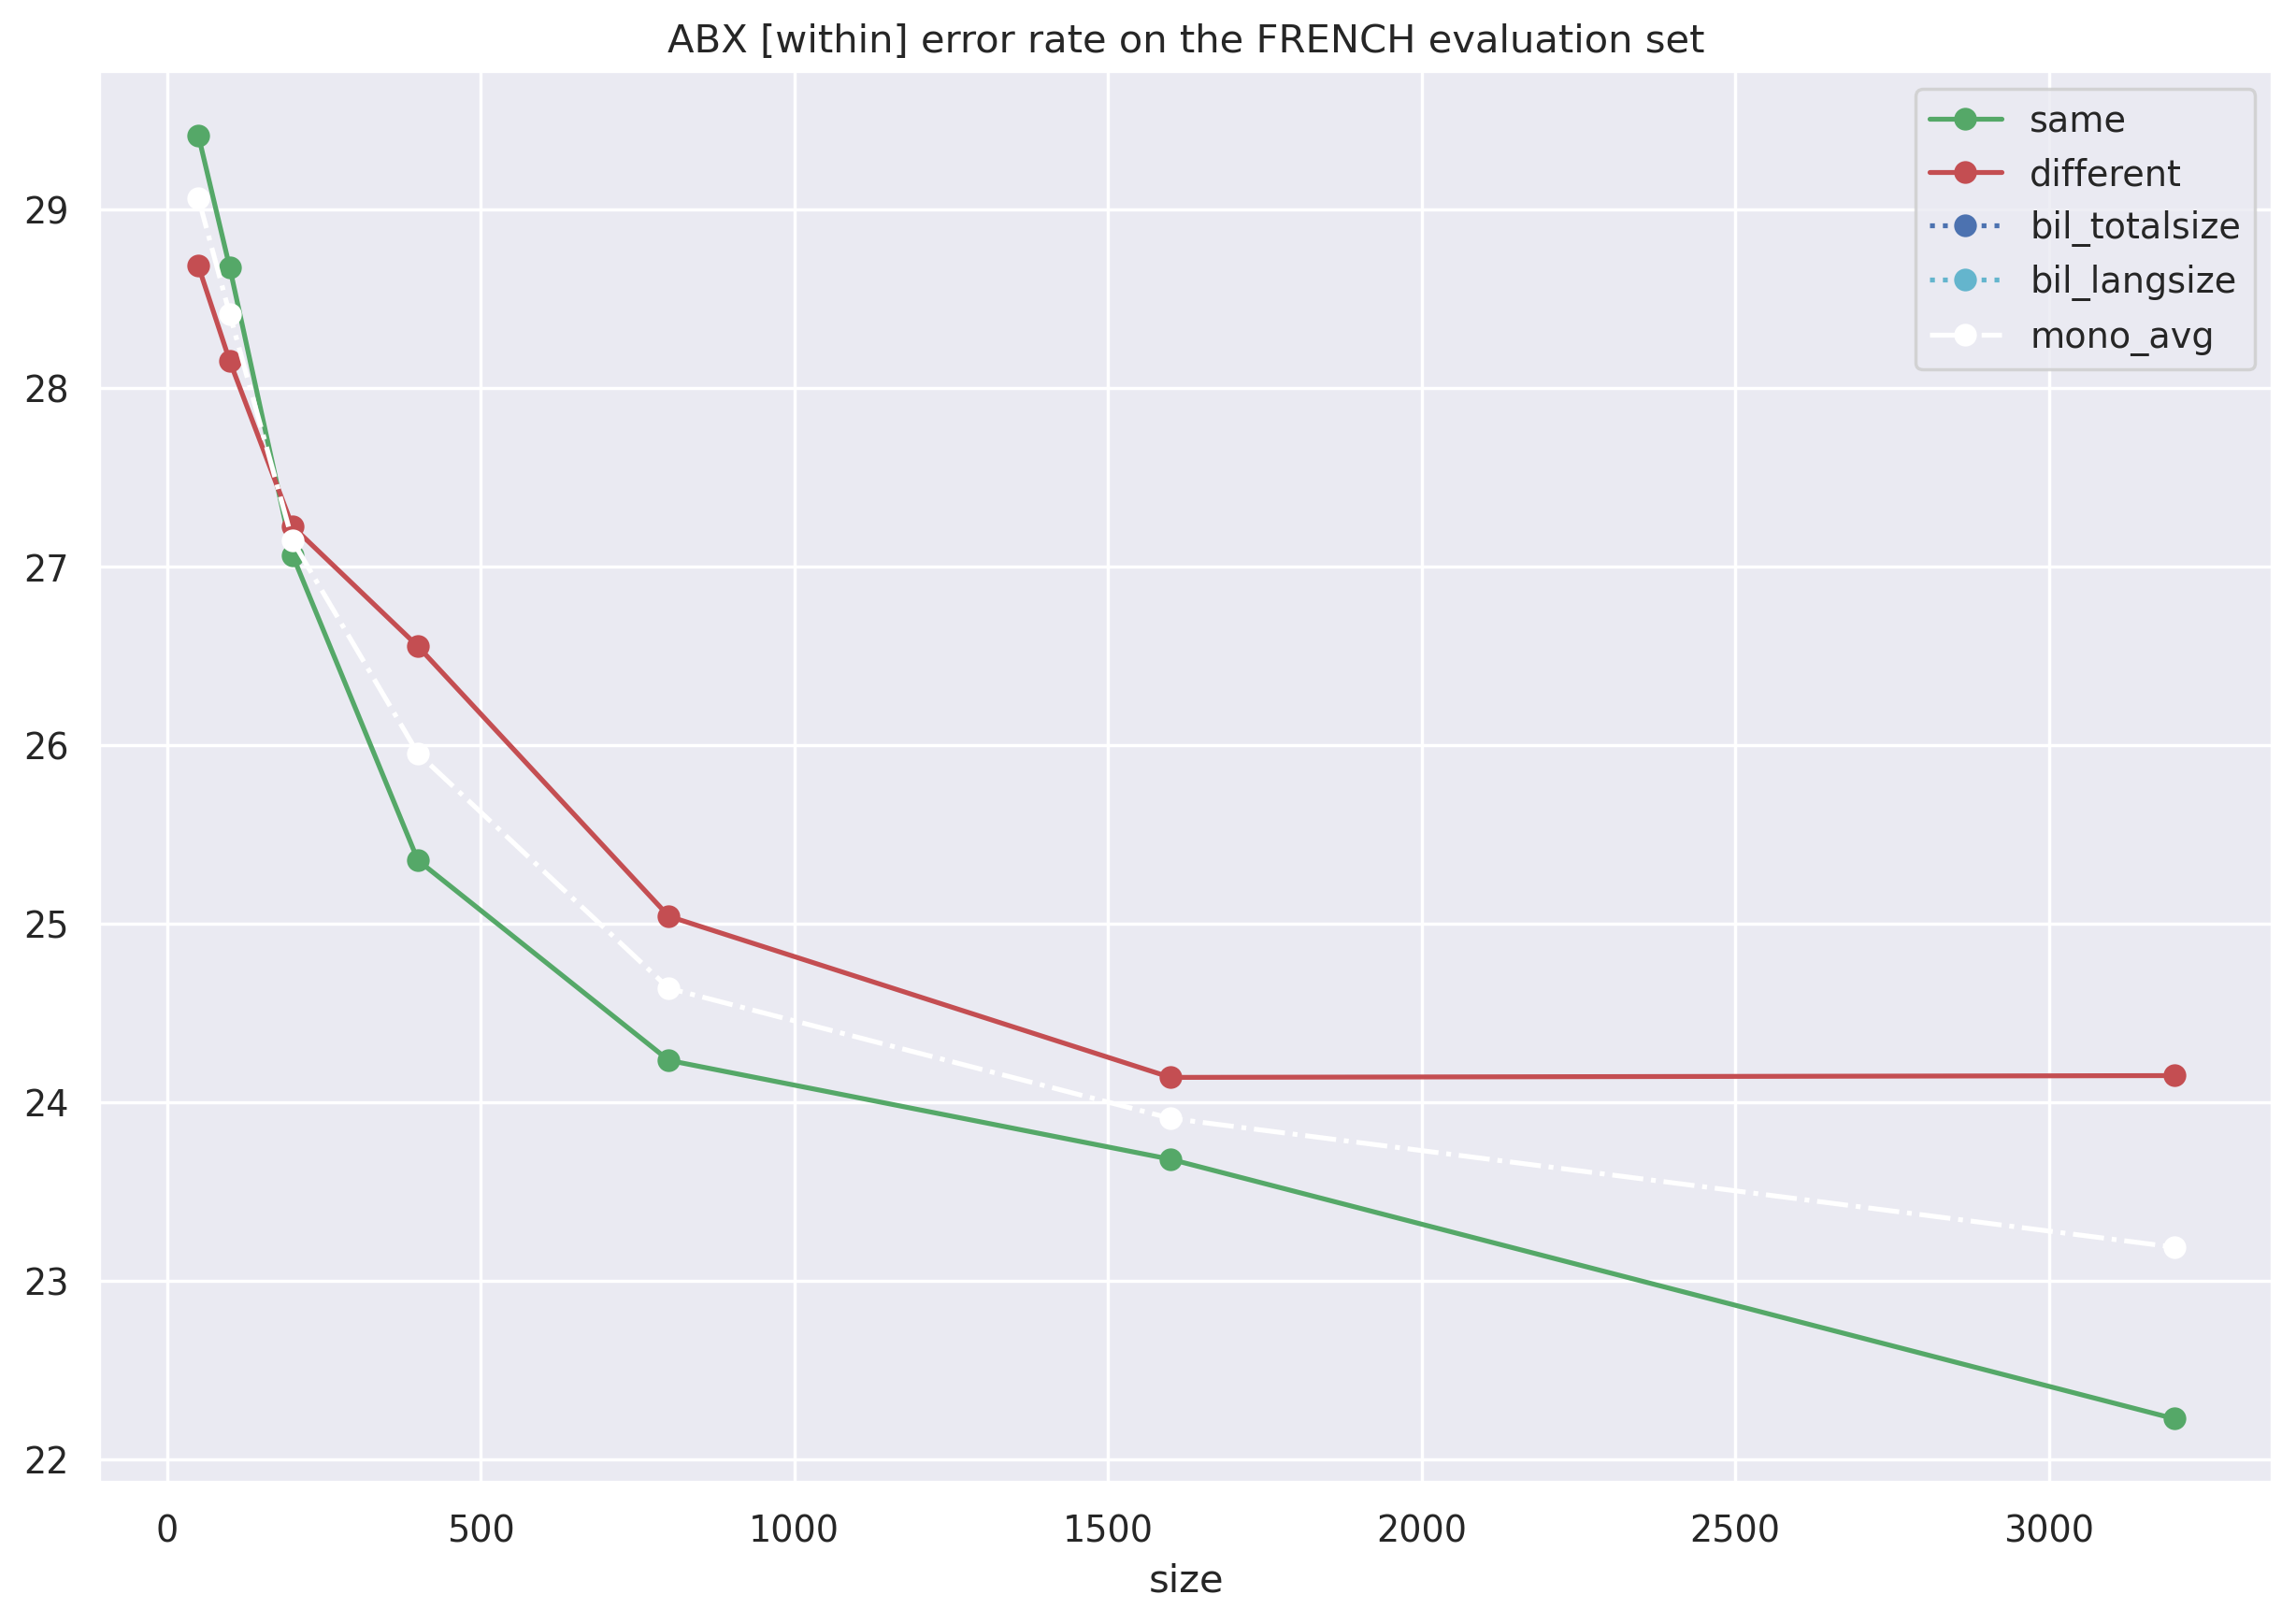

In [22]:
l="fr"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate on the FRENCH evaluation set")


### D3c. Developmental [within] ABX  on the French test set - Loglog scale

(10, 17)

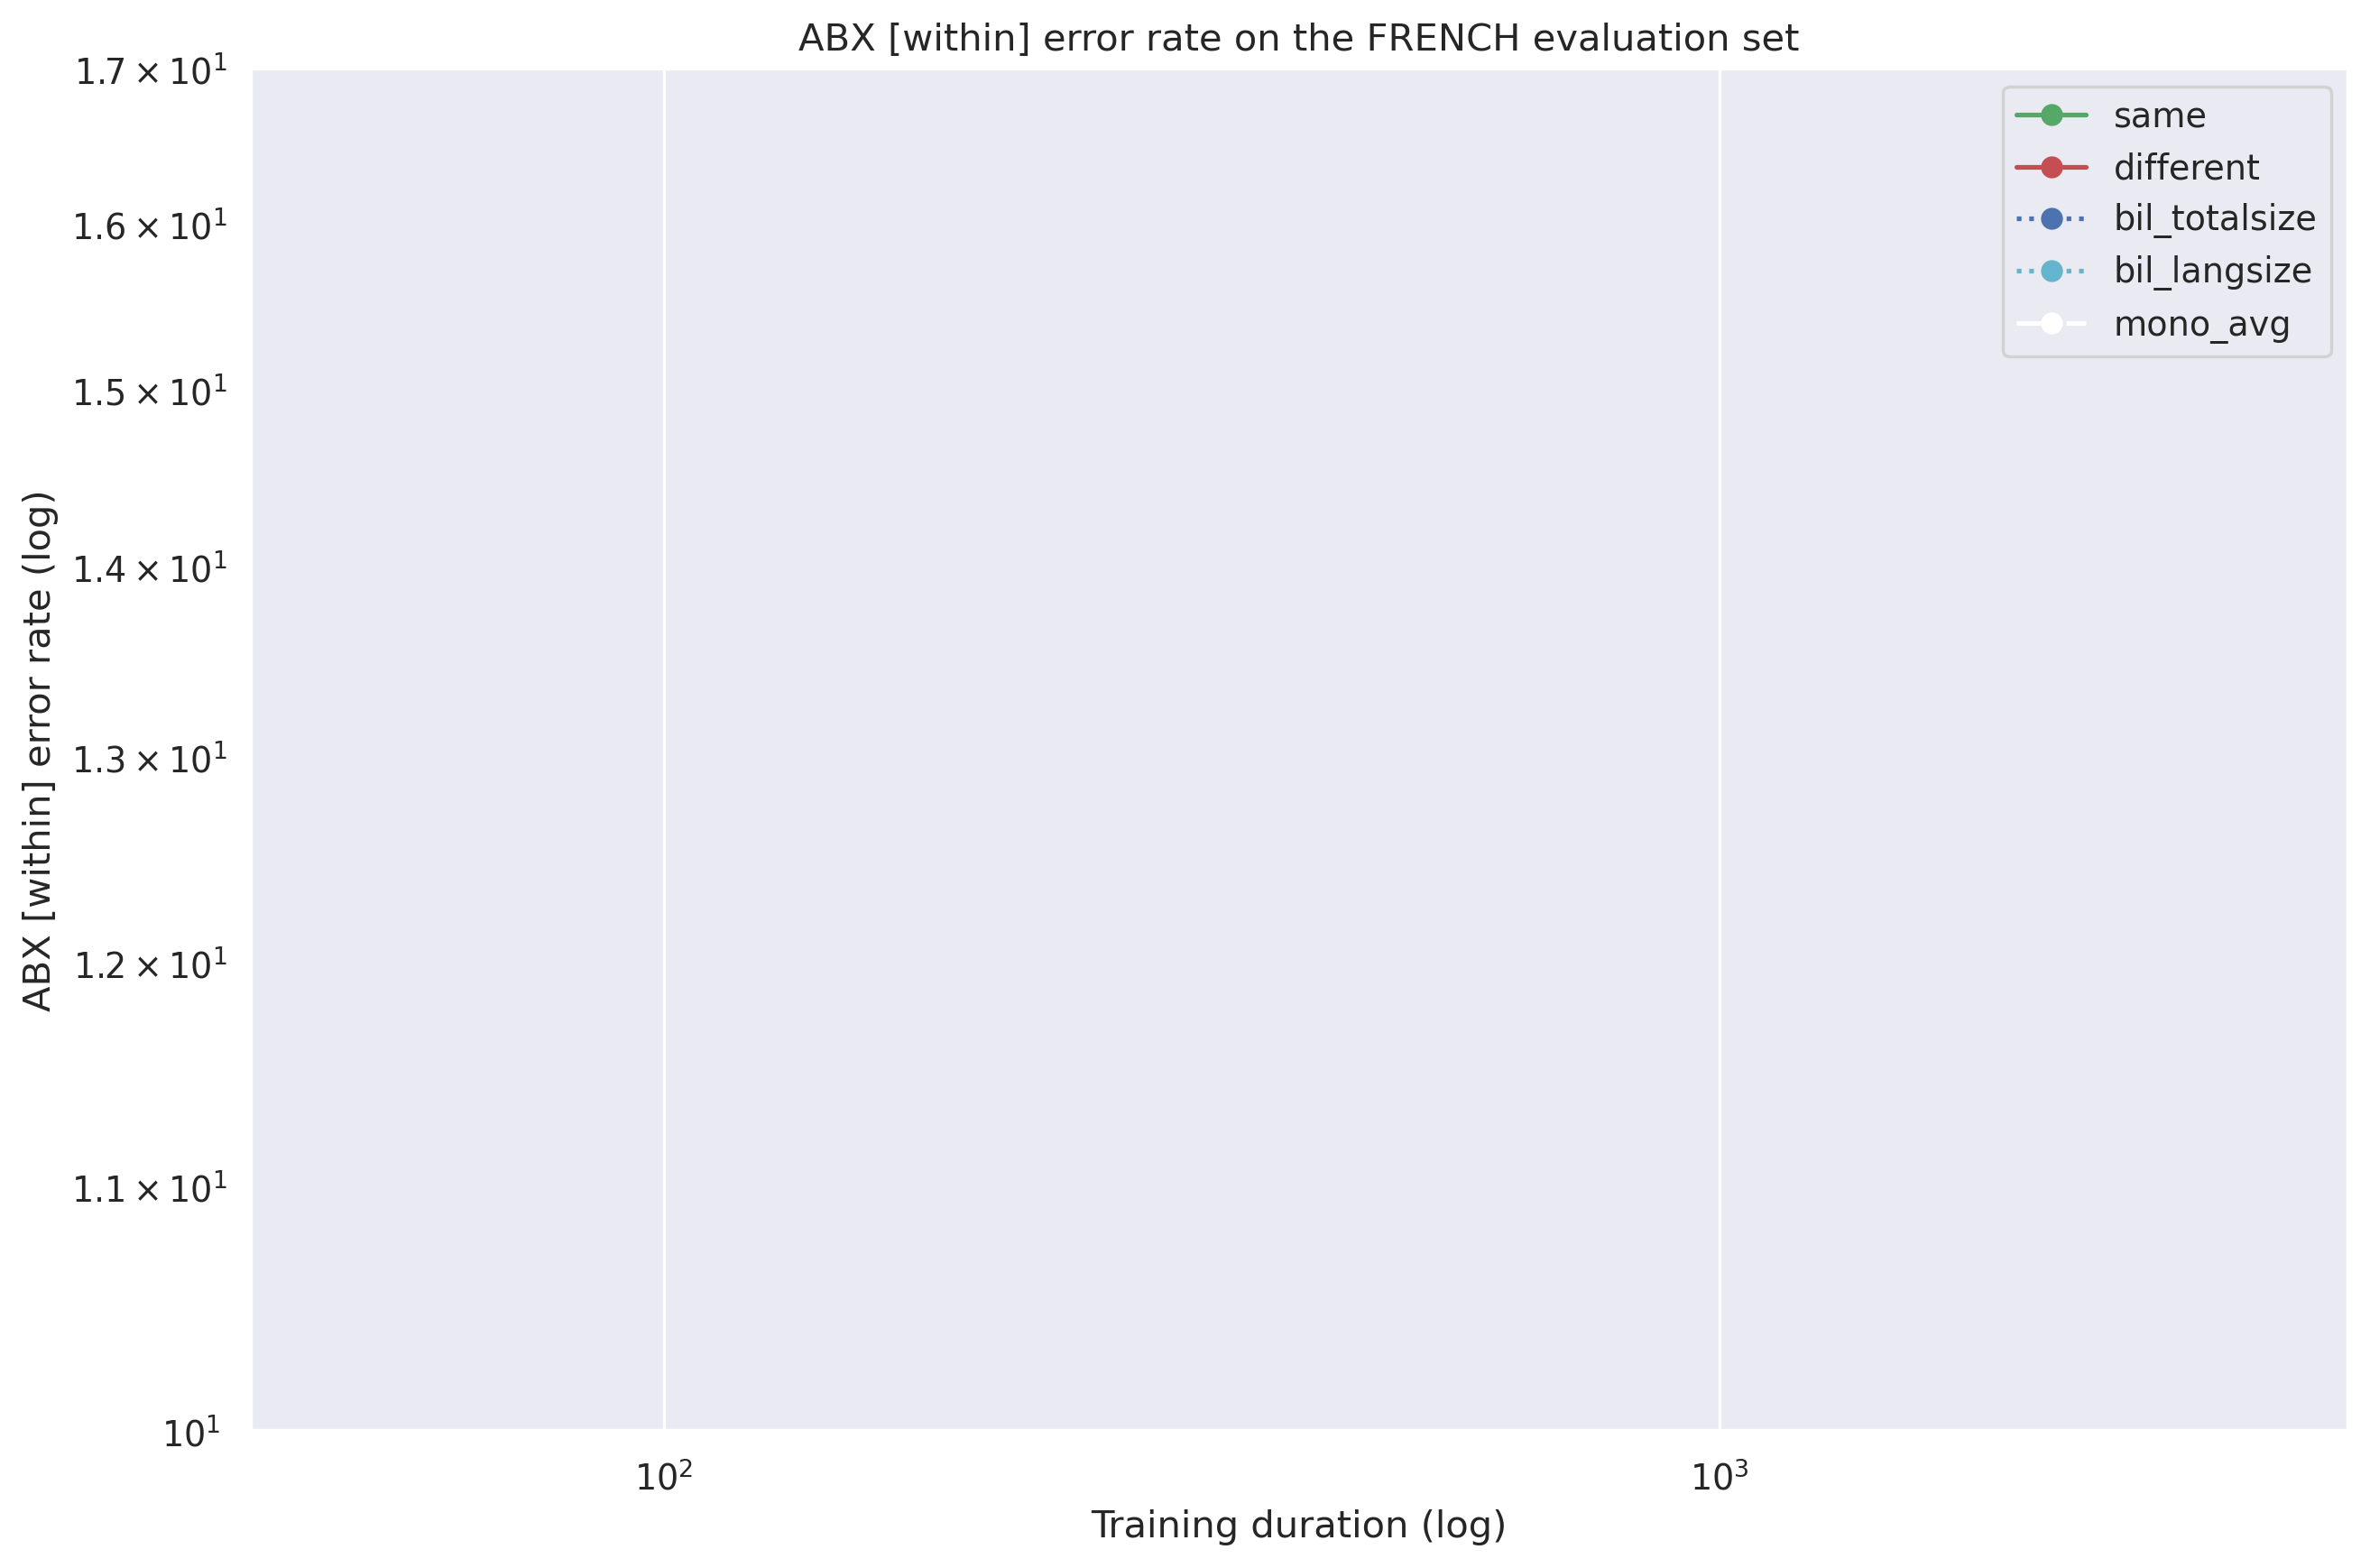

In [23]:
#log

l="fr"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
plt.ylim([10,17])

### D4a. Developmental [within] ABX on the English test set

(10.0, 17.0)

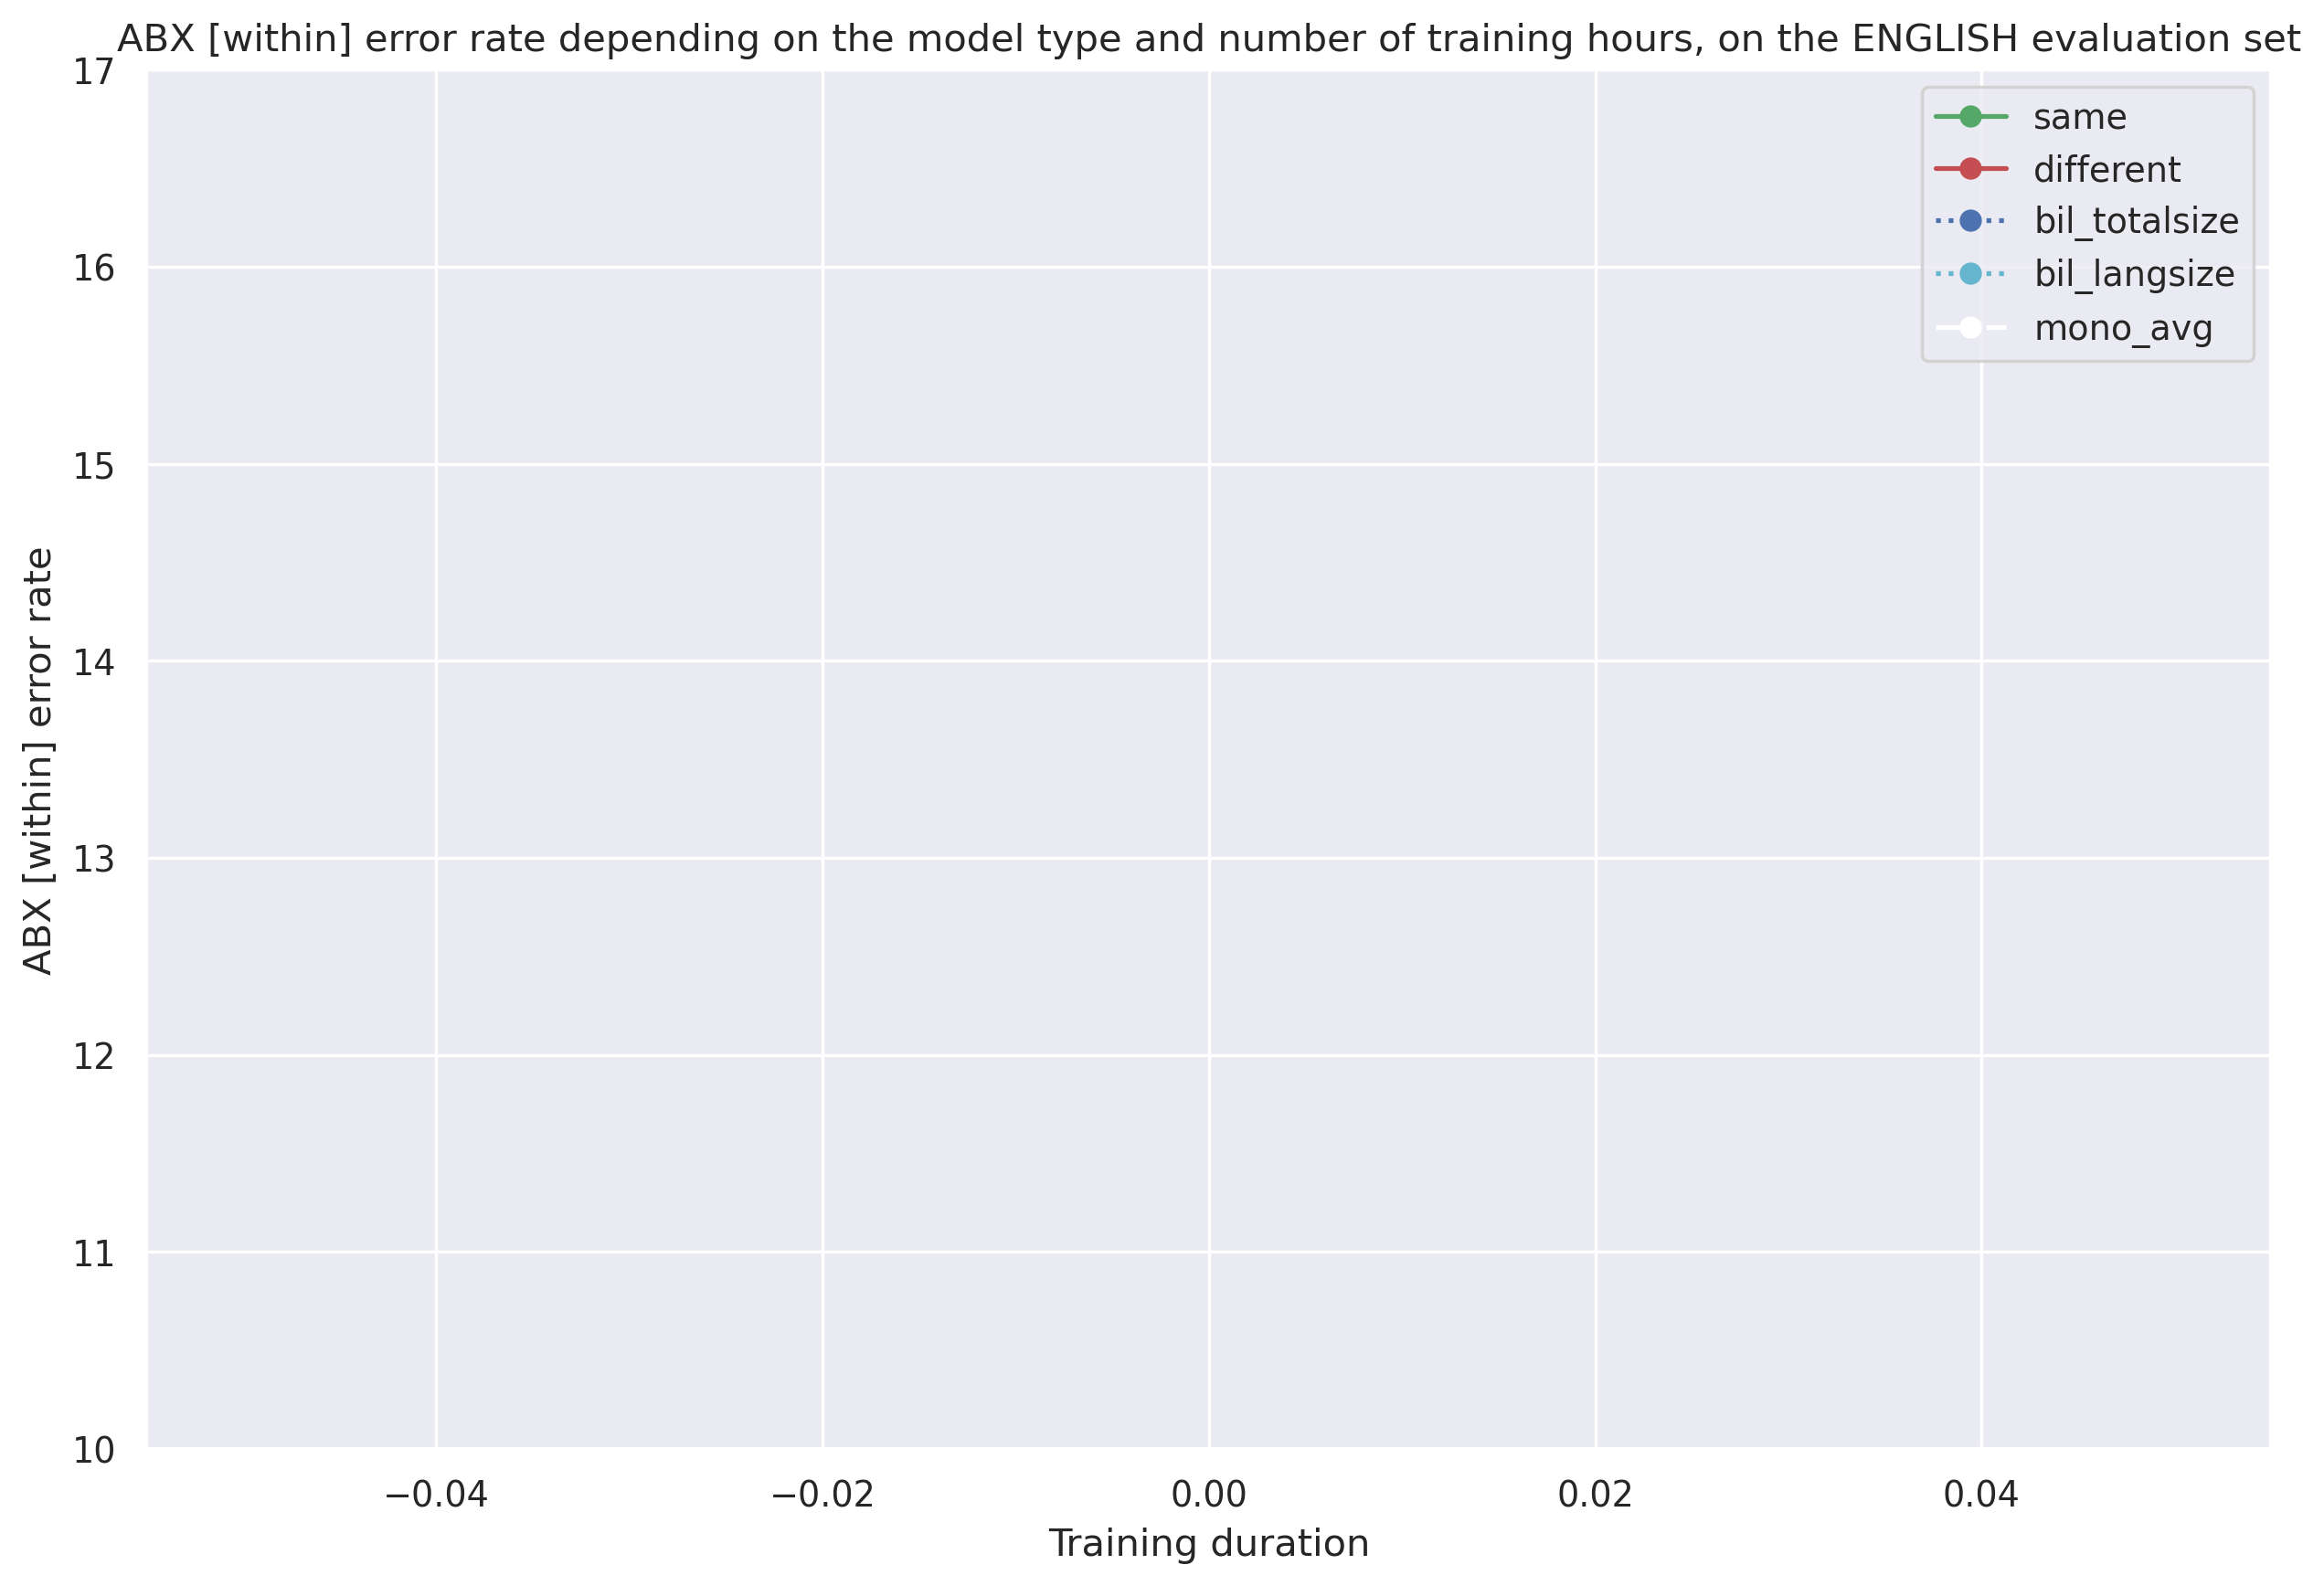

In [24]:
l="en"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate depending on the model type and number of training hours, on the ENGLISH evaluation set")
plt.xlabel("Training duration")
plt.ylabel("ABX [within] error rate")
plt.ylim([10,17])

### D4a. Developmental [within] ABX on the English test set - loglog scale

(10, 17)

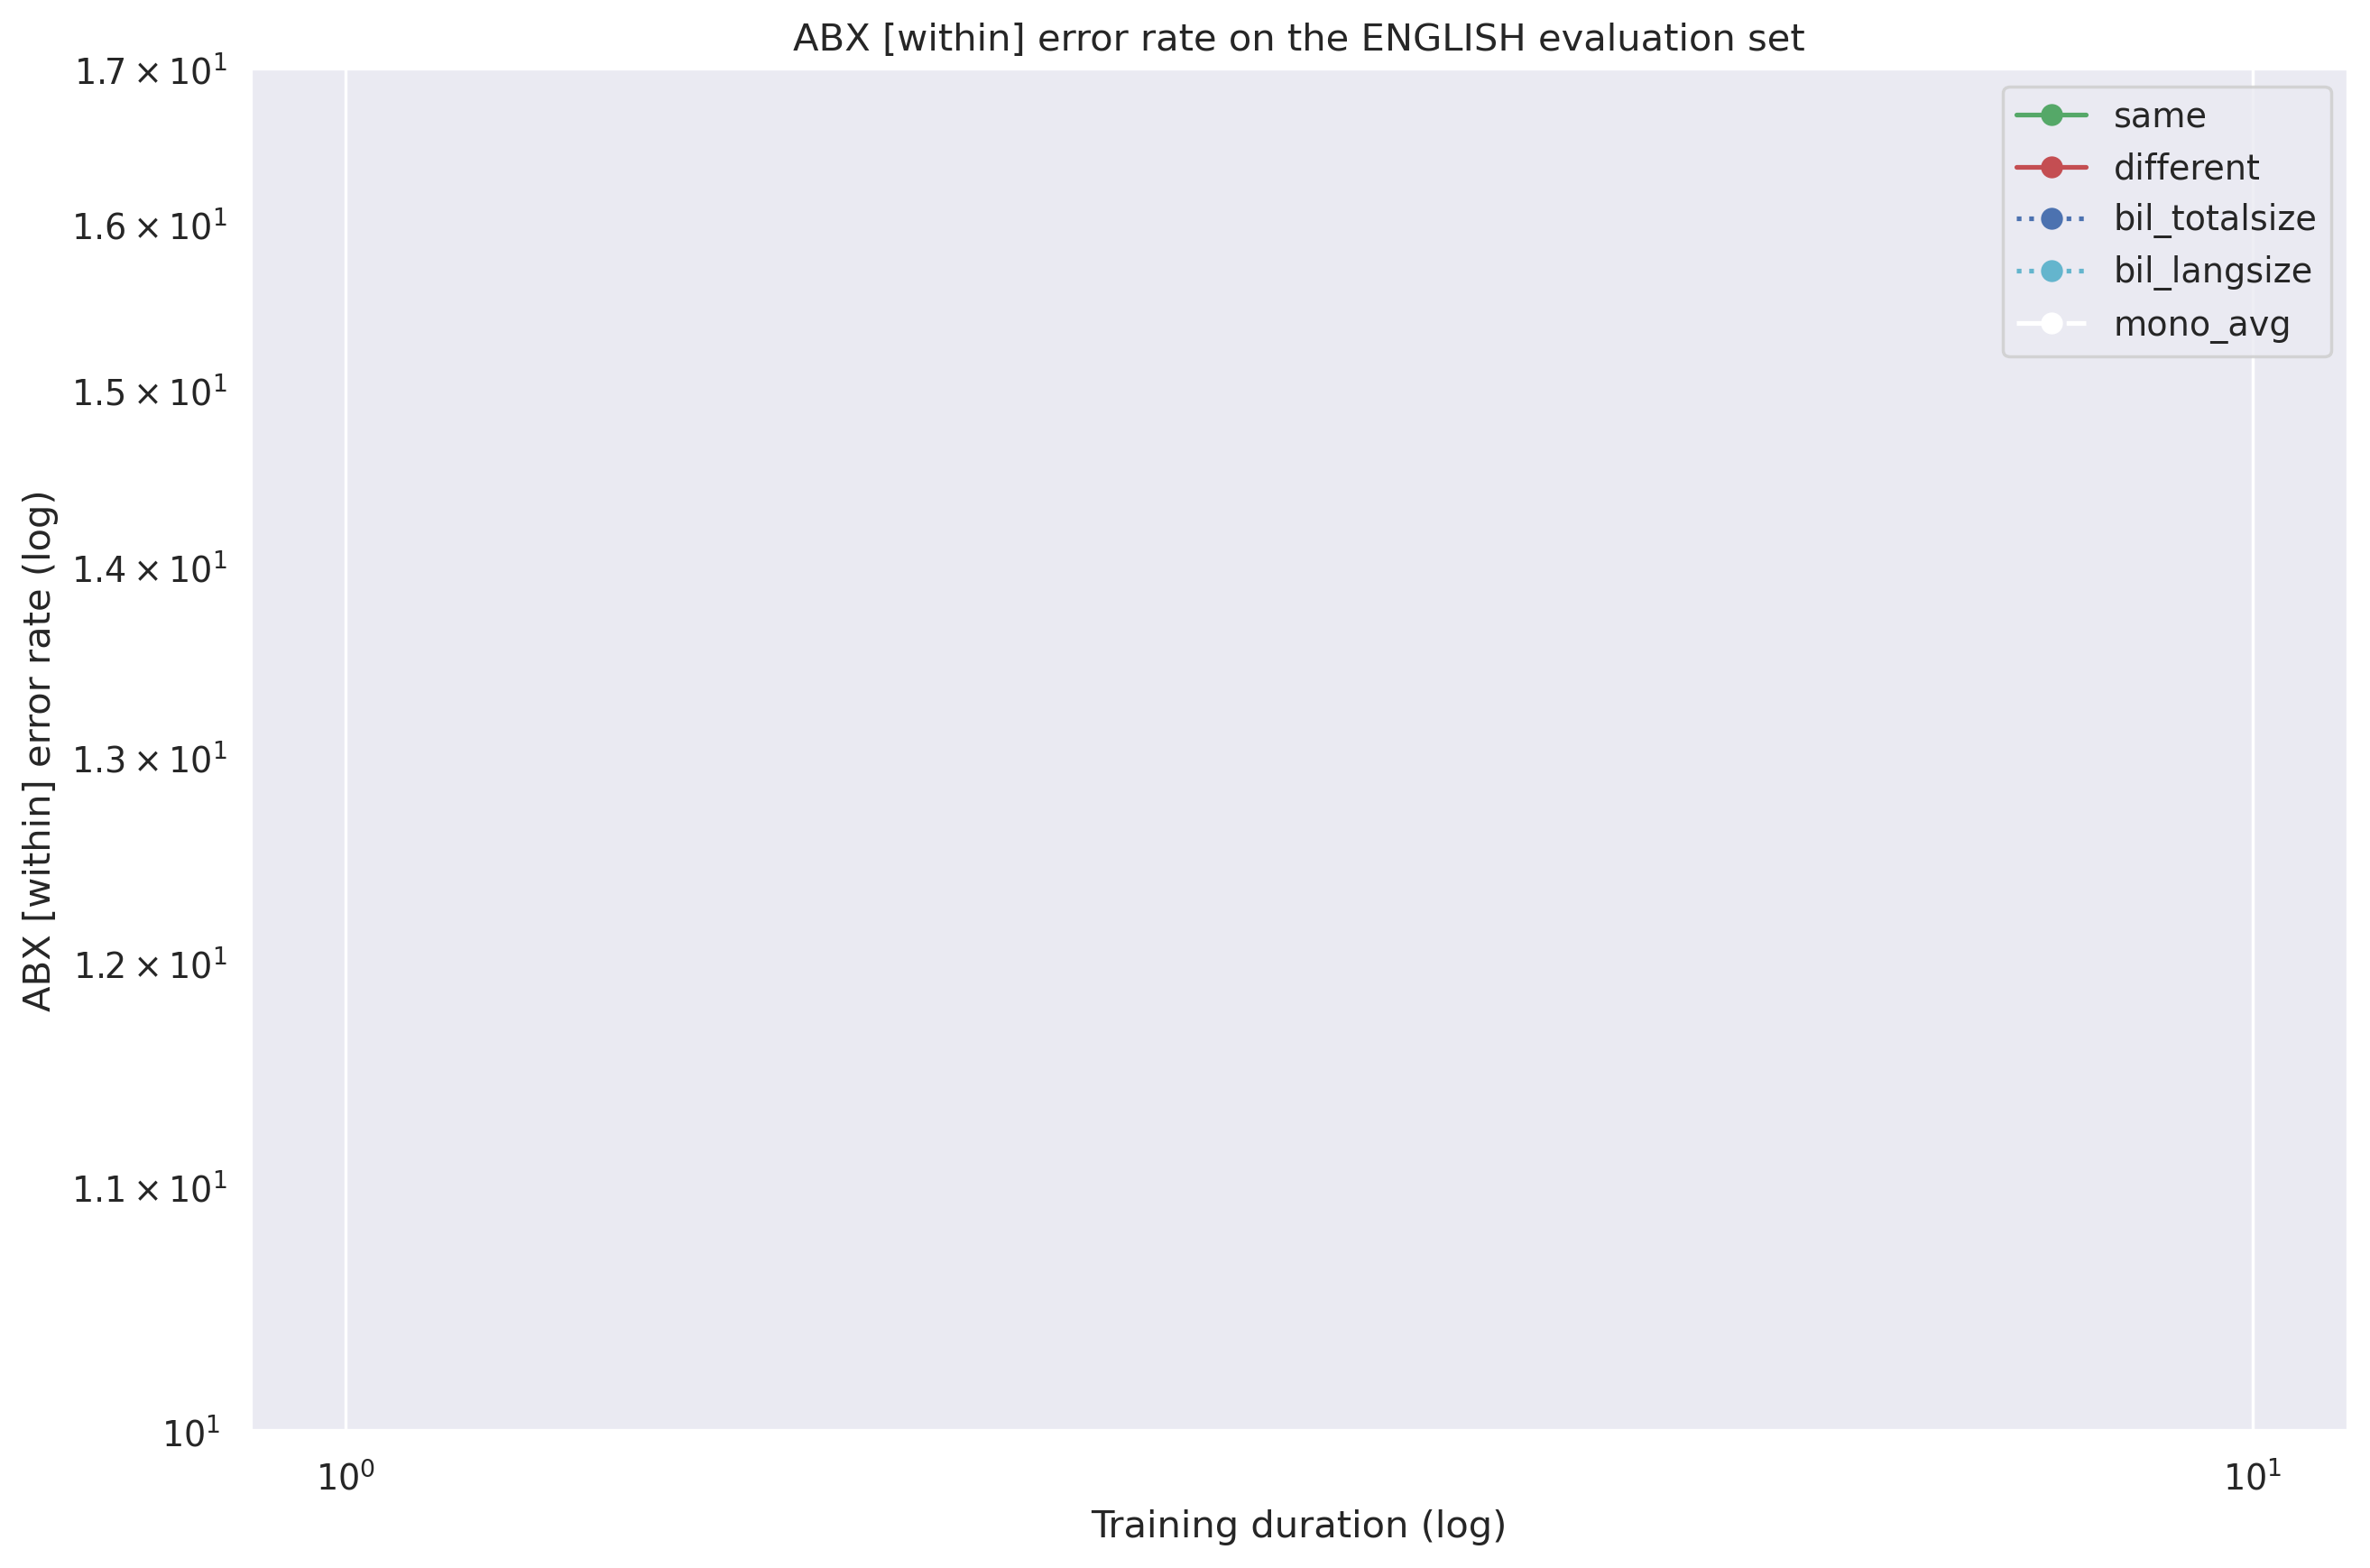

In [25]:
l="en"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
plt.ylim([10,17])

### D5. Developmental [across] ABX  on the French test set (original and QuickFix) - LogLog

(12, 21)

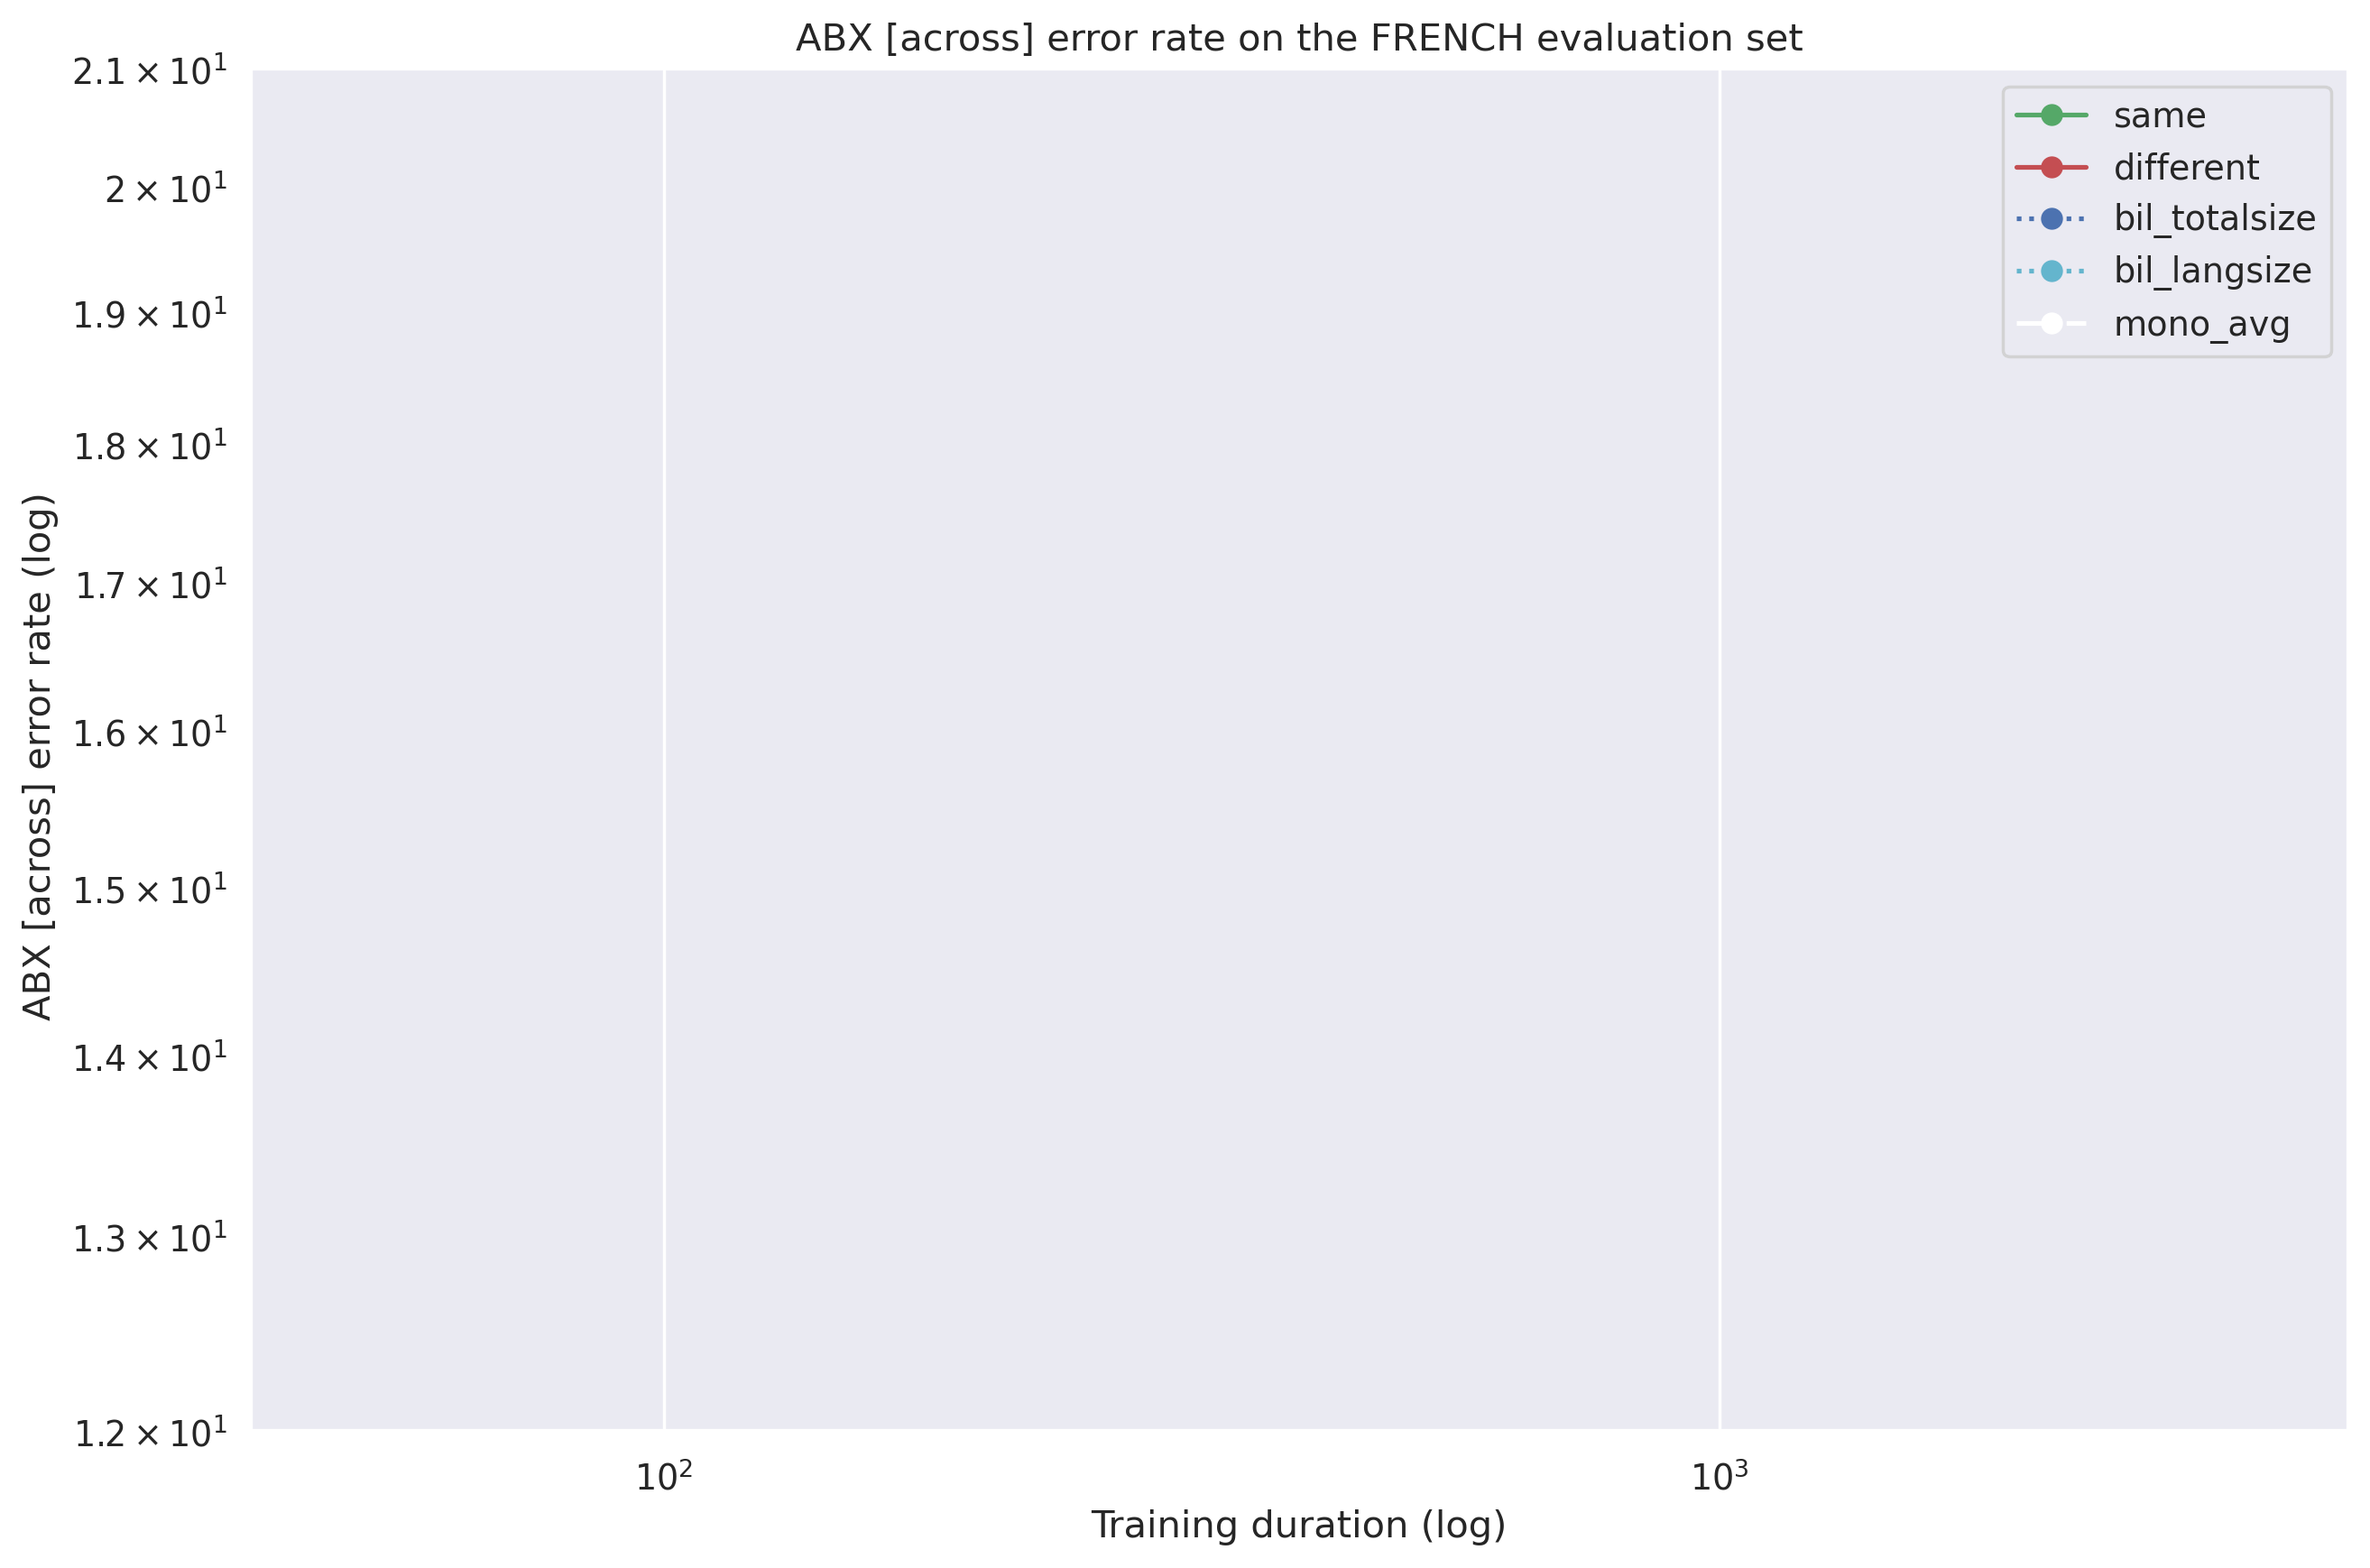

In [26]:
l="fr"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
plt.title("ABX [across] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [across] error rate (log) ")
plt.ylim([12,21])


### D6. Developmental [across] ABX  on the English test set (original and QuickFix) - LogLog

(12, 21)

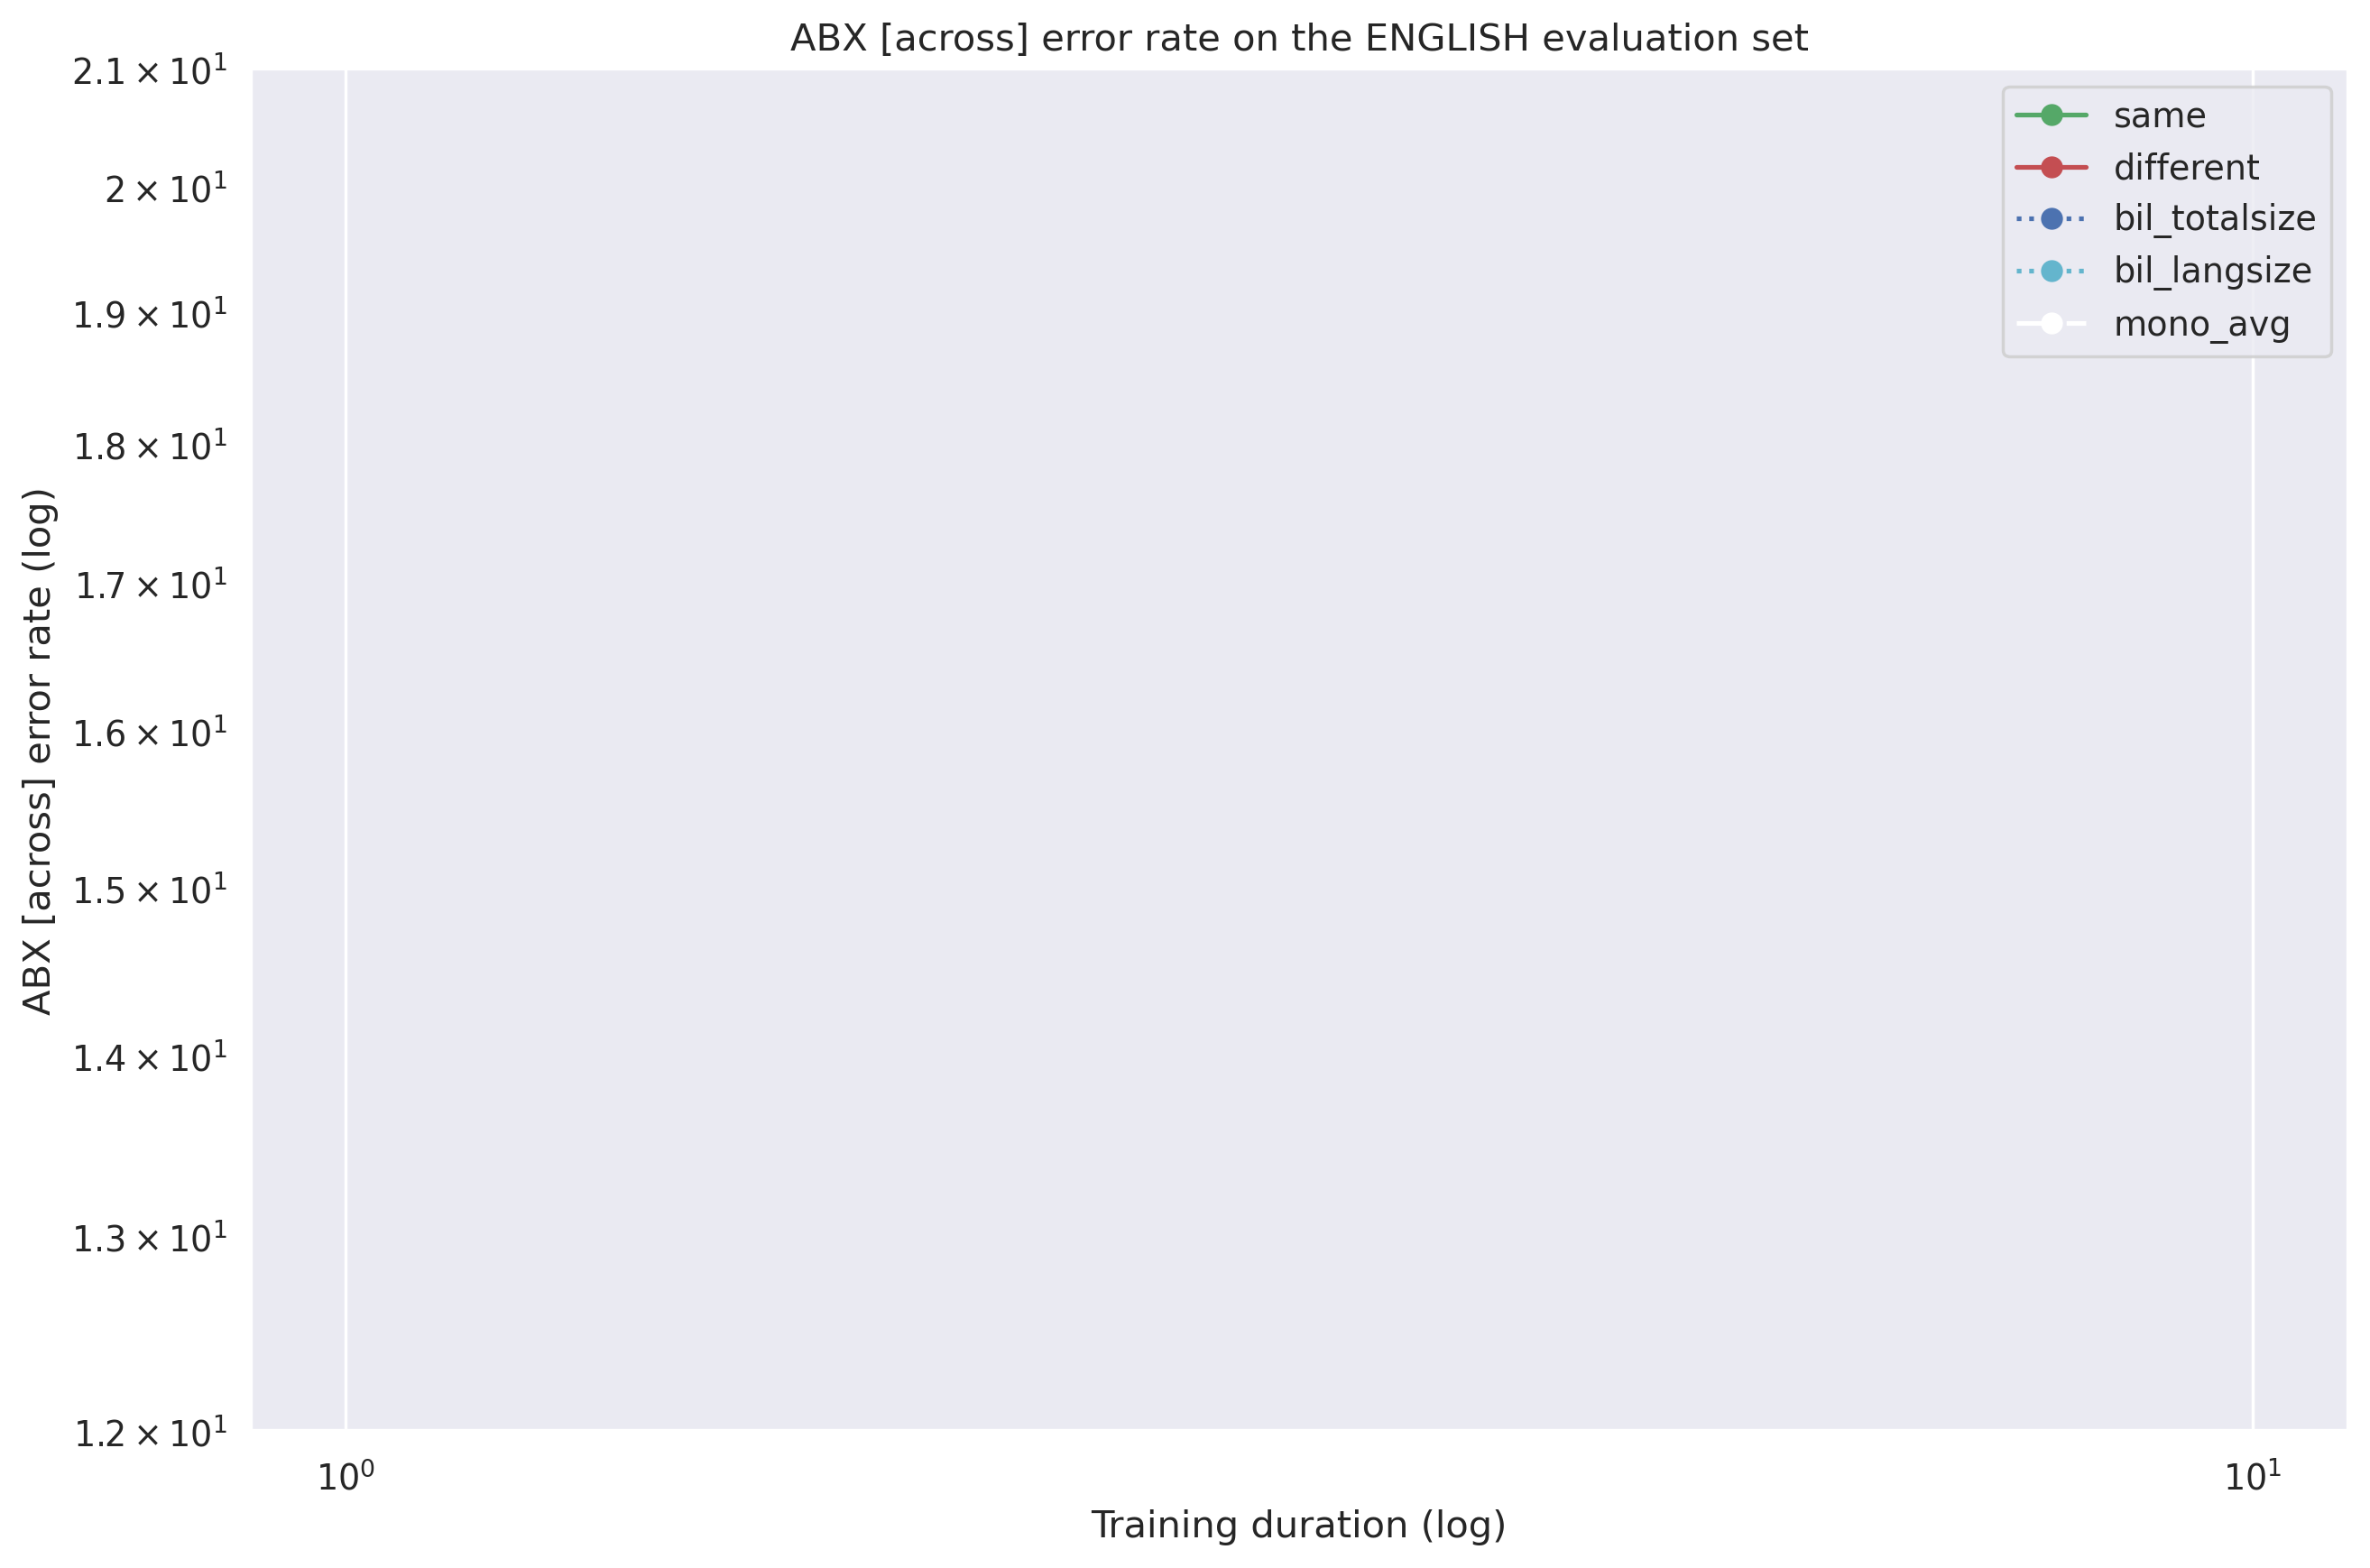

In [27]:
l="en"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)

plt.title("ABX [across] error rate on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [across] error rate (log)")
plt.ylim([12,21])

###  Calculating Relative Advantage per data doubling :
Eg There is a **x** improvement when we double the data

In [28]:
l="fr"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df

,en_model,fr_model,bil_totalsize_A,bil_totalsize_B,same,different,bil_langsize,bil_totalsize,mono_avg
size,,,,,,,,,
50,28.683401,29.415095,NaN,NaN,29.415095,28.683401,NaN,NaN,29.063750
100,28.151514,28.675557,NaN,NaN,28.675557,28.151514,NaN,NaN,28.413536
200,27.224970,27.064936,NaN,NaN,27.064936,27.224970,NaN,NaN,27.144953
400,26.552702,25.354028,NaN,NaN,25.354028,26.552702,NaN,NaN,25.953365
800,25.040361,24.233128,NaN,NaN,24.233128,25.040361,NaN,NaN,24.636745
1600,24.137743,23.679017,NaN,NaN,23.679017,24.137743,NaN,NaN,23.908380
3200,24.147865,22.225781,NaN,NaN,22.225781,24.147865,NaN,NaN,23.186823


In [29]:
df = df_within.groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -4.549525191282594
different -2.8122093886592907
bil_langsize nan
bil_totalsize nan


In [30]:
df = df_across.groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -3.51806354396072
different -2.2155757022340965
bil_langsize nan
bil_totalsize nan


In [31]:
l="fr"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -4.549525191282594
different -2.8122093886592907
bil_langsize nan
bil_totalsize nan


In [32]:
l="en"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same nan
different nan
bil_langsize nan
bil_totalsize nan


In [33]:
l="fr"
df = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -3.51806354396072
different -2.2155757022340965
bil_langsize nan
bil_totalsize nan


In [34]:
l="en"
df = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same nan
different nan
bil_langsize nan
bil_totalsize nan
